### Importing Libraries

In [3]:
import pandas as pd
# from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
import numpy as np
from pandas.tseries.offsets import DateOffset
import seaborn as sns
mpl.rcParams['figure.figsize'] = (20,5)
mpl.rcParams['axes.grid'] = False
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, ConvLSTM2D,Input, RepeatVector,TimeDistributed,Conv1D, MaxPooling1D
from matplotlib import rcParams
import pywt

# Ignore all warnings
warnings.filterwarnings("ignore")
!pip install EMD-signal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Retrieving Data

In [4]:
df = pd.read_csv('rn.csv')

In [5]:
df[df['From Date'] < '2018-01-11']

From Date           To Date  PM2.5    PM10     NO    NO2    NOx  \
0        1/1/2020 0:00     2/1/2020 0:00  54.66  129.15  33.13  33.83  66.98   
1        2/1/2020 0:00     3/1/2020 0:00  60.25  117.23  17.77  28.03  45.81   
9       10/1/2020 0:00    11/1/2020 0:00  51.17  106.16  18.92  42.38  60.65   
10      11/1/2020 0:00    12/1/2020 0:00  53.45  118.12  22.49  46.93  69.43   
11      12/1/2020 0:00  13-01-2020 00:00  86.99  446.69  28.74  45.96  74.72   
...                ...               ...    ...     ...    ...    ...    ...   
7497  16-05-2023 00:00  17-05-2023 00:00  17.22   37.91  33.19   3.56  36.73   
7498  17-05-2023 00:00  18-05-2023 00:00  14.51   34.31  26.09   6.82  32.44   
7499  18-05-2023 00:00  19-05-2023 00:00   11.6   37.21  20.53   6.96  27.49   
7500  19-05-2023 00:00  20-05-2023 00:00  10.53   34.62  23.54   6.96   30.5   
7501  20-05-2023 00:00  21-05-2023 00:00  13.55   38.88  22.39   6.19  28.58   

       NH3    SO2    CO  ...     RH    WS      WD      SR       BP    RF  \
0     None  12.36  2.55  ...  65.36  0.09  125.67  114.69   769.84     0   
1     None   14.1  2.38  ...  71.28  0.08  109.09  112.69   771.42     0   
9     None  28.22  2.62  ...  58.63  0.83  129.27  113.19   768.61     0   
10    None  34.97  3.06  ...  62.33   0.4  123.81  115.65   769.33     0   
11    None  33.24  3.86  ...   69.3  0.19  163.13  107.75   769.04     0   
...    ...    ...   ...  ...    ...   ...     ...     ...      ...   ...   
7497  4.79   1.71  1.67  ...  77.13  1.09  221.64  287.07  1010.37  None   
7498  8.45   3.13  1.58  ...  76.71  0.95  226.79  293.95  1010.36  None   
7499  9.96   1.95  1.44  ...  77.58  0.98  220.04  282.52  1011.44  None   
7500  9.06   2.31  1.41  ...  79.68  1.07  231.06  288.67  1010.02  None   
7501  9.76   2.83  1.44  ...  77.95  0.96  232.44  296.55  1009.37  None   

     Xylene     AT TOT-RF Station  
0      None   None    0.0  bandra  
1      None   None    0.0  bandra  
9      None   None    0.0  bandra  
10     None   None    0.0  bandra  
11     None   None    0.0  bandra  
...     ...    ...    ...     ...  
7497   None  30.45    0.0   worli  
7498   None  30.04    0.0   worli  
7499   None   29.8    0.0   worli  
7500   None  29.71    0.0   worli  
7501   None  29.72    0.0   worli  

[3379 rows x 25 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7513 entries, 0 to 7512
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   From Date    7513 non-null   object 
 1   To Date      7513 non-null   object 
 2   PM2.5        7513 non-null   object 
 3   PM10         7513 non-null   object 
 4   NO           7513 non-null   object 
 5   NO2          7513 non-null   object 
 6   NOx          7513 non-null   object 
 7   NH3          7513 non-null   object 
 8   SO2          7513 non-null   object 
 9   CO           7513 non-null   object 
 10  Ozone        7513 non-null   object 
 11  Benzene      7513 non-null   object 
 12  Toluene      7513 non-null   object 
 13  Eth-Benzene  7513 non-null   object 
 14  MP-Xylene    7513 non-null   object 
 15  RH           7513 non-null   object 
 16  WS           7513 non-null   object 
 17  WD           7513 non-null   object 
 18  SR           7513 non-null   object 
 19  BP    

In [7]:
df['From Date'] = pd.to_datetime(df['From Date'],dayfirst=True)

### Data Engineering

In [8]:
df = df.replace('None', np.nan)
df = df.fillna(0)

In [9]:
df

From Date           To Date  PM2.5    PM10      NO    NO2     NOx  \
0    2020-01-01     2/1/2020 0:00  54.66  129.15   33.13  33.83   66.98   
1    2020-01-02     3/1/2020 0:00  60.25  117.23   17.77  28.03   45.81   
2    2020-01-03     4/1/2020 0:00  55.67  100.72   21.19   25.7   46.89   
3    2020-01-04     5/1/2020 0:00  31.42    49.3   16.71  23.64   40.35   
4    2020-01-05     6/1/2020 0:00  44.59    62.4   25.56  30.41   55.98   
...         ...               ...    ...     ...     ...    ...     ...   
7508 2023-05-27  28-05-2023 00:00   14.8   41.44   40.67   3.22   43.31   
7509 2023-05-28  29-05-2023 00:00  13.71   34.18   48.08   4.37    52.3   
7510 2023-05-29  30-05-2023 00:00  12.57      33   27.21   4.92   30.65   
7511 2023-05-30  31-05-2023 00:00  12.52   34.13  116.82   4.68  120.99   
7512 2023-05-31  31-05-2023 12:33  17.99   38.41   78.98   6.43    85.4   

         NH3    SO2    CO  ...     RH    WS      WD      SR       BP RF  \
0          0  12.36  2.55  ...  65.36  0.09  125.67  114.69   769.84  0   
1          0   14.1  2.38  ...  71.28  0.08  109.09  112.69   771.42  0   
2          0   13.2  2.22  ...  68.72  0.12  127.71  103.66    770.8  0   
3          0   4.21  2.03  ...  64.46   0.1  113.06  107.06   769.49  0   
4          0    3.9  2.43  ...  64.61  0.26  127.22  106.37   768.44  0   
...      ...    ...   ...  ...    ...   ...     ...     ...      ... ..   
7508   27.12  12.48  1.49  ...  74.44  1.22  221.75  263.94  1010.32  0   
7509   37.77   13.7   1.5  ...  75.51  0.93  230.95  279.35  1009.22  0   
7510   22.84  13.68  1.52  ...  78.54  1.02  228.69   263.7   1008.8  0   
7511  105.89   15.6  1.63  ...  78.79  0.97  223.63  304.63   1008.8  0   
7512   68.11  18.25  1.95  ...   80.9  0.82  222.21  297.13  1009.08  0   

     Xylene     AT TOT-RF Station  
0         0      0    0.0  bandra  
1         0      0    0.0  bandra  
2         0      0    0.0  bandra  
3         0      0    0.0  bandra  
4         0      0    0.0  bandra  
...     ...    ...    ...     ...  
7508      0  30.32    0.0   worli  
7509      0  30.45    0.0   worli  
7510      0  30.26    0.0   worli  
7511      0  30.27    0.0   worli  
7512      0  30.24    0.0   worli  

[7513 rows x 25 columns]

In [10]:
df1 = df.copy()
df1.drop(['From Date','To Date','Station'], axis = 'columns', inplace=True)
df1.head()
df1 = df1.astype(float)
df1.head()

PM2.5    PM10     NO    NO2    NOx  NH3    SO2    CO  Ozone  Benzene  ...  \
0  54.66  129.15  33.13  33.83  66.98  0.0  12.36  2.55  35.38     0.00  ...   
1  60.25  117.23  17.77  28.03  45.81  0.0  14.10  2.38  23.03     0.00  ...   
2  55.67  100.72  21.19  25.70  46.89  0.0  13.20  2.22  33.10     0.00  ...   
3  31.42   49.30  16.71  23.64  40.35  0.0   4.21  2.03  36.92     0.01  ...   
4  44.59   62.40  25.56  30.41  55.98  0.0   3.90  2.43  27.56     0.00  ...   

   MP-Xylene     RH    WS      WD      SR      BP   RF  Xylene   AT  TOT-RF  
0        0.0  65.36  0.09  125.67  114.69  769.84  0.0     0.0  0.0     0.0  
1        0.0  71.28  0.08  109.09  112.69  771.42  0.0     0.0  0.0     0.0  
2        0.0  68.72  0.12  127.71  103.66  770.80  0.0     0.0  0.0     0.0  
3        0.0  64.46  0.10  113.06  107.06  769.49  0.0     0.0  0.0     0.0  
4        0.0  64.61  0.26  127.22  106.37  768.44  0.0     0.0  0.0     0.0  

[5 rows x 22 columns]

In [11]:
df = df.loc[:, ['From Date','To Date','Station']]

In [12]:
final_df = pd.concat([df,df1],axis='columns')
final_df.drop(['To Date'],axis=1,inplace=True)

array([<Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>], dtype=object)

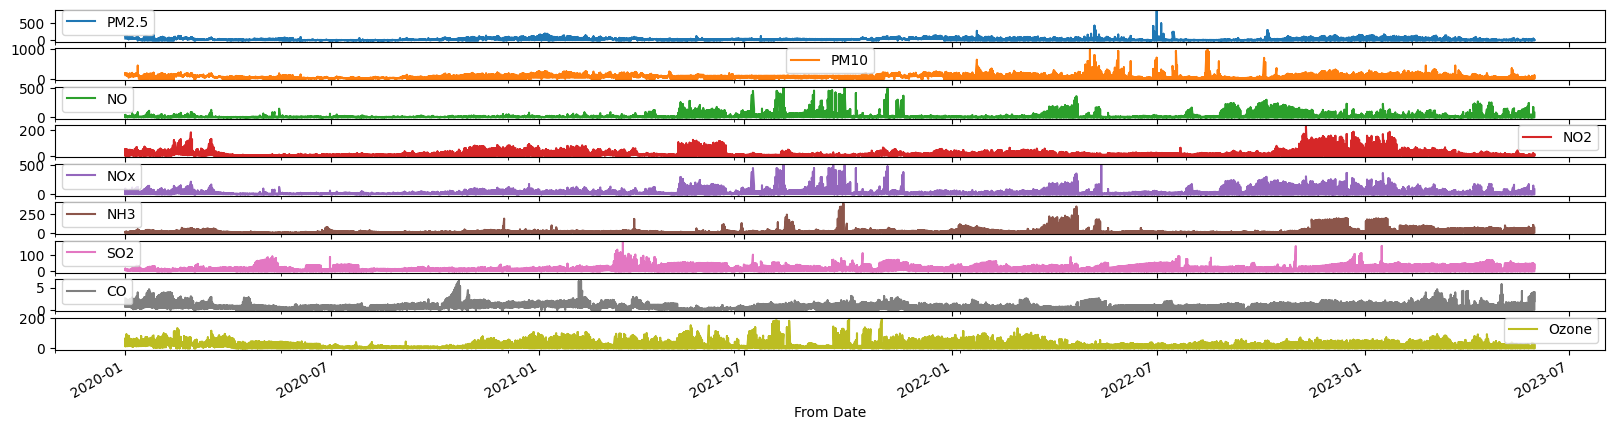

In [13]:
final_df.set_index('From Date')[['PM2.5','PM10','NO','NO2','NOx','NH3','SO2','CO','Ozone']].plot(subplots=True)

In [14]:
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

final_df["PM2.5_SubIndex"] = final_df['PM2.5'].apply(lambda x: get_PM25_subindex(x))

In [15]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

final_df["PM10_SubIndex"] = final_df["PM10"].apply(lambda x: get_PM10_subindex(x))

In [16]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

final_df["SO2_SubIndex"] = final_df["SO2"].apply(lambda x: get_SO2_subindex(x))

In [17]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

final_df["NOx_SubIndex"] = final_df["NOx"].apply(lambda x: get_NOx_subindex(x))

In [18]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

final_df["CO_SubIndex"] = final_df["CO"].apply(lambda x: get_CO_subindex(x))

In [19]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

final_df["Ozone_SubIndex"] = final_df["Ozone"].apply(lambda x: get_O3_subindex(x))

In [20]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

final_df["NH3_SubIndex"] = final_df['NH3'].apply(lambda x: get_NH3_subindex(x))

In [21]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

final_df["Checks"] = (final_df["PM2.5_SubIndex"] > 0).astype(int) + \
                (final_df["PM10_SubIndex"] > 0).astype(int) + \
                (final_df["SO2_SubIndex"] > 0).astype(int) + \
                (final_df["NOx_SubIndex"] > 0).astype(int) + \
                (final_df["CO_SubIndex"] > 0).astype(int) + \
                (final_df["NH3_SubIndex"] > 0).astype(int) + \
                (final_df["Ozone_SubIndex"] > 0).astype(int)

final_df["AQI_calculated"] = round(final_df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                  "CO_SubIndex", "Ozone_SubIndex","NH3_SubIndex"]].max(axis = 1))

# final_df.loc[final_df["PM2.5"] + final_df["PM10"] <= 0, "AQI_calculated"] = np.NaN
# final_df.loc[final_df.Checks < 3, "AQI_calculated"] = np.NaN


final_df["AQI_bucket_calculated"] = final_df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
# final_df[~final_df.AQI_calculated.isna()].head(10)

In [22]:
# final_df.columns.get_loc("TOT-RF")

In [23]:
# final_df.columns.get_loc("PM2.5")

In [24]:
final_df.drop(['AQI_bucket_calculated','Checks','PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex',
       'CO_SubIndex', 'Ozone_SubIndex', 'NH3_SubIndex',],axis=1,inplace=True)

<Axes: >

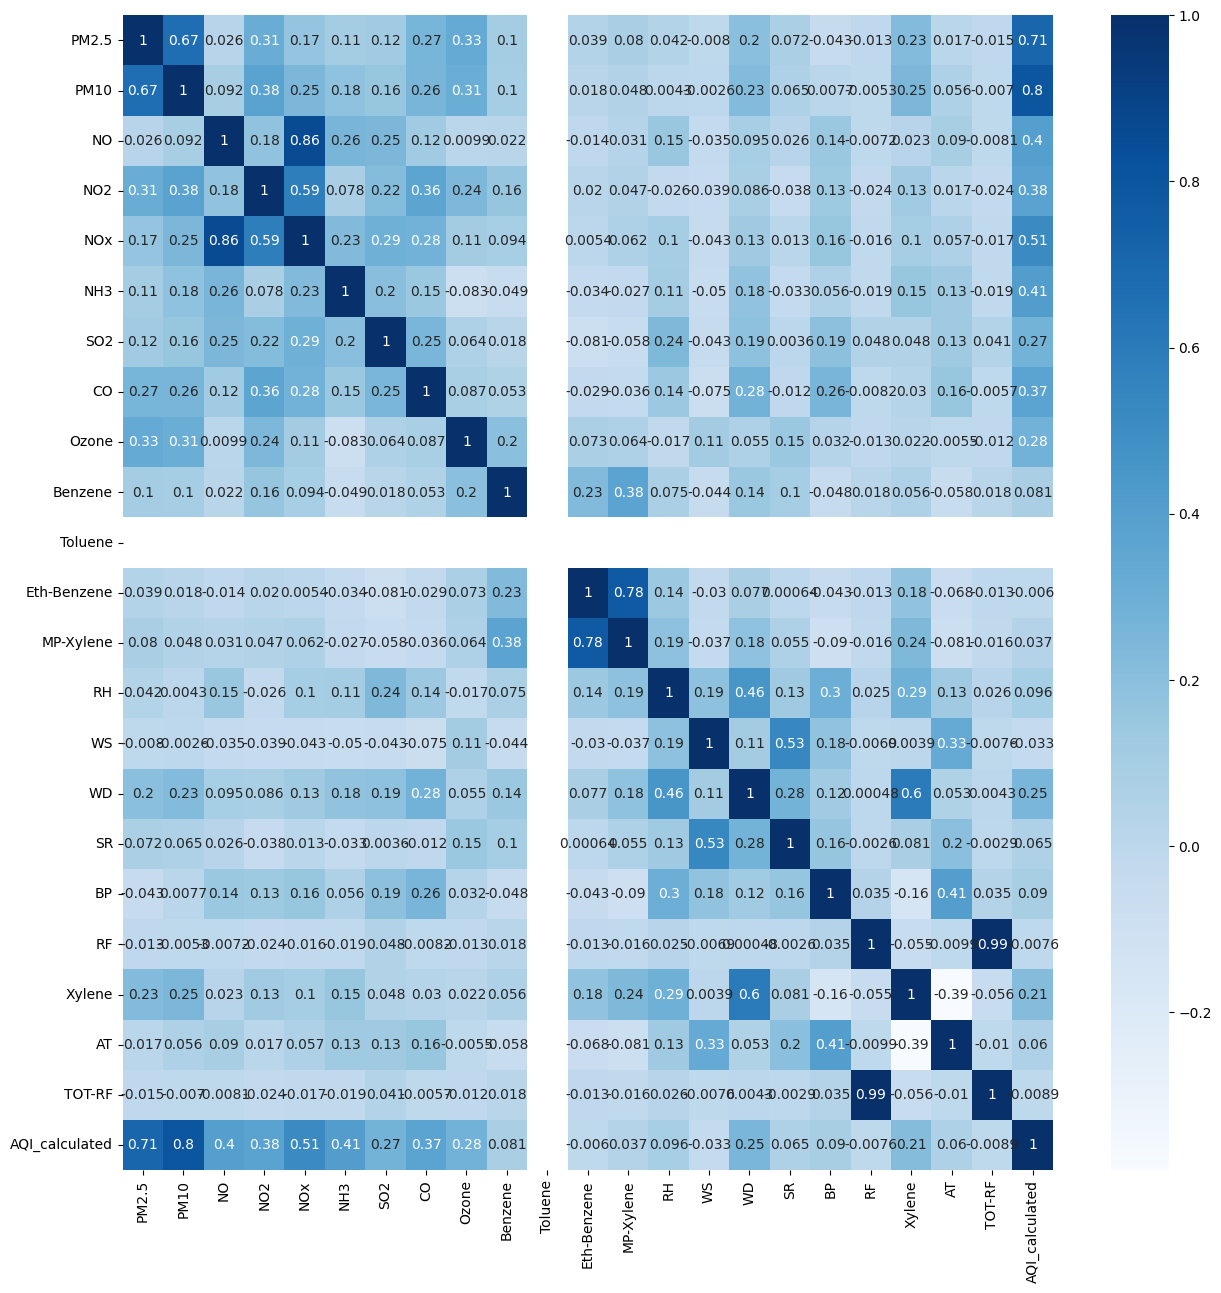

In [25]:
correlation_matrix = final_df.corr()
plt.figure(figsize = (15,15))
# Create a correlation matrix plot
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')

In [26]:
final_df

From Date Station  PM2.5    PM10      NO    NO2     NOx     NH3    SO2  \
0    2020-01-01  bandra  54.66  129.15   33.13  33.83   66.98    0.00  12.36   
1    2020-01-02  bandra  60.25  117.23   17.77  28.03   45.81    0.00  14.10   
2    2020-01-03  bandra  55.67  100.72   21.19  25.70   46.89    0.00  13.20   
3    2020-01-04  bandra  31.42   49.30   16.71  23.64   40.35    0.00   4.21   
4    2020-01-05  bandra  44.59   62.40   25.56  30.41   55.98    0.00   3.90   
...         ...     ...    ...     ...     ...    ...     ...     ...    ...   
7508 2023-05-27   worli  14.80   41.44   40.67   3.22   43.31   27.12  12.48   
7509 2023-05-28   worli  13.71   34.18   48.08   4.37   52.30   37.77  13.70   
7510 2023-05-29   worli  12.57   33.00   27.21   4.92   30.65   22.84  13.68   
7511 2023-05-30   worli  12.52   34.13  116.82   4.68  120.99  105.89  15.60   
7512 2023-05-31   worli  17.99   38.41   78.98   6.43   85.40   68.11  18.25   

        CO  ...     RH    WS      WD      SR       BP   RF  Xylene     AT  \
0     2.55  ...  65.36  0.09  125.67  114.69   769.84  0.0     0.0   0.00   
1     2.38  ...  71.28  0.08  109.09  112.69   771.42  0.0     0.0   0.00   
2     2.22  ...  68.72  0.12  127.71  103.66   770.80  0.0     0.0   0.00   
3     2.03  ...  64.46  0.10  113.06  107.06   769.49  0.0     0.0   0.00   
4     2.43  ...  64.61  0.26  127.22  106.37   768.44  0.0     0.0   0.00   
...    ...  ...    ...   ...     ...     ...      ...  ...     ...    ...   
7508  1.49  ...  74.44  1.22  221.75  263.94  1010.32  0.0     0.0  30.32   
7509  1.50  ...  75.51  0.93  230.95  279.35  1009.22  0.0     0.0  30.45   
7510  1.52  ...  78.54  1.02  228.69  263.70  1008.80  0.0     0.0  30.26   
7511  1.63  ...  78.79  0.97  223.63  304.63  1008.80  0.0     0.0  30.27   
7512  1.95  ...  80.90  0.82  222.21  297.13  1009.08  0.0     0.0  30.24   

      TOT-RF  AQI_calculated  
0        0.0           119.0  
1        0.0           111.0  
2        0.0           103.0  
3        0.0           100.0  
4        0.0           105.0  
...      ...             ...  
7508     0.0            74.0  
7509     0.0            75.0  
7510     0.0            76.0  
7511     0.0           253.0  
7512     0.0           127.0  

[7513 rows x 25 columns]

In [27]:
final_df.columns

Index(['From Date', 'Station', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene',
       'RH', 'WS', 'WD', 'SR', 'BP', 'RF', 'Xylene', 'AT', 'TOT-RF',
       'AQI_calculated'],
      dtype='object')

### Calculate average of aqi and pollutants by each day

In [28]:
# Calculate the AQI for each date by taking the mean of pollutants and AQI based on station
average_data = final_df.groupby('From Date').mean(numeric_only=True).reset_index()
average_data

From Date       PM2.5        PM10         NO        NO2        NOx  \
0    2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1    2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2    2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3    2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4    2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   
...         ...         ...         ...        ...        ...        ...   
1242 2023-05-27   11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28   11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29   11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30   17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31   13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...         RH        WS  \
0      9.065000  10.951667  1.250000  46.341667  ...  59.193333  5.471667   
1      9.871667   8.580000  1.083333  49.901667  ...  62.991667  5.225000   
2      8.805000   8.500000  1.025000  48.735000  ...  60.230000  3.206667   
3      8.966667   6.160000  0.991667  51.958333  ...  58.311667  0.896667   
4     10.610000   7.681667  1.131667  40.641667  ...  57.173333  0.870000   
...         ...        ...       ...        ...  ...        ...       ...   
1242  16.928333  14.145000  1.060000   7.055000  ...  51.265000  6.888333   
1243  18.623333  11.631667  1.100000   3.308333  ...  38.005000  0.523333   
1244  15.638333  14.968333  1.186667   9.376667  ...  52.105000  6.263333   
1245  40.440000  15.790000  1.258333   9.070000  ...  54.390000  6.325000   
1246  26.180000  16.265000  1.328333   7.858333  ...  55.723333  6.251667   

              WD          SR          BP   RF     Xylene         AT  TOT-RF  \
0     158.550000  204.648333  128.306667  0.0  17.606667   0.000000     0.0   
1     157.755000  191.753333  128.570000  0.0  18.563333   0.000000     0.0   
2     156.036667  199.915000  128.466667  0.0  18.231667   0.000000     0.0   
3     162.840000  207.628333  128.248333  0.0  17.521667   0.000000     0.0   
4     155.650000  210.105000  128.073333  0.0  19.158333   0.000000     0.0   
...          ...         ...         ...  ...        ...        ...     ...   
1242  141.565000  304.718333  662.938333  0.0   4.385000  19.743333     0.0   
1243  117.413333   99.475000  494.965000  0.0   4.328333  14.960000     0.0   
1244  131.661667  291.291667  664.411667  0.0   4.105000  20.046667     0.0   
1245  131.673333  290.250000  662.653333  0.0   4.058333  19.593333     0.0   
1246  145.875000  302.013333  667.358333  0.0   4.181667  19.656667     0.0   

      AQI_calculated  
0         219.166667  
1         242.500000  
2         196.666667  
3         189.333333  
4         184.333333  
...              ...  
1242       61.666667  
1243       62.166667  
1244       67.500000  
1245      109.166667  
1246       80.666667  

[1247 rows x 24 columns]

In [29]:
average_data.columns

Index(['From Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'RF', 'Xylene', 'AT', 'TOT-RF', 'AQI_calculated'],
      dtype='object')

In [30]:
average_data[average_data['From Date']== '2020-01-01']

From Date      PM2.5        PM10      NO        NO2        NOx    NH3  \
0 2020-01-01  93.946667  158.266667  25.185  37.113333  62.298333  9.065   

         SO2    CO      Ozone  ...         RH        WS      WD          SR  \
0  10.951667  1.25  46.341667  ...  59.193333  5.471667  158.55  204.648333   

           BP   RF     Xylene   AT  TOT-RF  AQI_calculated  
0  128.306667  0.0  17.606667  0.0     0.0      219.166667  

[1 rows x 24 columns]

In [31]:
final_df = average_data

In [32]:
final_df[['From Date', "AQI_calculated"]].tail()

From Date  AQI_calculated
1242 2023-05-27       61.666667
1243 2023-05-28       62.166667
1244 2023-05-29       67.500000
1245 2023-05-30      109.166667
1246 2023-05-31       80.666667

In [33]:
ddf = final_df[final_df['From Date'] > '2022-12-01']
ddf[['From Date','AQI_calculated']]

From Date  AQI_calculated
1066 2022-12-02      217.500000
1067 2022-12-03      204.333333
1068 2022-12-04      189.166667
1069 2022-12-05      235.666667
1070 2022-12-06      253.333333
...         ...             ...
1242 2023-05-27       61.666667
1243 2023-05-28       62.166667
1244 2023-05-29       67.500000
1245 2023-05-30      109.166667
1246 2023-05-31       80.666667

[181 rows x 2 columns]

### Feature Engineering

In [34]:
final_df[final_df.AQI_calculated.isna()].head()

Empty DataFrame
Columns: [From Date, PM2.5, PM10, NO, NO2, NOx, NH3, SO2, CO, Ozone, Benzene, Toluene, Eth-Benzene, MP-Xylene, RH, WS, WD, SR, BP, RF, Xylene, AT, TOT-RF, AQI_calculated]
Index: []

[0 rows x 24 columns]

In [35]:
final_df['AQI_calculated'] = final_df['AQI_calculated'].fillna(0)

In [36]:
final_df = final_df[final_df.AQI_calculated != 0]

In [37]:
final_df.shape

(1247, 24)

In [38]:
final_df

From Date       PM2.5        PM10         NO        NO2        NOx  \
0    2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1    2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2    2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3    2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4    2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   
...         ...         ...         ...        ...        ...        ...   
1242 2023-05-27   11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28   11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29   11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30   17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31   13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...         RH        WS  \
0      9.065000  10.951667  1.250000  46.341667  ...  59.193333  5.471667   
1      9.871667   8.580000  1.083333  49.901667  ...  62.991667  5.225000   
2      8.805000   8.500000  1.025000  48.735000  ...  60.230000  3.206667   
3      8.966667   6.160000  0.991667  51.958333  ...  58.311667  0.896667   
4     10.610000   7.681667  1.131667  40.641667  ...  57.173333  0.870000   
...         ...        ...       ...        ...  ...        ...       ...   
1242  16.928333  14.145000  1.060000   7.055000  ...  51.265000  6.888333   
1243  18.623333  11.631667  1.100000   3.308333  ...  38.005000  0.523333   
1244  15.638333  14.968333  1.186667   9.376667  ...  52.105000  6.263333   
1245  40.440000  15.790000  1.258333   9.070000  ...  54.390000  6.325000   
1246  26.180000  16.265000  1.328333   7.858333  ...  55.723333  6.251667   

              WD          SR          BP   RF     Xylene         AT  TOT-RF  \
0     158.550000  204.648333  128.306667  0.0  17.606667   0.000000     0.0   
1     157.755000  191.753333  128.570000  0.0  18.563333   0.000000     0.0   
2     156.036667  199.915000  128.466667  0.0  18.231667   0.000000     0.0   
3     162.840000  207.628333  128.248333  0.0  17.521667   0.000000     0.0   
4     155.650000  210.105000  128.073333  0.0  19.158333   0.000000     0.0   
...          ...         ...         ...  ...        ...        ...     ...   
1242  141.565000  304.718333  662.938333  0.0   4.385000  19.743333     0.0   
1243  117.413333   99.475000  494.965000  0.0   4.328333  14.960000     0.0   
1244  131.661667  291.291667  664.411667  0.0   4.105000  20.046667     0.0   
1245  131.673333  290.250000  662.653333  0.0   4.058333  19.593333     0.0   
1246  145.875000  302.013333  667.358333  0.0   4.181667  19.656667     0.0   

      AQI_calculated  
0         219.166667  
1         242.500000  
2         196.666667  
3         189.333333  
4         184.333333  
...              ...  
1242       61.666667  
1243       62.166667  
1244       67.500000  
1245      109.166667  
1246       80.666667  

[1247 rows x 24 columns]

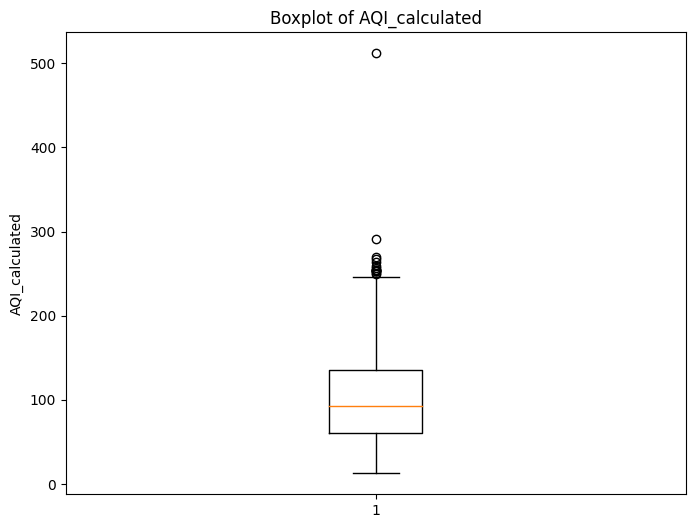

In [39]:
plt.figure(figsize=(8, 6))
plt.boxplot(final_df['AQI_calculated'])
plt.title('Boxplot of AQI_calculated')
plt.ylabel('AQI_calculated')
plt.show()

In [40]:
# print(pywt.wavelist(kind='discrete'))

### CEEMDAN Decomposition

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN

ceemdan = CEEMDAN()

### Aqi Decomposition

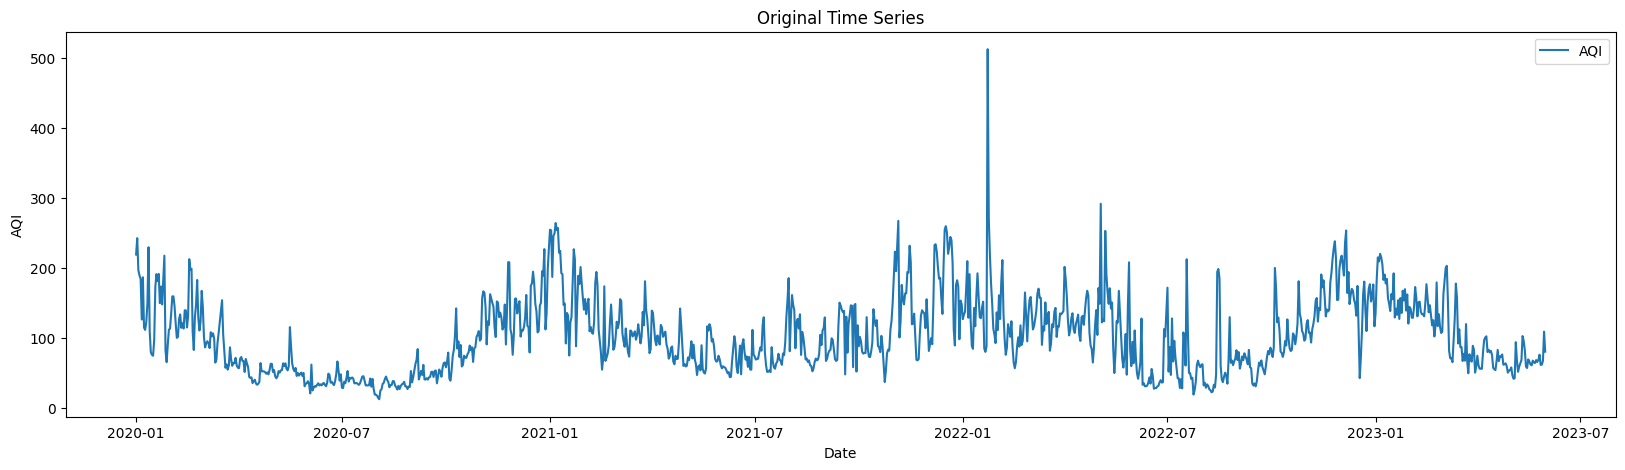

In [42]:
# AQI Plot
aqidata = final_df['AQI_calculated'].values

plt.plot(final_df['From Date'], aqidata, label='AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Original Time Series')
plt.legend()

In [43]:
AQIIMFs = ceemdan(aqidata)

<Figure size 2000x2000 with 0 Axes>

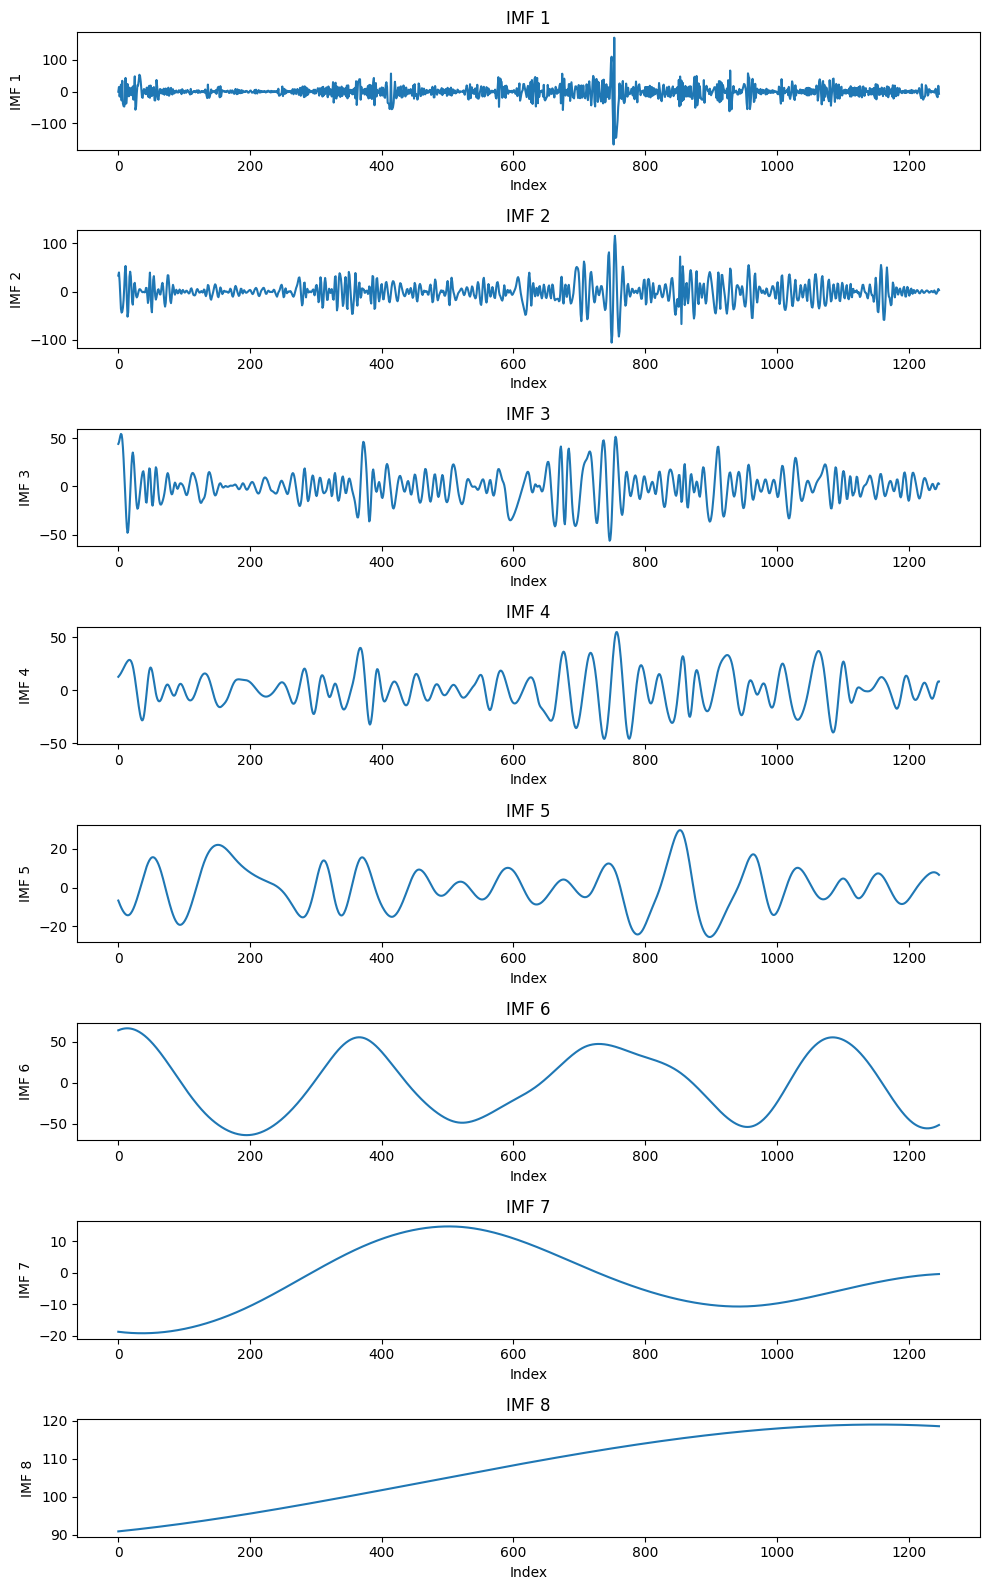

In [44]:
plt.figure(figsize=(20, 20))
num_imfs = AQIIMFs.shape[0]
fig, axs = plt.subplots(nrows=num_imfs, figsize=(10, 2*num_imfs))
plt.subplots_adjust(hspace=0.10)

for i in range(num_imfs):
      final_df['AQIIMF'+str(i+1)] = AQIIMFs[i]

for i in range(num_imfs):
    axs[i].plot(final_df.index, AQIIMFs[i])
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(f'IMF {i+1}')
    axs[i].set_title(f'IMF {i+1}')

plt.tight_layout()

In [45]:
# Check reconstuct values
reconstructed_signal = np.sum(AQIIMFs, axis=0)
reconstructed_signal

array([219.16666667, 242.5       , 196.66666667, ...,  67.5       ,
       109.16666667,  80.66666667])

### PM10 Decomposition

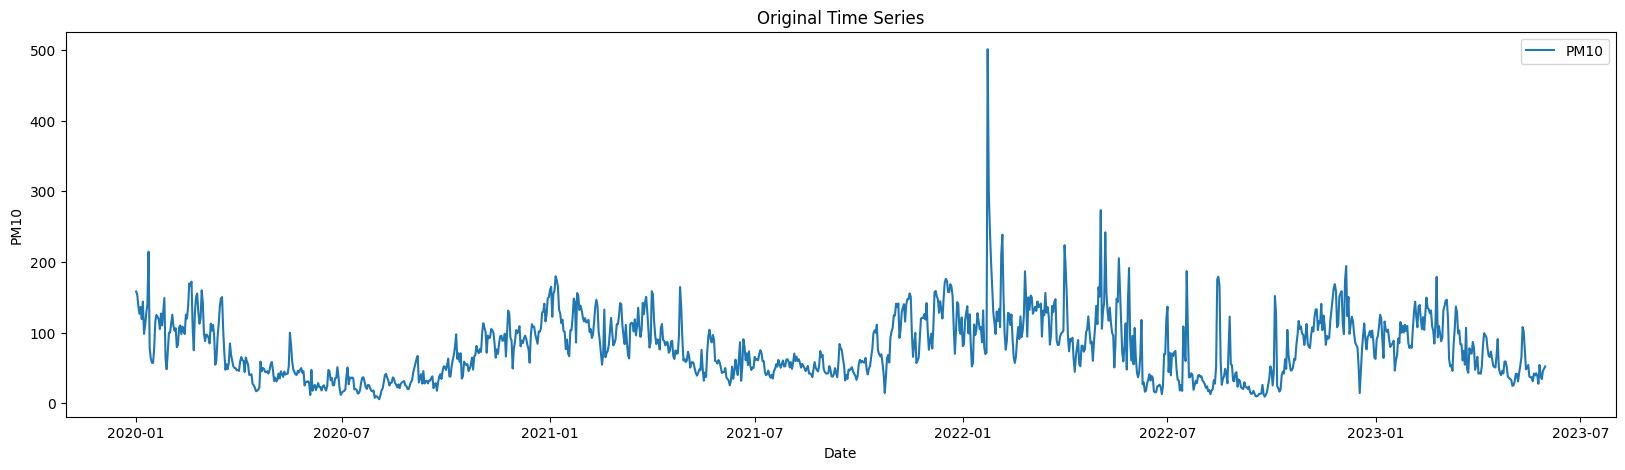

In [46]:
# PM10
pm10data = final_df['PM10'].values

plt.plot(final_df['From Date'], pm10data, label='PM10')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Original Time Series')
plt.legend()

In [47]:
PM10IMFs = ceemdan(pm10data)

<Figure size 2000x2000 with 0 Axes>

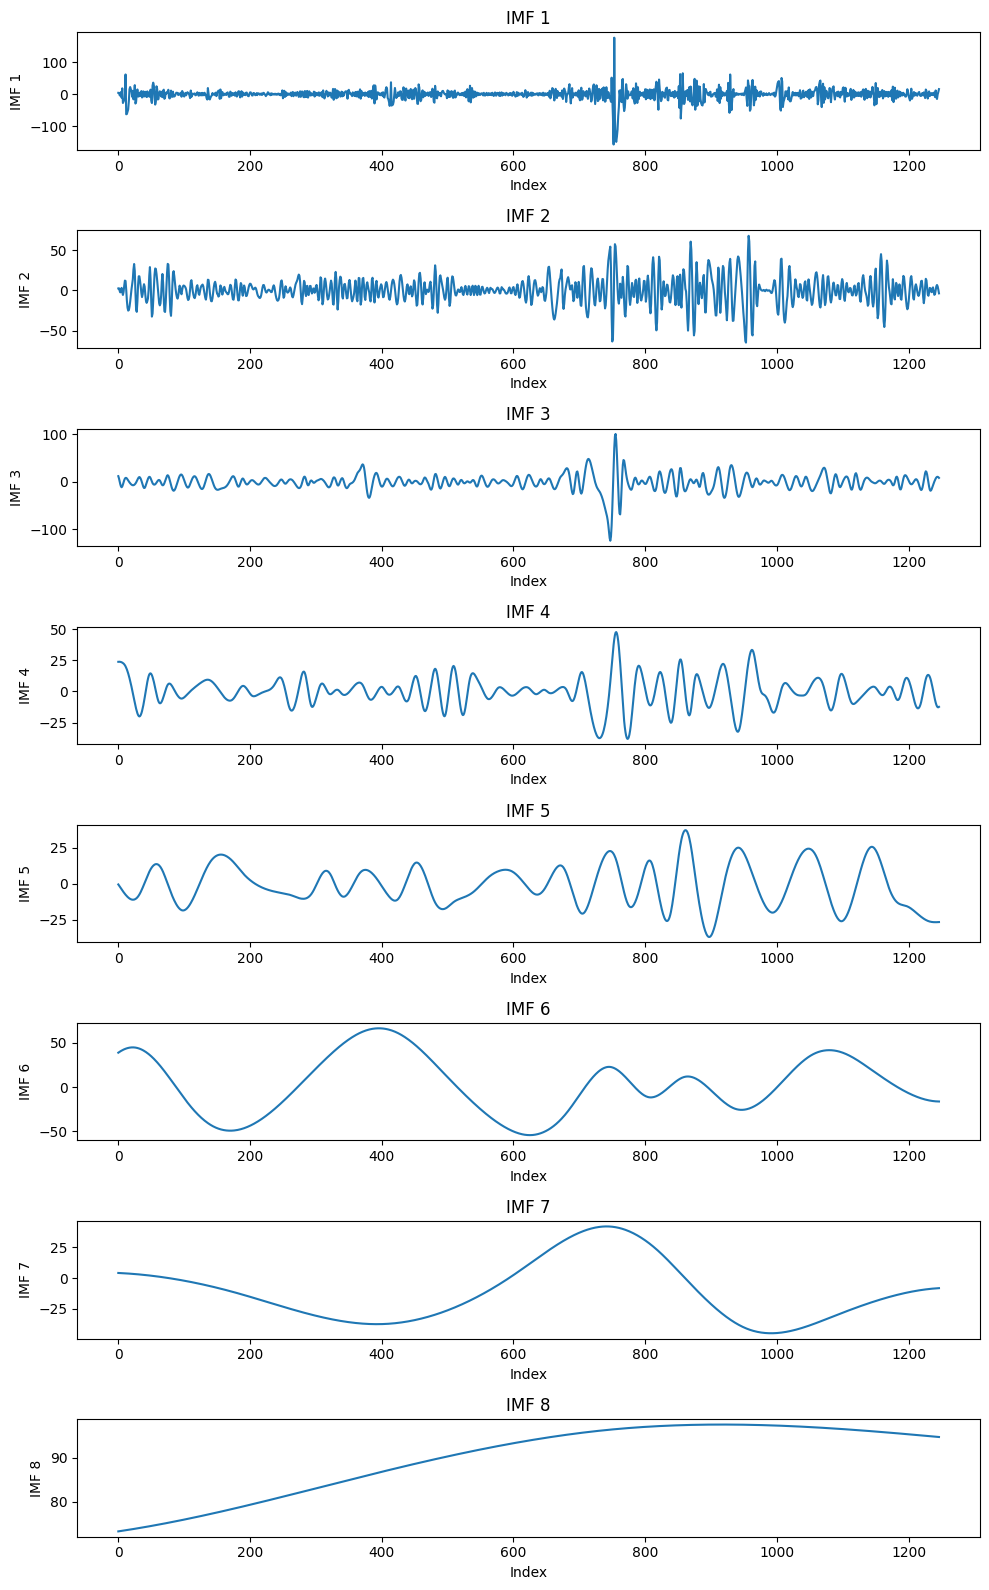

In [48]:
plt.figure(figsize=(20, 20))
num_imfs = PM10IMFs.shape[0]
fig, axs = plt.subplots(nrows=num_imfs, figsize=(10, 2*num_imfs))
plt.subplots_adjust(hspace=0.10)

for i in range(num_imfs):
      final_df['PM10IMF'+str(i+1)] = PM10IMFs[i]

for i in range(num_imfs):
    axs[i].plot(final_df.index, PM10IMFs[i])
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(f'IMF {i+1}')
    axs[i].set_title(f'IMF {i+1}')

plt.tight_layout()

In [49]:
final_df.head()

From Date       PM2.5        PM10         NO        NO2        NOx  \
0 2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1 2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2 2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3 2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4 2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   

         NH3        SO2        CO      Ozone  ...    AQIIMF7    AQIIMF8  \
0   9.065000  10.951667  1.250000  46.341667  ... -18.745876  90.908963   
1   9.871667   8.580000  1.083333  49.901667  ... -18.771295  90.926854   
2   8.805000   8.500000  1.025000  48.735000  ... -18.796020  90.944809   
3   8.966667   6.160000  0.991667  51.958333  ... -18.820051  90.962829   
4  10.610000   7.681667  1.131667  40.641667  ... -18.843383  90.980913   

   PM10IMF1  PM10IMF2   PM10IMF3   PM10IMF4  PM10IMF5   PM10IMF6  PM10IMF7  \
0  4.118730  2.493960  12.225146  23.805730 -0.482543  38.753135  4.162806   
1  4.061838  2.737035   7.569810  23.869616 -1.156886  39.266370  4.136736   
2 -2.918851 -0.465467   1.401498  23.862191 -1.836159  39.758812  4.109951   
3 -4.997214 -2.446476  -4.773188  23.786074 -2.515784  40.230139  4.082446   
4  6.571374  0.712253  -9.372326  23.644890 -3.192194  40.680032  4.054220   

    PM10IMF8  
0  73.189704  
1  73.212147  
2  73.234691  
3  73.257337  
4  73.280085  

[5 rows x 40 columns]

### PM2.5 Decomposition

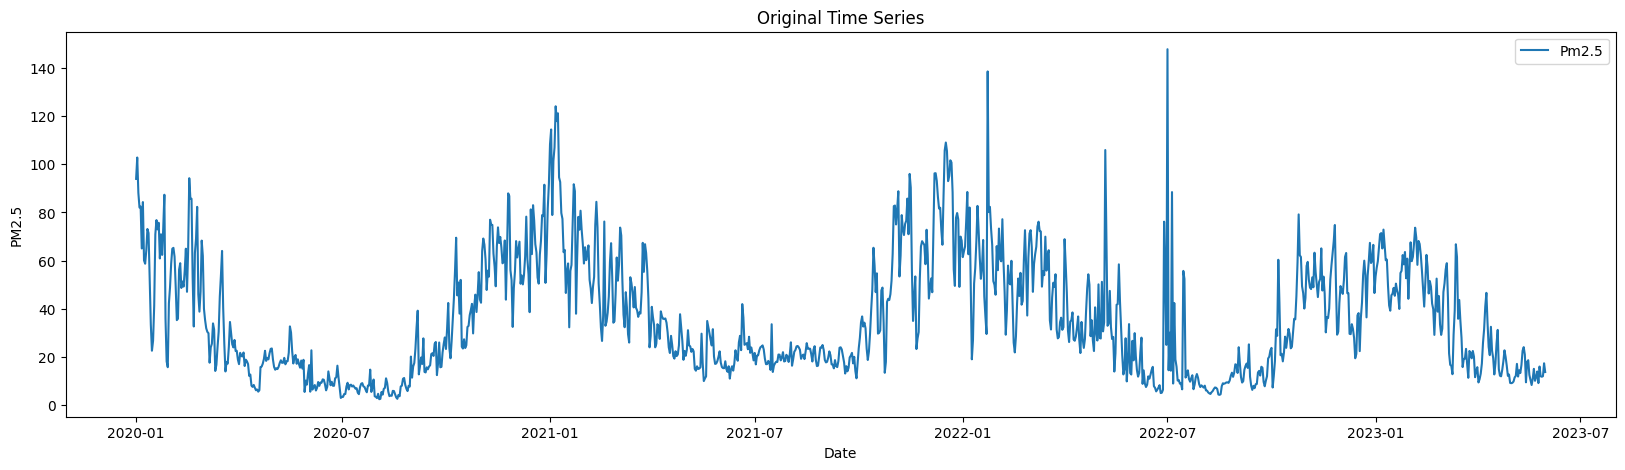

In [50]:
# PM2.5
pm25data = final_df['PM2.5'].values

plt.plot(final_df['From Date'], pm25data, label='Pm2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Original Time Series')
plt.legend()

In [51]:
PM25IMFs = ceemdan(pm25data)

<Figure size 2000x2000 with 0 Axes>

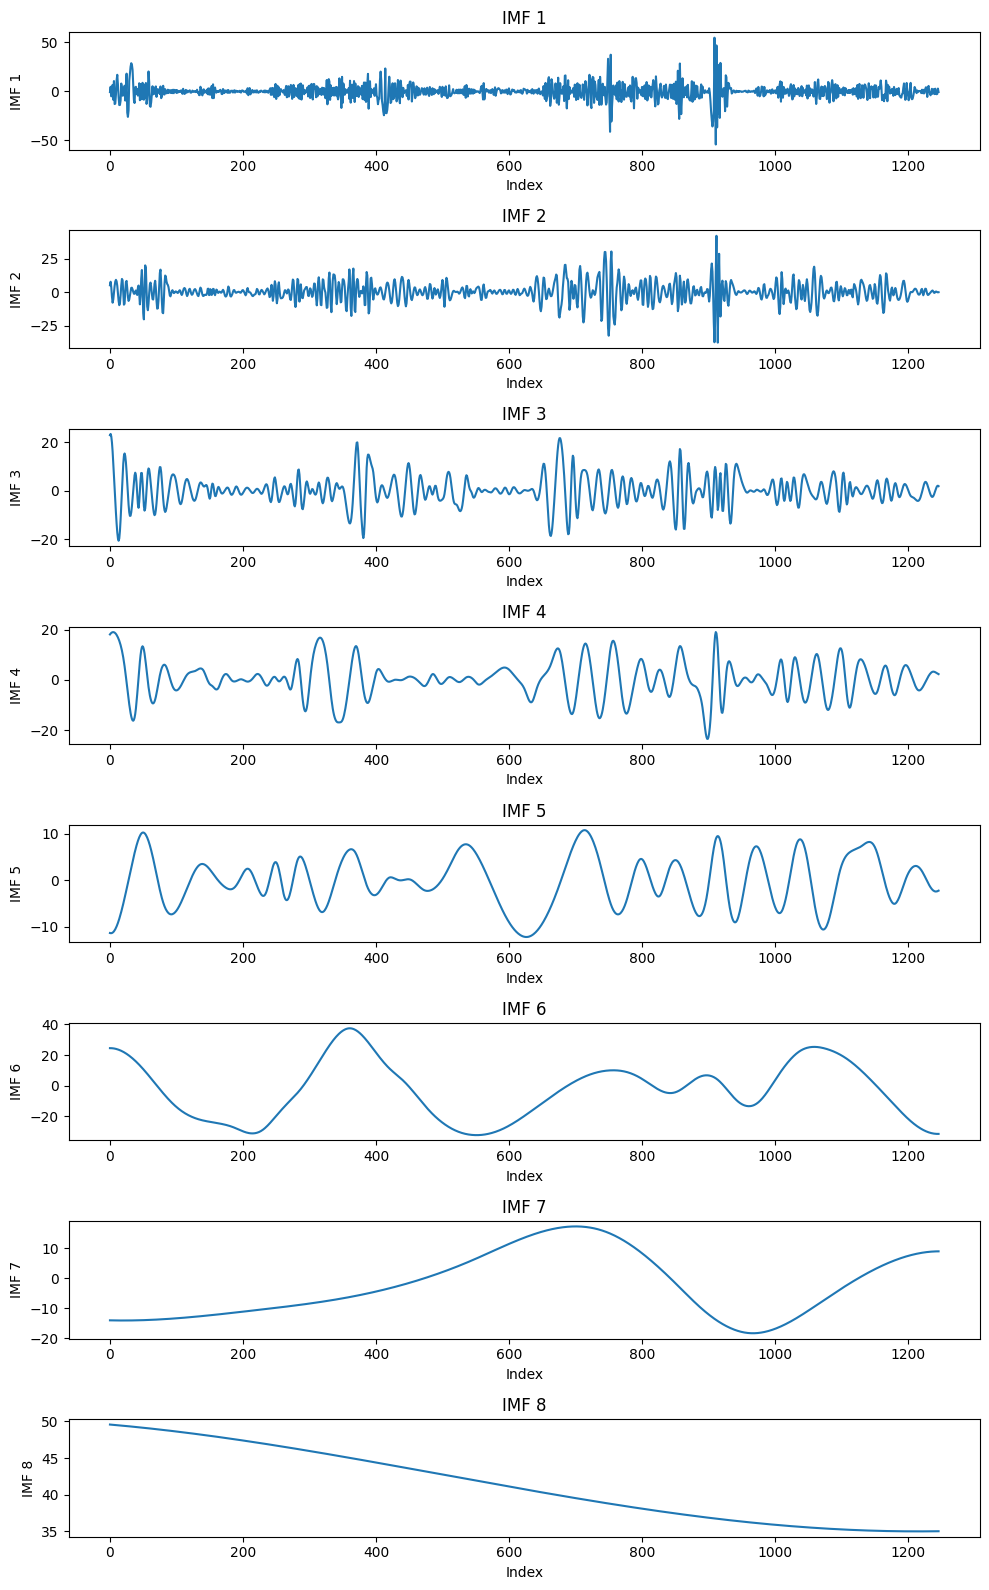

In [52]:
plt.figure(figsize=(20, 20))
num_imfs = PM25IMFs.shape[0]
fig, axs = plt.subplots(nrows=num_imfs, figsize=(10, 2*num_imfs))
plt.subplots_adjust(hspace=0.10)

for i in range(num_imfs):
      final_df['PM2.5IMF'+str(i+1)] = PM25IMFs[i]

for i in range(num_imfs):
    axs[i].plot(final_df.index, PM25IMFs[i])
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(f'IMF {i+1}')
    axs[i].set_title(f'IMF {i+1}')

plt.tight_layout()

In [53]:
final_df.head()

From Date       PM2.5        PM10         NO        NO2        NOx  \
0 2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1 2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2 2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3 2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4 2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   

         NH3        SO2        CO      Ozone  ...  PM10IMF7   PM10IMF8  \
0   9.065000  10.951667  1.250000  46.341667  ...  4.162806  73.189704   
1   9.871667   8.580000  1.083333  49.901667  ...  4.136736  73.212147   
2   8.805000   8.500000  1.025000  48.735000  ...  4.109951  73.234691   
3   8.966667   6.160000  0.991667  51.958333  ...  4.082446  73.257337   
4  10.610000   7.681667  1.131667  40.641667  ...  4.054220  73.280085   

   PM2.5IMF1  PM2.5IMF2  PM2.5IMF3  PM2.5IMF4  PM2.5IMF5  PM2.5IMF6  \
0  -0.669441   5.045525  22.912519  18.046545 -11.367804  24.488122   
1   4.782468   7.671239  23.435217  18.380984 -11.404919  24.487180   
2  -4.960487   3.493023  22.387290  18.642216 -11.404927  24.473168   
3  -1.814750  -3.407904  19.901952  18.827498 -11.366289  24.445965   
4   6.744475  -7.957471  16.182794  18.934619 -11.287562  24.405552   

   PM2.5IMF7  PM2.5IMF8  
0 -14.071900  49.563101  
1 -14.077377  49.555207  
2 -14.082561  49.547279  
3 -14.087455  49.539317  
4 -14.092060  49.531320  

[5 rows x 48 columns]

In [54]:
true_forecast1 = final_df[final_df['From Date'] >= '2023-05-01']
final_df = final_df[final_df['From Date'] < '2023-05-01']
true_forecast1

From Date      PM2.5        PM10         NO        NO2        NOx  \
1216 2023-05-01   8.983333   33.045000   8.591667   7.758333  14.690000   
1217 2023-05-02   9.143333   24.573333   9.625000   6.166667  14.040000   
1218 2023-05-03   9.675000   25.560000  14.483333   4.366667  14.838333   
1219 2023-05-04  11.398333   30.735000  31.041667   4.381667  25.511667   
1220 2023-05-05  12.020000   41.635000  45.018333   6.278333  39.821667   
1221 2023-05-06  17.013333   41.606667  36.621667   5.043333  30.391667   
1222 2023-05-07  11.748333   30.931667  29.910000   4.308333  22.800000   
1223 2023-05-08  14.350000   43.336667  26.238333   4.561667  22.506667   
1224 2023-05-09  13.198333   53.400000   9.643333   5.863333  14.310000   
1225 2023-05-10  16.560000   65.871667  10.241667   5.370000  15.145000   
1226 2023-05-11  22.456667  107.916667  15.273333   5.486667  16.633333   
1227 2023-05-12  23.978333  101.656667  30.156667   7.806667  30.445000   
1228 2023-05-13  20.848333   75.493333  30.861667   4.605000  36.080000   
1229 2023-05-14   9.351667   48.073333  18.415000   3.895000  19.156667   
1230 2023-05-15  17.886667   49.935000  18.656667   8.393333  23.688333   
1231 2023-05-16  18.541667   54.310000  17.770000  10.801667  23.706667   
1232 2023-05-17  12.430000   37.678333  28.561667   6.285000  29.115000   
1233 2023-05-18  10.273333   36.515000  26.160000   5.180000  26.530000   
1234 2023-05-19   8.220000   37.013333  25.726667   5.070000  25.523333   
1235 2023-05-20  10.900000   31.048333  29.175000   4.701667  27.433333   
1236 2023-05-21  14.946667   42.065000  31.325000   4.466667  28.811667   
1237 2023-05-22   9.968333   39.338333  33.315000   4.181667  30.023333   
1238 2023-05-23  11.485000   42.463333  39.830000   3.560000  35.288333   
1239 2023-05-24  13.838333   38.911667  38.041667   3.396667  32.523333   
1240 2023-05-25   9.020000   27.606667  40.421667   3.351667  34.175000   
1241 2023-05-26  15.903333   54.185000  52.623333   5.383333  45.040000   
1242 2023-05-27  11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28  11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29  11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30  17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31  13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...  PM10IMF7   PM10IMF8  \
1216  16.053333  13.165000  0.843333   9.951667  ... -9.934967  95.179529   
1217   5.801667   6.573333  1.268333   7.900000  ... -9.851100  95.166101   
1218   7.338333   6.458333  0.876667   7.093333  ... -9.768865  95.152658   
1219  10.396667   6.705000  0.326667   7.028333  ... -9.688272  95.139200   
1220  35.461667  14.393333  0.396667   8.708333  ... -9.609331  95.125727   
1221  23.651667  19.713333  0.620000   6.766667  ... -9.532052  95.112240   
1222  19.298333  12.255000  0.295000   5.530000  ... -9.456444  95.098738   
1223  18.346667  14.673333  0.575000   6.108333  ... -9.382519  95.085222   
1224  15.240000  14.810000  0.616667   7.115000  ... -9.310286  95.071692   
1225  14.595000  16.291667  0.670000   7.728333  ... -9.239754  95.058149   
1226  16.950000  14.743333  0.711667  10.065000  ... -9.170935  95.044592   
1227  22.061667  15.036667  0.615000  10.433333  ... -9.103838  95.031021   
1228  25.848333  13.431667  0.645000   8.471667  ... -9.038472  95.017438   
1229  18.613333  12.681667  0.626667   8.606667  ... -8.974849  95.003841   
1230  19.635000  15.233333  0.616667  10.955000  ... -8.912977  94.990232   
1231  16.118333  13.958333  0.663333   9.060000  ... -8.852868  94.976610   
1232  20.185000  13.168333  0.645000   6.703333  ... -8.794530  94.962976   
1233  19.683333  13.381667  0.618333   6.898333  ... -8.737975  94.949329   
1234  20.448333  13.811667  0.830000   7.761667  ... -8.683211  94.935671   
1235  21.653333  17.166667  1.223333   7.375000  ... -8.630249  9

In [55]:
df_input = final_df[['From Date','PM2.5', 'PM10','AQI_calculated','AQIIMF1','AQIIMF2','AQIIMF3','AQIIMF4','AQIIMF5','AQIIMF6','AQIIMF7','AQIIMF8','PM10IMF1','PM10IMF2','PM10IMF3','PM10IMF4','PM10IMF5','PM10IMF6','PM10IMF7','PM10IMF8','PM2.5IMF1','PM2.5IMF2','PM2.5IMF3','PM2.5IMF4','PM2.5IMF5','PM2.5IMF6','PM2.5IMF7','PM2.5IMF8']]
df_input.set_index('From Date', inplace = True)

In [56]:
final_df.columns

Index(['From Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'RF', 'Xylene', 'AT', 'TOT-RF', 'AQI_calculated',
       'AQIIMF1', 'AQIIMF2', 'AQIIMF3', 'AQIIMF4', 'AQIIMF5', 'AQIIMF6',
       'AQIIMF7', 'AQIIMF8', 'PM10IMF1', 'PM10IMF2', 'PM10IMF3', 'PM10IMF4',
       'PM10IMF5', 'PM10IMF6', 'PM10IMF7', 'PM10IMF8', 'PM2.5IMF1',
       'PM2.5IMF2', 'PM2.5IMF3', 'PM2.5IMF4', 'PM2.5IMF5', 'PM2.5IMF6',
       'PM2.5IMF7', 'PM2.5IMF8'],
      dtype='object')

In [57]:
df_input

PM2.5        PM10  AQI_calculated    AQIIMF1    AQIIMF2  \
From Date                                                                  
2020-01-01   93.946667  158.266667      219.166667  -0.274513  33.172845   
2020-01-02  102.830000  153.696667      242.500000  14.670706  39.668789   
2020-01-03   88.095000  137.146667      196.666667 -15.427776  20.524200   
2020-01-04   82.038333  126.623333      189.333333   4.071865 -10.064767   
2020-01-05   82.461667  136.378333      184.333333  22.098358 -35.684623   
...                ...         ...             ...        ...        ...   
2023-04-26   19.888333   59.226667       64.000000   4.070682   0.029089   
2023-04-27   16.260000   51.305000       59.666667   0.731117   2.562136   
2023-04-28   12.031667   37.636667       50.666667  -5.760610   3.103951   
2023-04-29   12.581667   35.943333       53.833333   0.965882   1.887715   
2023-04-30    9.091667   34.196667       54.166667   4.903410  -0.491082   

              AQIIMF3    AQIIMF4   AQIIMF5    AQIIMF6    AQIIMF7  ...  \
From Date                                                         ...   
2020-01-01  43.934101  12.733970 -6.649687  64.086863 -18.745876  ...   
2020-01-02  45.648423  13.470157 -7.539139  64.425505 -18.771295  ...   
2020-01-03  48.781893  14.291390 -8.391974  64.740145 -18.796020  ...   
2020-01-04  52.154150  15.202796 -9.203976  65.030487 -18.820051  ...   
2020-01-05  54.247258  16.209502 -9.970929  65.296238 -18.843383  ...   
...               ...        ...       ...        ...        ...  ...   
2023-04-26   2.922002  -8.986787 -0.582052 -51.264435  -1.063478  ...   
2023-04-27  -1.096790  -8.536249 -0.095196 -51.728181  -1.039248  ...   
2023-04-28  -4.990770  -7.751873  0.381992 -52.163700  -1.015396  ...   
2023-04-29  -8.498472  -6.665141  0.849385 -52.571073  -0.991926  ...   
2023-04-30 -11.176513  -5.307531  1.306855 -52.950382  -0.968840  ...   

             PM10IMF7   PM10IMF8  PM2.5IMF1  PM2.5IMF2  PM2.5IMF3  PM2.5IMF4  \
From Date                                                                      
2020-01-01   4.162806  73.189704  -0.669441   5.045525  22.912519  18.046545   
2020-01-02   4.136736  73.212147   4.782468   7.671239  23.435217  18.380984   
2020-01-03   4.109951  73.234691  -4.960487   3.493023  22.387290  18.642216   
2020-01-04   4.082446  73.257337  -1.814750  -3.407904  19.901952  18.827498   
2020-01-05   4.054220  73.280085   6.744475  -7.957471  16.182794  18.934619   
...               ...        ...        ...        ...        ...        ...   
2023-04-26 -10.378430  95.246434   2.795642   2.510640  -3.474852  -2.399756   
2023-04-27 -10.286553  95.233085   0.598608   2.188362  -3.747888  -2.962475   
2023-04-28 -10.196259  95.219719  -1.699260   1.258662  -3.980421  -3.438492   
2023-04-29 -10.107556  95.206338   1.034022  -0.082057  -4.138204  -3.812235   
2023-04-30 -10.020456  95.192941  -0.640843  -1.262081  -4.185424  -4.070393   

            PM2.5IMF5  PM2.5IMF6  PM2.5IMF7  PM2.5IMF8  
From Date                                               
2020-01-01 -11.367804  24.488122 -14.071900  49.563101  
2020-01-02 -11.404919  24.487180 -14.077377  49.555207  
2020-01-03 -11.404927  24.473168 -14.082561  49.547279  
2020-01-04 -11.366289  24.445965 -14.087455  49.539317  
2020-01-05 -11.287562  24.405552 -14.092060  49.531320  
...               ...        ...        ...        ...  
2023-04-26   3.069463 -25.717328   8.096142  35.008382  
2023-04-27   3.071821 -26.041852   8.145203  35.008220  
2023-04-28   3.048630 -26.358546   8.192994  35.008099  
2023-04-29   2.999901 -26.667287   8.239505  35.008020  
2023-04-30   2.925648 -26.967953   8.284731  35.007983  

[1216 rows x 27 columns]

###IMF1

In [58]:
data = df_input[[
       'AQIIMF1',
       'PM10IMF1',
       'PM2.5IMF1']]

In [59]:
test = data.iloc[972:]
train = data.iloc[:972]

In [60]:
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

In [61]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [62]:
win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [63]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF1model = tf.keras.Sequential()
IMF1model.add(SimpleRNN(64, input_shape=(win_length, num_features), return_sequences=True))
IMF1model.add(SimpleRNN(32, return_sequences=False))
#IMF1model.add(SimpleRNN(32, return_sequences=False))
IMF1model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF1model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF1model.fit(train_generator, epochs=50, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF1model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/50
40/40 [==============================] - 12s 77ms/step - loss: 0.0683 - root_mean_squared_error: 0.2614 - mean_absolute_error: 0.1536 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679 - val_mean_absolute_error: 0.0537
Epoch 2/50
40/40 [==============================] - 2s 54ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - mean_absolute_error: 0.0496 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.0419
Epoch 3/50
40/40 [==============================] - 2s 56ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - mean_absolute_error: 0.0463 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_error: 0.0405
Epoch 4/50
40/40 [==============================] - 3s 87ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - mean_absolute_error: 0.0448 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.0390
Epoch 5/50
40/40 [==============================] - 2s 55ms

In [64]:
IMF1model.evaluate(test_generator,verbose=0)

[0.002474250039085746, 0.04974183440208435, 0.03906236216425896]

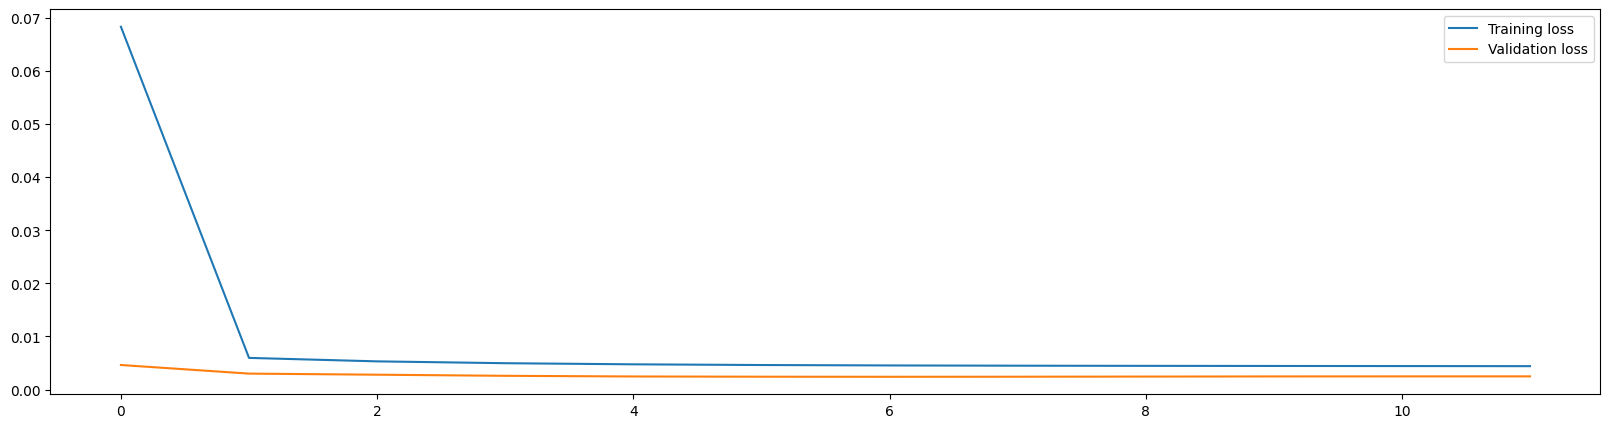

In [65]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [66]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF1model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)


In [69]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.head()


Dates    AQIIMF1  PM10IMF1  PM2.5IMF1
0 2023-05-01  15.331092  2.597473  -1.701272
1 2023-05-02  10.773601  3.519988  -2.099337
2 2023-05-03   9.023029  5.049973  -2.340787
3 2023-05-04   7.688847  5.458530  -2.378087
4 2023-05-05  10.461334  5.146469  -2.675635

####Reconstructing the forecasting data

In [70]:
fin.set_index('Dates', inplace=True)
true_forecast1.set_index('From Date',inplace=True)

In [71]:
forecast_all = pd.DataFrame()
forecast_all = pd.concat([forecast_all,fin[['AQIIMF1','PM2.5IMF1','PM10IMF1']]])
forecast_all

AQIIMF1  PM2.5IMF1  PM10IMF1
Dates                                     
2023-05-01  15.331092  -1.701272  2.597473
2023-05-02  10.773601  -2.099337  3.519988
2023-05-03   9.023029  -2.340787  5.049973
2023-05-04   7.688847  -2.378087  5.458530
2023-05-05  10.461334  -2.675635  5.146469
2023-05-06  13.448442  -2.496794  6.206793
2023-05-07  12.618681  -2.779628  6.625929
2023-05-08  10.791038  -2.716064  7.277983
2023-05-09   9.619827  -2.717536  6.766987
2023-05-10  10.880036  -2.562428  6.913821
2023-05-11  11.603583  -2.716493  6.775189
2023-05-12  11.930793  -2.723338  6.717650
2023-05-13  11.479127  -2.745937  6.824715
2023-05-14  11.124383  -2.708835  6.859155
2023-05-15  11.175267  -2.675807  6.489337
2023-05-16  11.564002  -2.674290  6.517150
2023-05-17  11.403082  -2.690736  6.536931
2023-05-18  11.419051  -2.672597  6.738986
2023-05-19  11.177359  -2.693338  6.832886
2023-05-20  11.196164  -2.671070  6.731874
2023-05-21  11.321083  -2.670369  6.588467
2023-05-22  11.429831  -2.677617  6.607881
2023-05-23  11.375789  -2.679410  6.695690
2023-05-24  11.311871  -2.671048  6.769077
2023-05-25  11.256019  -2.680791  6.739798
2023-05-26  11.322068  -2.683656  6.723662
2023-05-27  11.370499  -2.680050  6.721265
2023-05-28  11.356581  -2.684222  6.692966
2023-05-29  11.362655  -2.686282  6.710657
2023-05-30  11.308010  -2.684859  6.737282
2023-05-31  11.288722  -2.681502  6.729417

####Forecasting Air Quality Index for next 31 days

RMSE =  18.278651412305663
Mean =  -2.4269785718925956
MAPE =  3.986517112721261
R2 Score =  -225.29385114521742


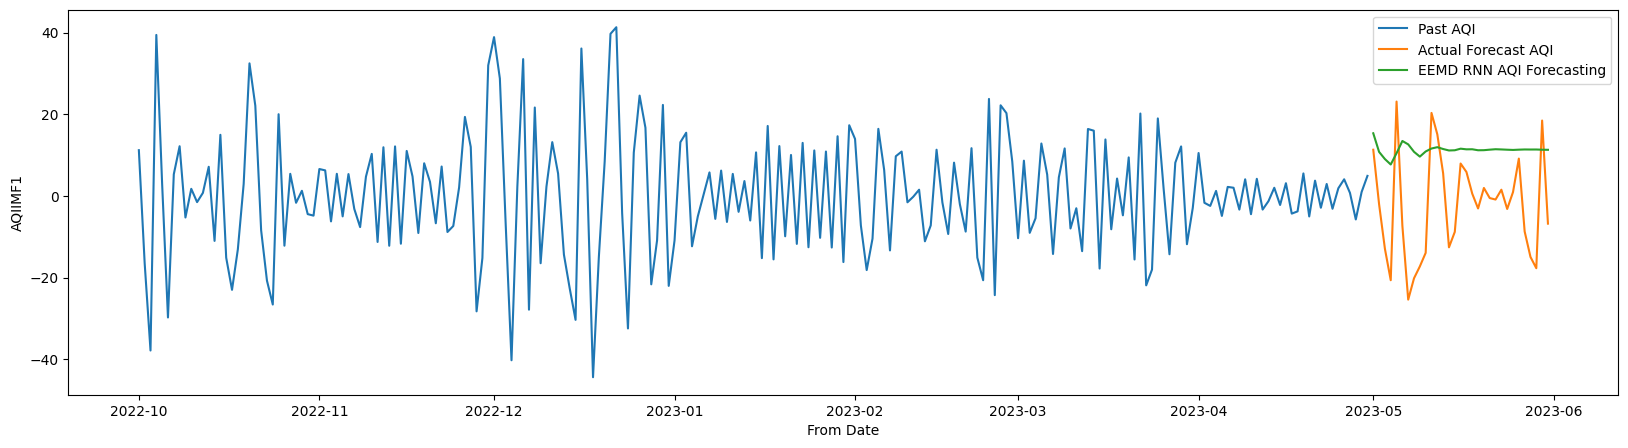

In [72]:
forcastAQI = fin[['AQIIMF1']]
trueAqi = true_forecast1[['AQIIMF1']]

original = final_df[['From Date', 'AQIIMF1']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF1'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF1'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF1'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  3.8044750957582827
Mean =  0.0936199978576524
MAPE =  2.7297130281529904
R2 Score =  -314.9932160676537


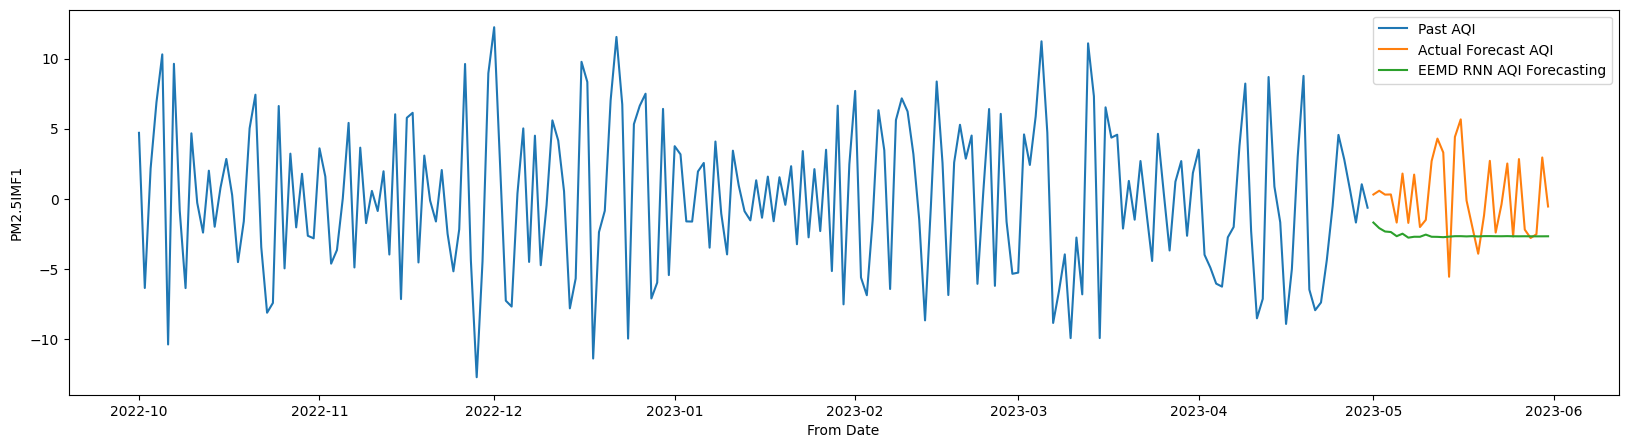

In [73]:
forcastAQI = fin[['PM2.5IMF1']]
trueAqi = true_forecast1[['PM2.5IMF1']]

original = final_df[['From Date', 'PM2.5IMF1']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF1'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF1'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF1'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  9.996150375978429
Mean =  0.051559837186506544
MAPE =  2.077620948285177
R2 Score =  -101.34510957960876


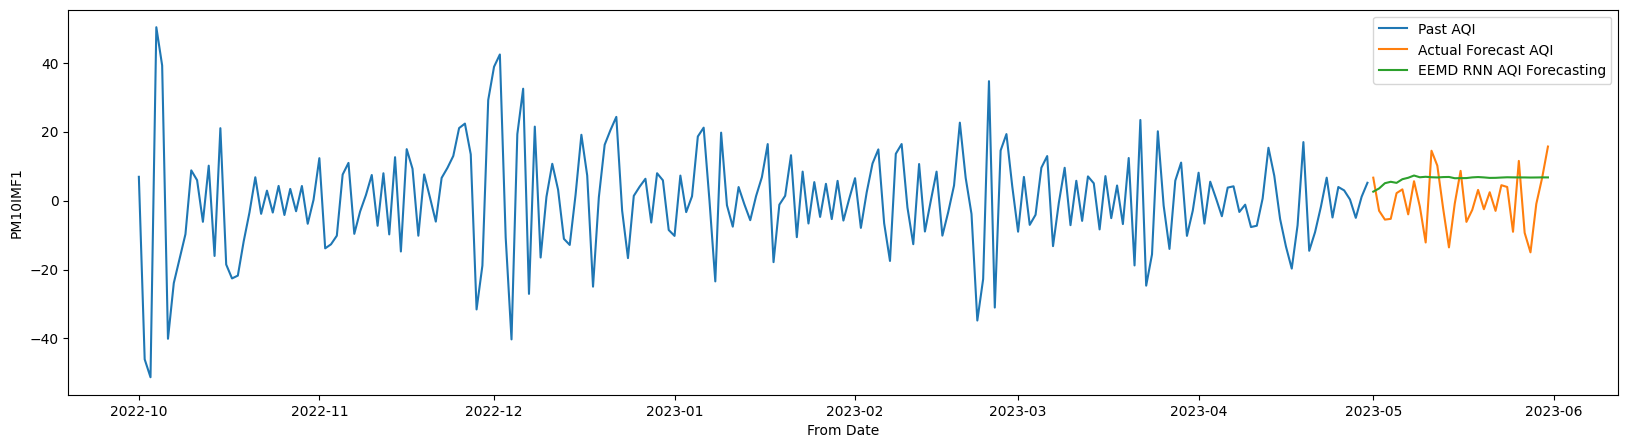

In [74]:
forcastAQI = fin[['PM10IMF1']]
trueAqi = true_forecast1[['PM10IMF1']]

original = final_df[['From Date', 'PM10IMF1']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF1'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF1'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF1'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [75]:
predictions=IMF1model.predict(train_generator)

40/40 [==============================] - 1s 13ms/step


In [76]:
df_pred = pd.DataFrame(predictions)

In [77]:
rev_trans=scaler.inverse_transform(df_pred)

In [78]:
rev_trans.shape

(941, 3)

In [79]:
df_final=train[31:972]
df_final

AQIIMF1   PM10IMF1  PM2.5IMF1
From Date                                  
2020-02-01  34.524526  -7.225760  25.214951
2020-02-02  53.394525   4.712731  28.856731
2020-02-03  49.406271  -5.659468  27.332518
2020-02-04  32.505196  -4.170109  22.002169
2020-02-05   5.353548   9.522432   7.774926
...               ...        ...        ...
2022-08-25  24.730347  23.418282  -0.089938
2022-08-26 -19.747731 -17.484440   0.717388
2022-08-27   7.769565  12.187075   0.775363
2022-08-28   9.429631  -0.742126  -1.638118
2022-08-29   6.025686  -6.029414  -0.019209

[941 rows x 3 columns]

In [80]:
fin.columns

Index(['AQIIMF1', 'PM10IMF1', 'PM2.5IMF1'], dtype='object')

In [81]:
df_final['AQIIMF1_Pred']=rev_trans[:,0]
df_final['PM10IMF1_Pred']=rev_trans[:,1]
df_final['PM2.5IMF1_Pred']=rev_trans[:,2]

Train AQI RMSE =  23.800374685039248
Train AQI MAPE =  6.707636988733441
Train AQI R2 Score =  -10.9994063184461


<Axes: xlabel='From Date'>

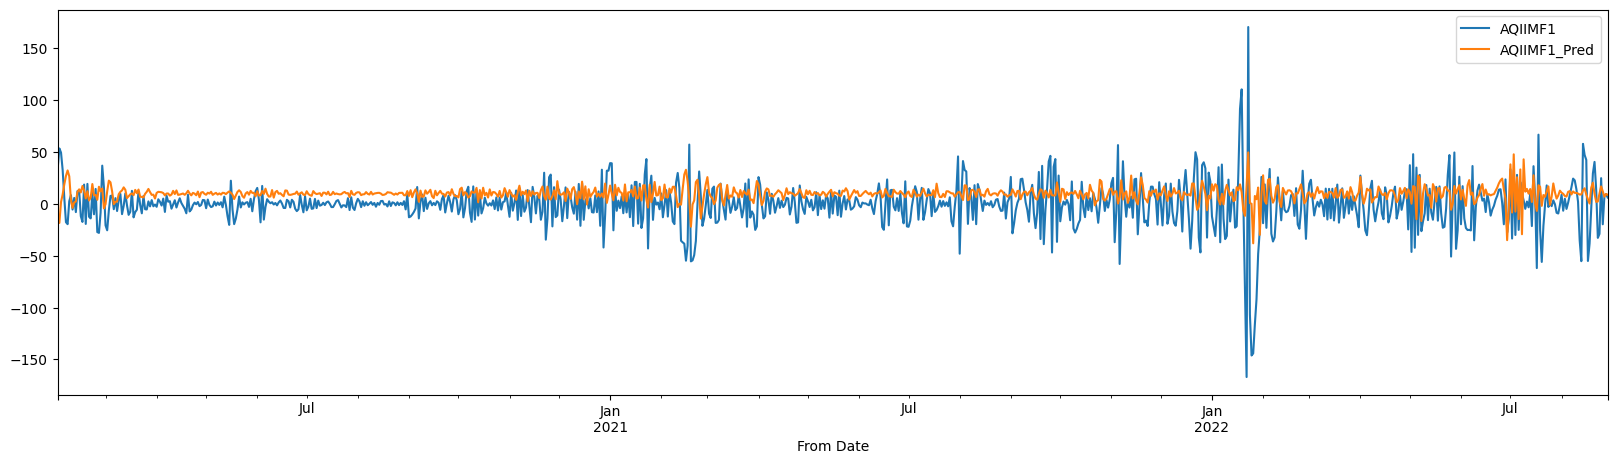

In [83]:
trueAqi= df_final['AQIIMF1']
forcastAQI = df_final['AQIIMF1_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF1','AQIIMF1_Pred']].plot()

####Test Prediction

In [84]:
predictions=IMF1model.predict(test_generator)

9/9 [==============================] - 0s 11ms/step


In [85]:
df_pred = pd.DataFrame(predictions)

In [86]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [87]:
df_final=test

In [88]:
df_final

AQIIMF1  PM10IMF1  PM2.5IMF1
From Date                                
2022-08-30 -3.991866  2.093721   3.088864
2022-08-31  4.525395  6.162631   1.322133
2022-09-01 -6.529929 -7.339558  -4.286681
2022-09-02  8.285641  8.309326   4.636729
2022-09-03 -8.569695  8.122335  -1.620477
...              ...       ...        ...
2023-04-26  4.070682  2.960873   2.795642
2023-04-27  0.731117  0.331034   0.598608
2023-04-28 -5.760610 -5.005827  -1.699260
2023-04-29  0.965882  1.111121   1.034022
2023-04-30  4.903410  5.170679  -0.640843

[244 rows x 3 columns]

In [89]:
AQIIMF1_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF1_Preddata

AQIIMF1   PM10IMF1  PM2.5IMF1
From Date                                  
2022-09-30  15.981450  40.627703   0.353673
2022-10-01  11.193473   6.904384   4.705893
2022-10-02 -16.508144 -46.061146  -6.374392
2022-10-03 -37.839791 -51.263621   2.168253
2022-10-04  39.407404  50.319820   6.878752
...               ...        ...        ...
2023-04-26   4.070682   2.960873   2.795642
2023-04-27   0.731117   0.331034   0.598608
2023-04-28  -5.760610  -5.005827  -1.699260
2023-04-29   0.965882   1.111121   1.034022
2023-04-30   4.903410   5.170679  -0.640843

[213 rows x 3 columns]

In [90]:
AQIIMF1_Preddata['AQIIMF1_Pred']=rev_trans[:,0]
AQIIMF1_Preddata['PM10IMF1_Pred']=rev_trans[:,1]
AQIIMF1_Preddata['PM2.5IMF1_Pred']=rev_trans[:,2]

In [91]:
all_imf = pd.DataFrame()
all_imf=pd.concat([all_imf,AQIIMF1_Preddata],axis=1)

In [92]:
all_imf

AQIIMF1   PM10IMF1  PM2.5IMF1  AQIIMF1_Pred  PM10IMF1_Pred  \
From Date                                                                  
2022-09-30  15.981450  40.627703   0.353673      8.600426       3.536311   
2022-10-01  11.193473   6.904384   4.705893      9.131074       5.627542   
2022-10-02 -16.508144 -46.061146  -6.374392      7.867144       1.720989   
2022-10-03 -37.839791 -51.263621   2.168253     15.162529       7.455275   
2022-10-04  39.407404  50.319820   6.878752     11.958730      10.405181   
...               ...        ...        ...           ...            ...   
2023-04-26   4.070682   2.960873   2.795642      4.950249      -0.729897   
2023-04-27   0.731117   0.331034   0.598608      5.688117       3.718645   
2023-04-28  -5.760610  -5.005827  -1.699260      6.443743       4.385101   
2023-04-29   0.965882   1.111121   1.034022     12.241109       5.659030   
2023-04-30   4.903410   5.170679  -0.640843     14.145964       2.205587   

            PM2.5IMF1_Pred  
From Date                   
2022-09-30       -2.779131  
2022-10-01       -3.096829  
2022-10-02       -3.421534  
2022-10-03       -2.478152  
2022-10-04        0.067915  
...                    ...  
2023-04-26       -3.385433  
2023-04-27       -2.795671  
2023-04-28       -1.391892  
2023-04-29       -0.959977  
2023-04-30       -1.593881  

[213 rows x 6 columns]

Test AQI RMSE =  17.635151031211073
Test AQI MAPE =  2.0992049357582427
Test AQI R2 Score =  -17.34952798995751


<Axes: xlabel='From Date'>

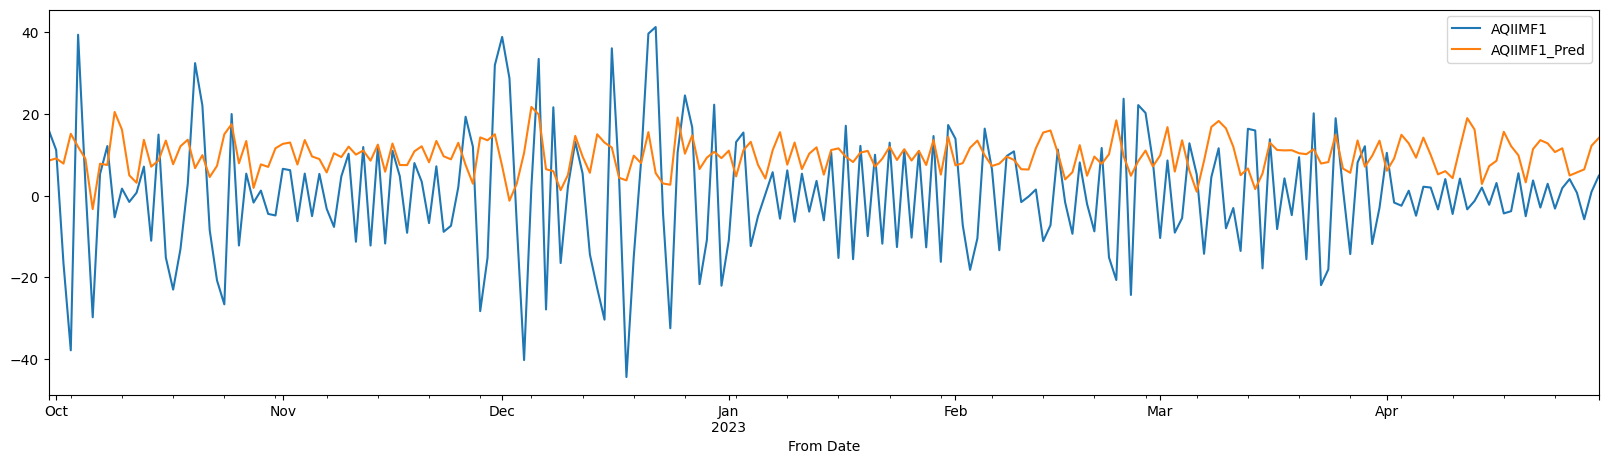

In [326]:
trueAqi= AQIIMF1_Preddata['AQIIMF1']
forcastAQI = AQIIMF1_Preddata['AQIIMF1_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',test_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF1_Preddata[['AQIIMF1','AQIIMF1_Pred']].plot()

###IMF2

In [94]:
data = df_input[[
       'AQIIMF2',
       'PM10IMF2',
        'PM2.5IMF2']]

In [95]:
test = data.iloc[972:]
train = data.iloc[:972]

In [96]:
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

In [97]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [98]:
win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [99]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF2model = tf.keras.Sequential()
IMF2model.add(SimpleRNN(128, input_shape=(win_length, num_features), return_sequences=True))
IMF2model.add(SimpleRNN(64, return_sequences=True))
IMF2model.add(SimpleRNN(32, return_sequences=False))
IMF2model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF2model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF2model.fit(train_generator, epochs=75, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF2model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/75
40/40 [==============================] - 7s 94ms/step - loss: 0.1339 - root_mean_squared_error: 0.3659 - mean_absolute_error: 0.1922 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040 - val_mean_absolute_error: 0.0803
Epoch 2/75
40/40 [==============================] - 5s 131ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - mean_absolute_error: 0.0746 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931 - val_mean_absolute_error: 0.0712
Epoch 3/75
40/40 [==============================] - 7s 188ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - mean_absolute_error: 0.0690 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882 - val_mean_absolute_error: 0.0675
Epoch 4/75
40/40 [==============================] - 7s 168ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - mean_absolute_error: 0.0657 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817 - val_mean_absolute_error: 0.0626
Epoch 5/75
40/40 [==============================] - 8s 20

In [100]:
IMF2model.evaluate(test_generator,verbose=0)

[0.002458385657519102, 0.0495821088552475, 0.04020673781633377]

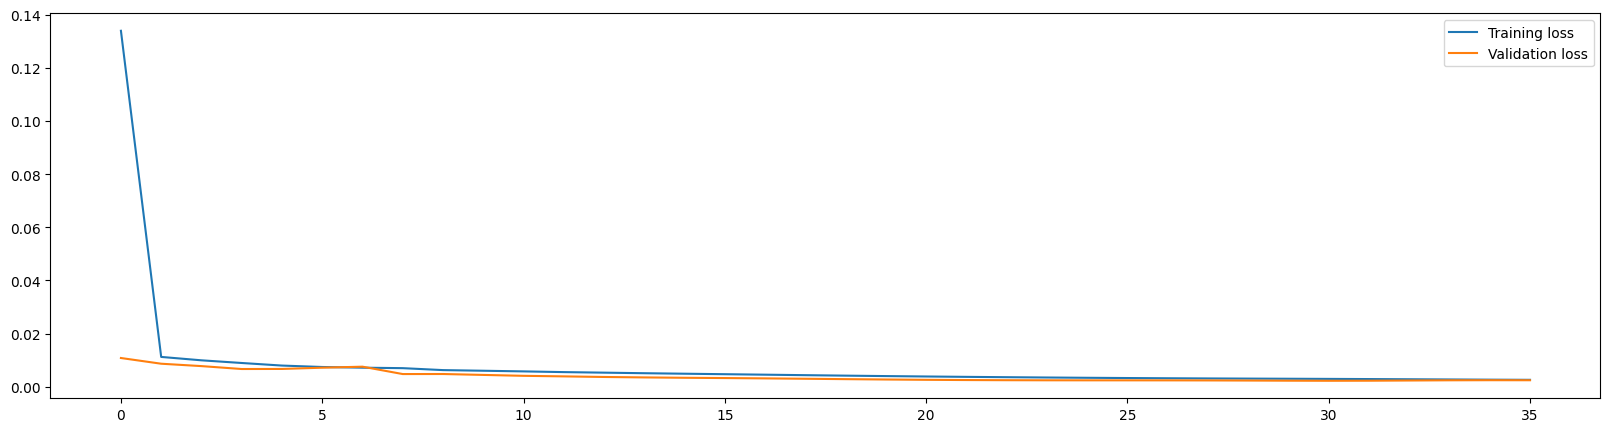

In [101]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [102]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF2model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [103]:
true_predictions = scaler.inverse_transform(test_predictions)

In [104]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)


In [105]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()


AQIIMF2   PM10IMF2  PM2.5IMF2
Dates                                      
2023-05-01 -17.991768  -3.851210  -3.039463
2023-05-02 -26.641486   0.668567  -2.280767
2023-05-03 -25.676779   8.345424   0.305844
2023-05-04 -16.319141  15.811217   3.907636
2023-05-05  -7.565548  19.407213   5.229404

In [106]:
fin.columns

Index(['AQIIMF2', 'PM10IMF2', 'PM2.5IMF2'], dtype='object')

####Reconstructing the forecasting data

In [107]:
forecast_all1 = pd.concat([forecast_all,fin[['AQIIMF2','PM2.5IMF2','PM10IMF2']]],axis=1)

####Forecasting Air Quality Index for next 31 days

RMSE =  15.524243705250779
Mean =  -0.1479431919700687
MAPE =  14.547835249050893
R2 Score =  -5.789652671334505


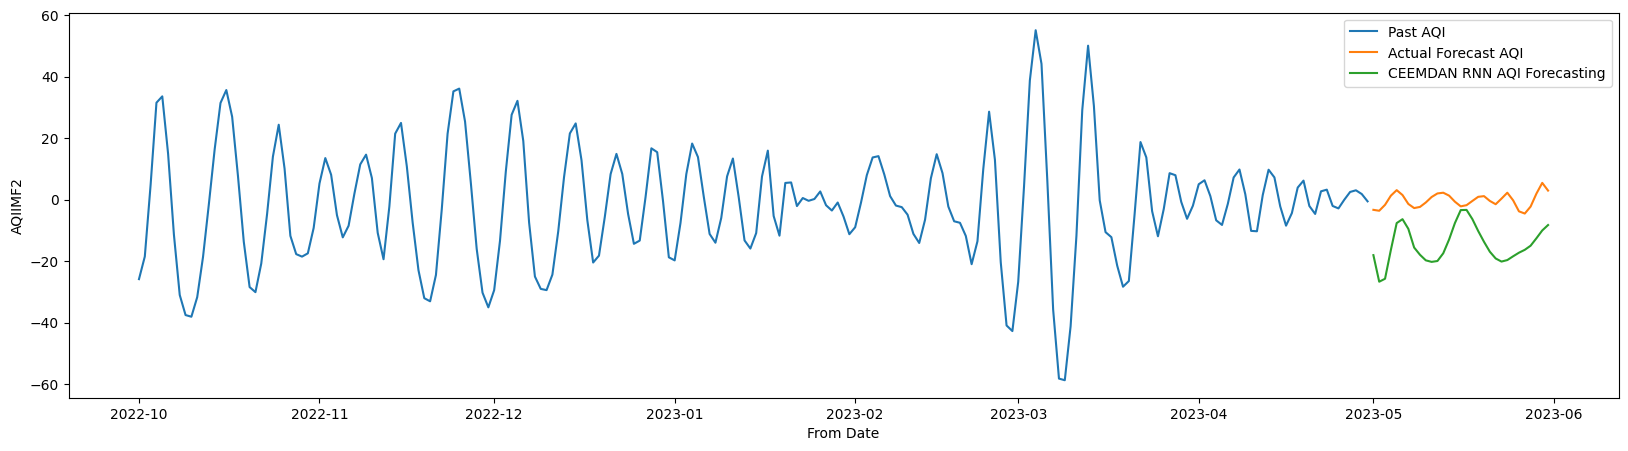

In [108]:
forcastAQI = fin[['AQIIMF2']]
trueAqi = true_forecast1[['AQIIMF2']]

original = final_df[['From Date', 'AQIIMF2']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF2'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF2'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF2'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  2.7245668624474018
Mean =  -0.14971882222166447
MAPE =  4.376814577524991
R2 Score =  -0.6890818058953494


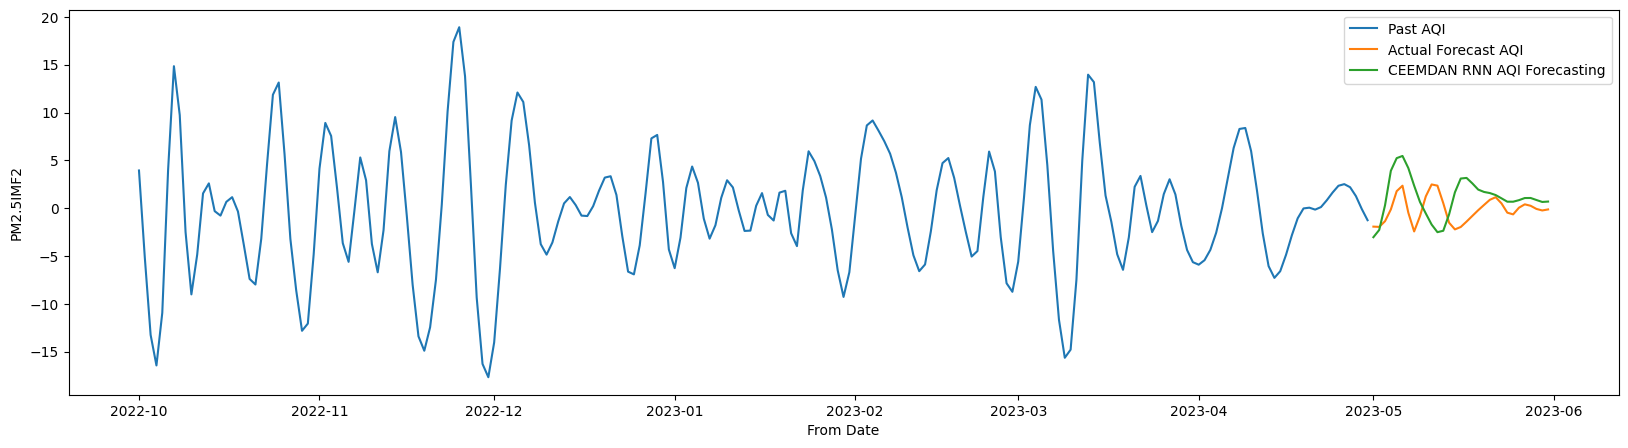

In [109]:
forcastAQI = fin[['PM2.5IMF2']]
trueAqi = true_forecast1[['PM2.5IMF2']]

original = final_df[['From Date', 'PM2.5IMF2']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF2'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF2'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF2'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  9.121141497827072
Mean =  0.9444734516346682
MAPE =  1.7792383570538537
R2 Score =  -1.6666719463793123


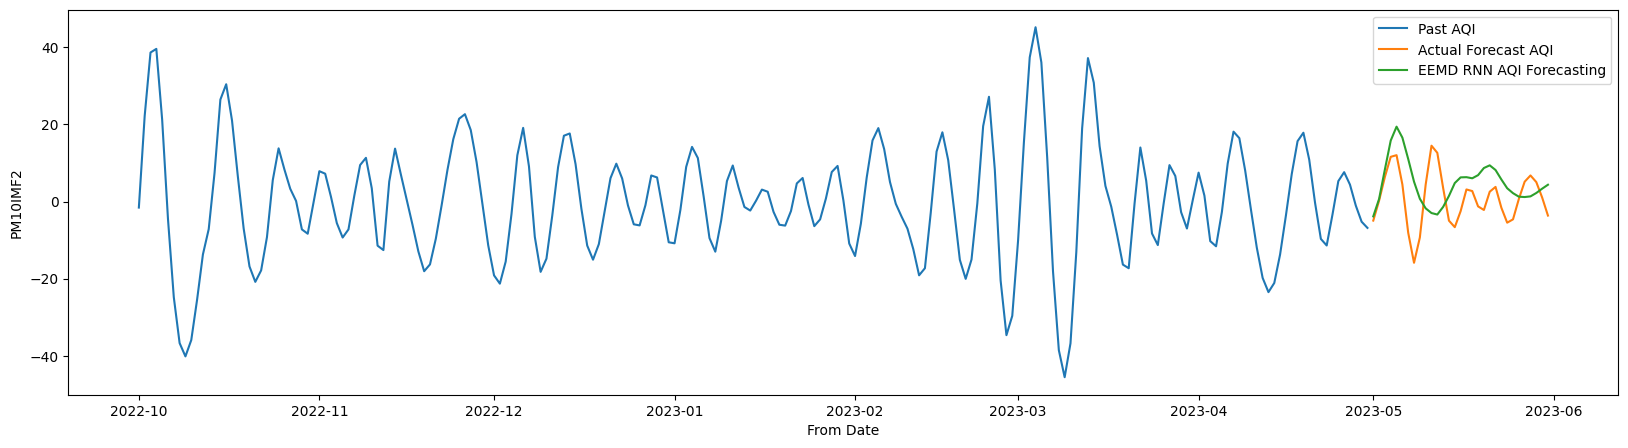

In [110]:
forcastAQI = fin[['PM10IMF2']]
trueAqi = true_forecast1[['PM10IMF2']]

original = final_df[['From Date', 'PM10IMF2']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF2'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF2'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF2'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [111]:
predictions=IMF2model.predict(train_generator)

40/40 [==============================] - 1s 10ms/step


In [112]:
df_pred = pd.DataFrame(predictions)

In [113]:
rev_trans=scaler.inverse_transform(df_pred)

In [114]:
rev_trans.shape

(941, 3)

In [115]:
df_final=data[31:972]
df_final

AQIIMF2   PM10IMF2  PM2.5IMF2
From Date                                  
2020-02-01   1.510607  17.607584   0.897188
2020-02-02   4.907407  17.573843   3.102060
2020-02-03   4.989615  12.014852   3.219566
2020-02-04   3.441996   4.997538   1.966286
2020-02-05   1.326839  -3.225100   0.139687
...               ...        ...        ...
2022-08-25  37.421274  36.163236  -0.221279
2022-08-26  13.696243  11.046150   0.267072
2022-08-27 -13.204645 -16.252645   0.556146
2022-08-28 -22.458929 -19.632139   0.162902
2022-08-29 -12.258492  -7.897382  -0.868462

[941 rows x 3 columns]

In [116]:
df_final['AQIIMF2_Pred']=rev_trans[:,0]
df_final['PM10IMF2_Pred']=rev_trans[:,1]
df_final['PM2.5IMF2_Pred']=rev_trans[:,2]

Train AQI RMSE =  14.705545112924383
Train AQI MAPE =  8.557721071463149
Train AQI R2 Score =  0.33807017233169623


<Axes: xlabel='From Date'>

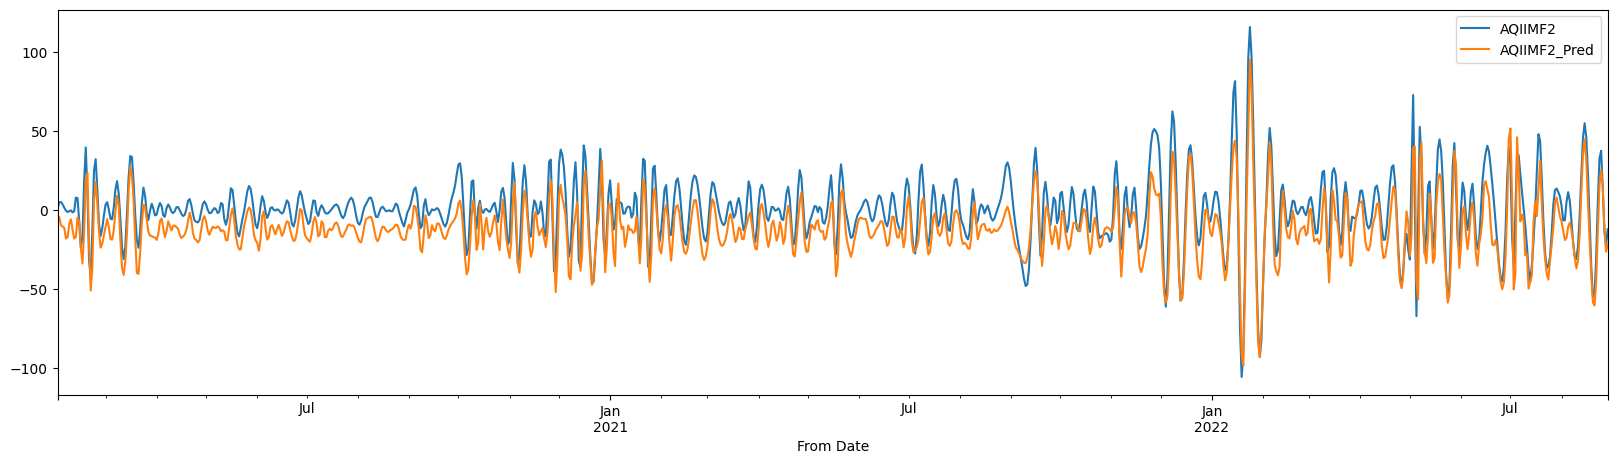

In [117]:
trueAqi= df_final['AQIIMF2']
forcastAQI = df_final['AQIIMF2_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF2','AQIIMF2_Pred']].plot()

####Test Prediction

In [118]:
predictions=IMF2model.predict(test_generator)

9/9 [==============================] - 0s 21ms/step


In [119]:
df_pred = pd.DataFrame(predictions)

In [120]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [121]:
df_final=test

In [122]:
AQIIMF2_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF2_Preddata

AQIIMF2   PM10IMF2  PM2.5IMF2
From Date                                  
2022-09-30 -14.818226 -21.954032   9.889181
2022-10-01 -25.802259  -1.569926   3.939082
2022-10-02 -18.452414  22.177319  -5.160687
2022-10-03   4.939370  38.633960 -13.258948
2022-10-04  31.601141  39.573663 -16.449661
...               ...        ...        ...
2023-04-26   0.029089   7.610057   2.510640
2023-04-27   2.562136   4.375223   2.188362
2023-04-28   3.103951  -1.050396   1.258662
2023-04-29   1.887715  -5.237877  -0.082057
2023-04-30  -0.491082  -6.836261  -1.262081

[213 rows x 3 columns]

In [123]:
AQIIMF2_Preddata['AQIIMF2_Pred']=rev_trans[:,0]
AQIIMF2_Preddata['PM10IMF2_Pred']=rev_trans[:,1]
AQIIMF2_Preddata['PM2.5IMF2_Pred']=rev_trans[:,2]

In [124]:
all_imf=pd.concat([all_imf,AQIIMF2_Preddata],axis=1)

In [125]:
AQIIMF2_Preddata

AQIIMF2   PM10IMF2  PM2.5IMF2  AQIIMF2_Pred  PM10IMF2_Pred  \
From Date                                                                  
2022-09-30 -14.818226 -21.954032   9.889181     -8.500426     -13.784392   
2022-10-01 -25.802259  -1.569926   3.939082    -24.085312      -3.668083   
2022-10-02 -18.452414  22.177319  -5.160687    -26.705564      15.331996   
2022-10-03   4.939370  38.633960 -13.258948    -15.309946      31.218079   
2022-10-04  31.601141  39.573663 -16.449661     -0.159091      35.058487   
...               ...        ...        ...           ...            ...   
2023-04-26   0.029089   7.610057   2.510640    -11.443305      11.156098   
2023-04-27   2.562136   4.375223   2.188362    -13.376942       7.392290   
2023-04-28   3.103951  -1.050396   1.258662    -14.598741      -0.333238   
2023-04-29   1.887715  -5.237877  -0.082057    -13.660345      -5.400626   
2023-04-30  -0.491082  -6.836261  -1.262081    -15.352687      -6.075586   

            PM2.5IMF2_Pred  
From Date                   
2022-09-30        5.369028  
2022-10-01        2.647082  
2022-10-02       -0.342934  
2022-10-03       -3.390155  
2022-10-04       -5.911895  
...                    ...  
2023-04-26        1.615222  
2023-04-27       -0.182188  
2023-04-28       -0.620548  
2023-04-29       -0.771485  
2023-04-30       -2.459266  

[213 rows x 6 columns]

Test AQI RMSE =  14.705545112924383
Test AQI MAPE =  4.7099268802753
Test AQI R2 Score =  0.3805226822530382


<Axes: xlabel='From Date'>

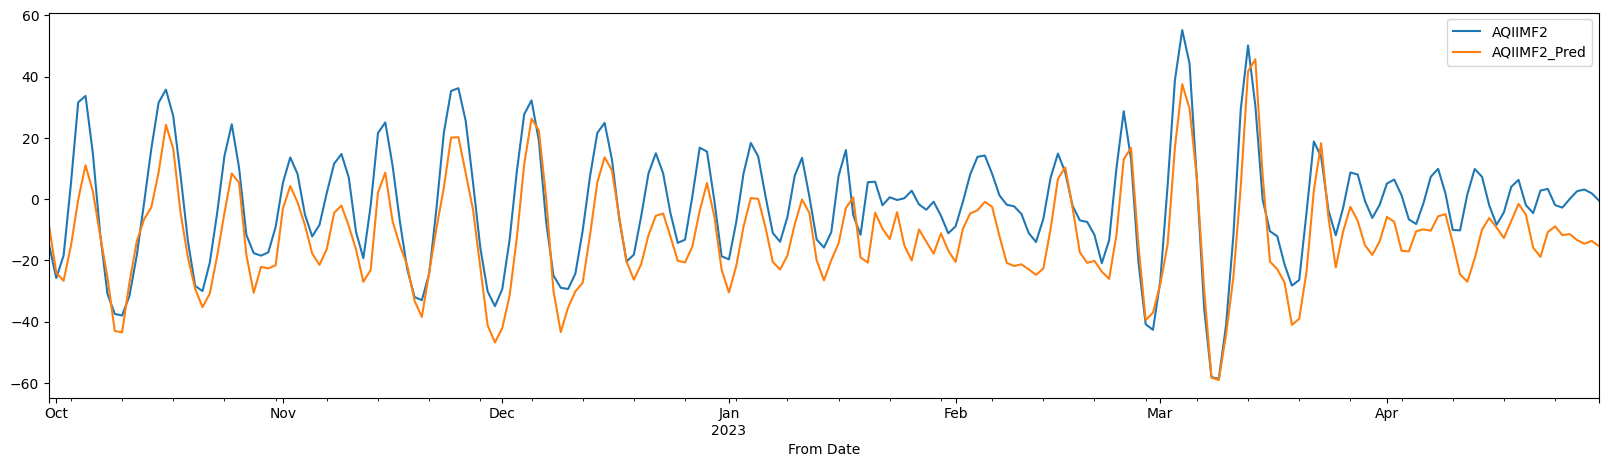

In [126]:
trueAqi= AQIIMF2_Preddata['AQIIMF2']
forcastAQI = AQIIMF2_Preddata['AQIIMF2_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF2_Preddata[['AQIIMF2','AQIIMF2_Pred']].plot()

###IMF3

In [127]:
data = df_input[[
       'AQIIMF3',
       'PM10IMF3',
        'PM2.5IMF3']]

In [128]:
test = data.iloc[972:]
train = data.iloc[:972]

In [129]:
# Scaling and timeseries generator for IMF3
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [130]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF3model = tf.keras.Sequential()
IMF3model.add(SimpleRNN(128, input_shape=(win_length, num_features), return_sequences=True))
IMF3model.add(SimpleRNN(64, return_sequences=True))
IMF3model.add(SimpleRNN(32, return_sequences=False))
IMF3model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF3model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF3model.fit(train_generator, epochs=75, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF3model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/75
40/40 [==============================] - 8s 120ms/step - loss: 0.0875 - root_mean_squared_error: 0.2957 - mean_absolute_error: 0.1841 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799 - val_mean_absolute_error: 0.0625
Epoch 2/75
40/40 [==============================] - 4s 100ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020 - mean_absolute_error: 0.0730 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749 - val_mean_absolute_error: 0.0588
Epoch 3/75
40/40 [==============================] - 3s 80ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - mean_absolute_error: 0.0660 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.0578
Epoch 4/75
40/40 [==============================] - 3s 81ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - mean_absolute_error: 0.0605 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676 - val_mean_absolute_error: 0.0533
Epoch 5/75
40/40 [==============================] - 4s 98m

In [131]:
IMF3model.evaluate(test_generator,verbose=0)

[0.00103797169867903, 0.032217565923929214, 0.02551618590950966]

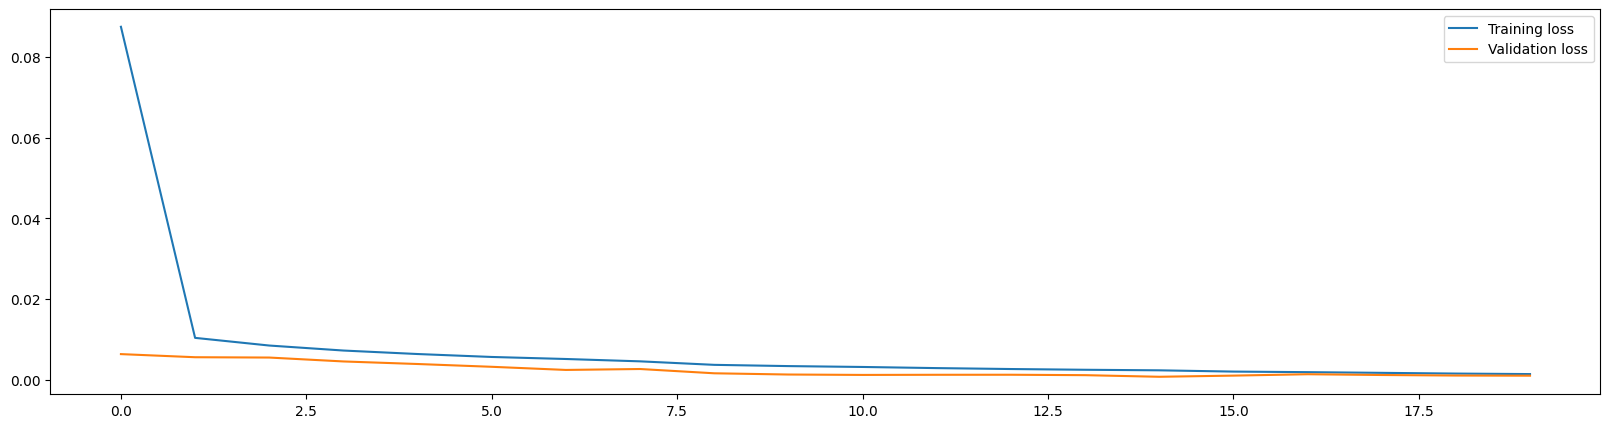

In [132]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [133]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF3model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [134]:
true_predictions = scaler.inverse_transform(test_predictions)

In [135]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)


In [136]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF3   PM10IMF3  PM2.5IMF3
Dates                                      
2023-05-01  -9.967073  -1.468442  -2.618748
2023-05-02  -6.941754  -0.667172  -1.027345
2023-05-03  -0.359871   1.640044   1.671413
2023-05-04   8.086294   6.788436   4.268735
2023-05-05  17.227369  11.647531   7.005067

In [137]:
fin.columns

Index(['AQIIMF3', 'PM10IMF3', 'PM2.5IMF3'], dtype='object')

####Reconstructing the forecasting data

In [138]:
forecast_all2 = pd.concat([forecast_all1,fin[['AQIIMF3','PM2.5IMF3','PM10IMF3']]],axis=1)

####Forecasting Air Quality Index for next 31 days

RMSE =  15.105118320229865
Mean =  -0.12797003109637758
MAPE =  7.28568795557719
R2 Score =  -0.8513176285385762


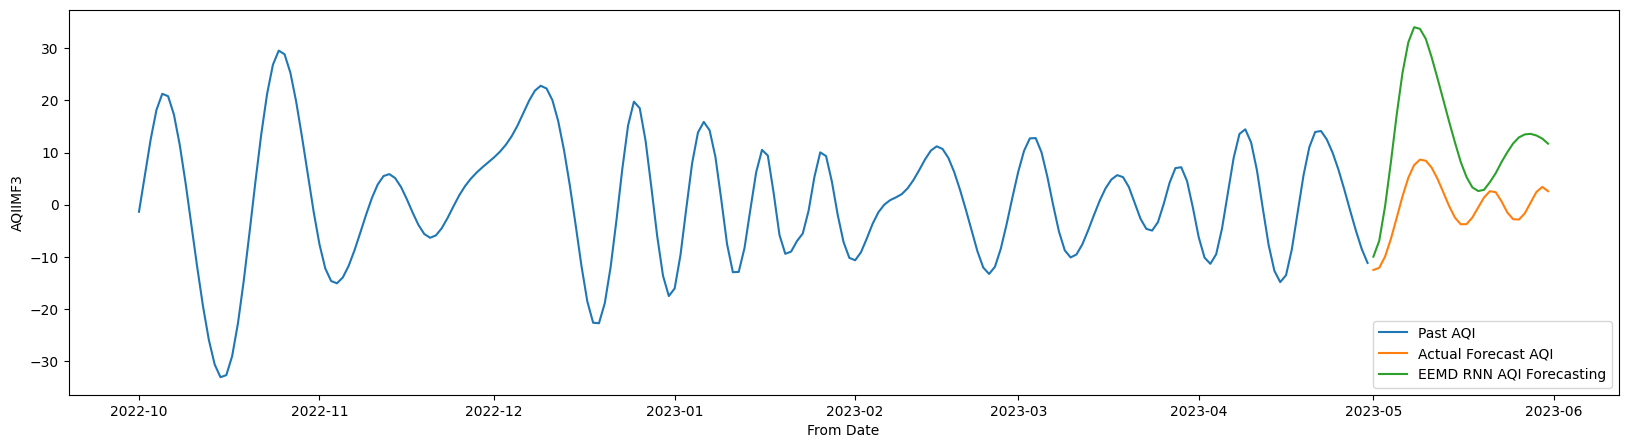

In [139]:
forcastAQI = fin[['AQIIMF3']]
trueAqi = true_forecast1[['AQIIMF3']]

original = final_df[['From Date', 'AQIIMF3']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF3'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF3'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF3'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  5.808676122948957
Mean =  0.049108033617797205
MAPE =  14.377633512746609
R2 Score =  -2.2386079672965216


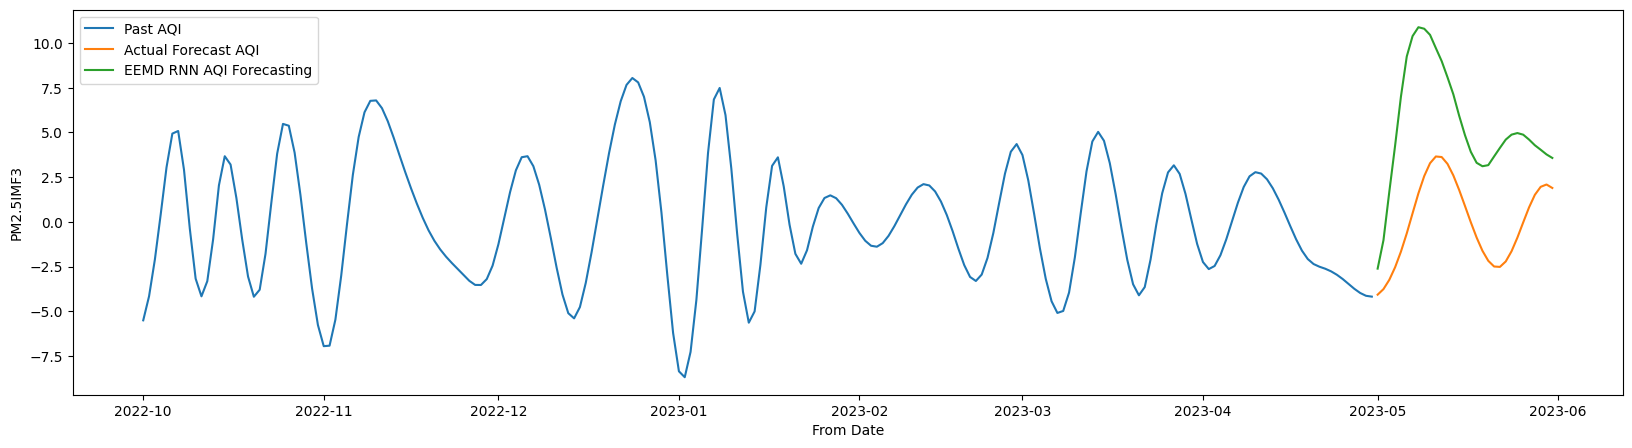

In [140]:
forcastAQI = fin[['PM2.5IMF3']]
trueAqi = true_forecast1[['PM2.5IMF3']]

original = final_df[['From Date', 'PM2.5IMF3']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF3'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF3'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF3'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  14.694098039805313
Mean =  -0.603374121942399
MAPE =  1.764468130837684
R2 Score =  -0.7272063163675302


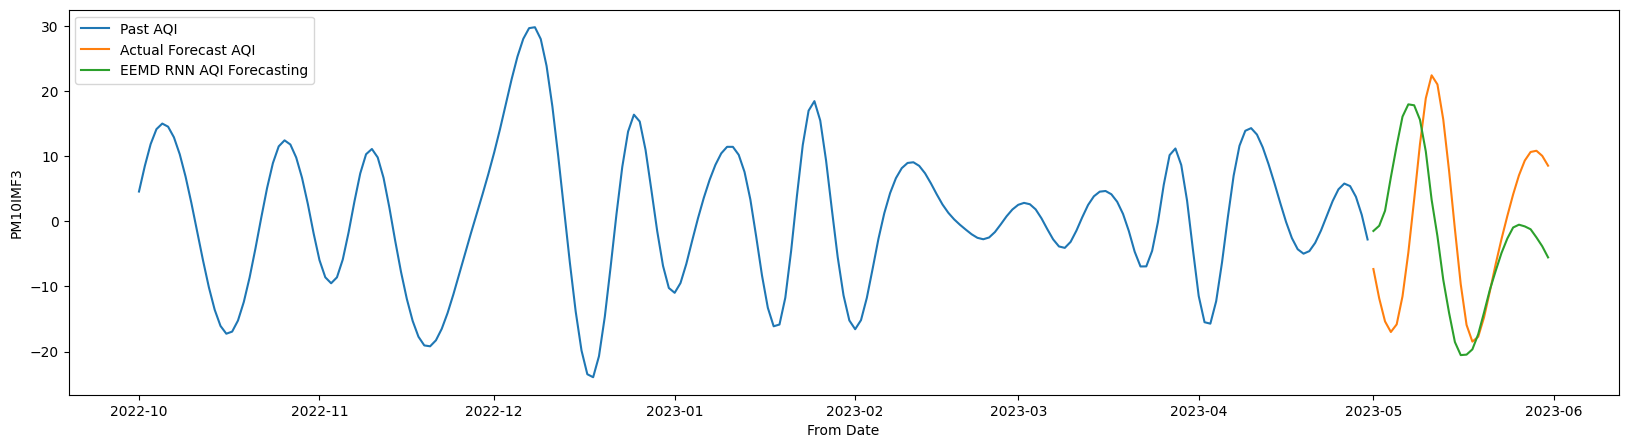

In [141]:
forcastAQI = fin[['PM10IMF3']]
trueAqi = true_forecast1[['PM10IMF3']]

original = final_df[['From Date', 'PM10IMF3']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF3'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF3'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF3'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [142]:
predictions=IMF3model.predict(train_generator)

40/40 [==============================] - 1s 10ms/step


In [143]:
df_pred = pd.DataFrame(predictions)

In [144]:
rev_trans=scaler.inverse_transform(df_pred)

In [145]:
df_final=data[31:972]
df_final

AQIIMF3   PM10IMF3  PM2.5IMF3
From Date                                  
2020-02-01 -18.356401   9.538823 -10.284635
2020-02-02 -12.431539  10.339559  -8.892547
2020-02-03  -5.693705   9.342987  -6.421695
2020-02-04   0.906276   6.780532  -3.171746
2020-02-05   6.823239   3.055219   0.409026
...               ...        ...        ...
2022-08-25  -3.447303   3.954312  -0.310287
2022-08-26   1.410731   6.690669  -0.394759
2022-08-27   5.263805   7.501912  -0.356654
2022-08-28   6.973957   6.187532  -0.148013
2022-08-29   5.828306   2.876072   0.148365

[941 rows x 3 columns]

In [146]:
df_final['AQIIMF3_Pred']=rev_trans[:,0]
df_final['PM10IMF3_Pred']=rev_trans[:,1]
df_final['PM2.5IMF3_Pred']=rev_trans[:,2]

Train AQI RMSE =  5.58573347548766
Train AQI MAPE =  11.458145167829727
Train AQI R2 Score =  0.8656975218165681


<Axes: xlabel='From Date'>

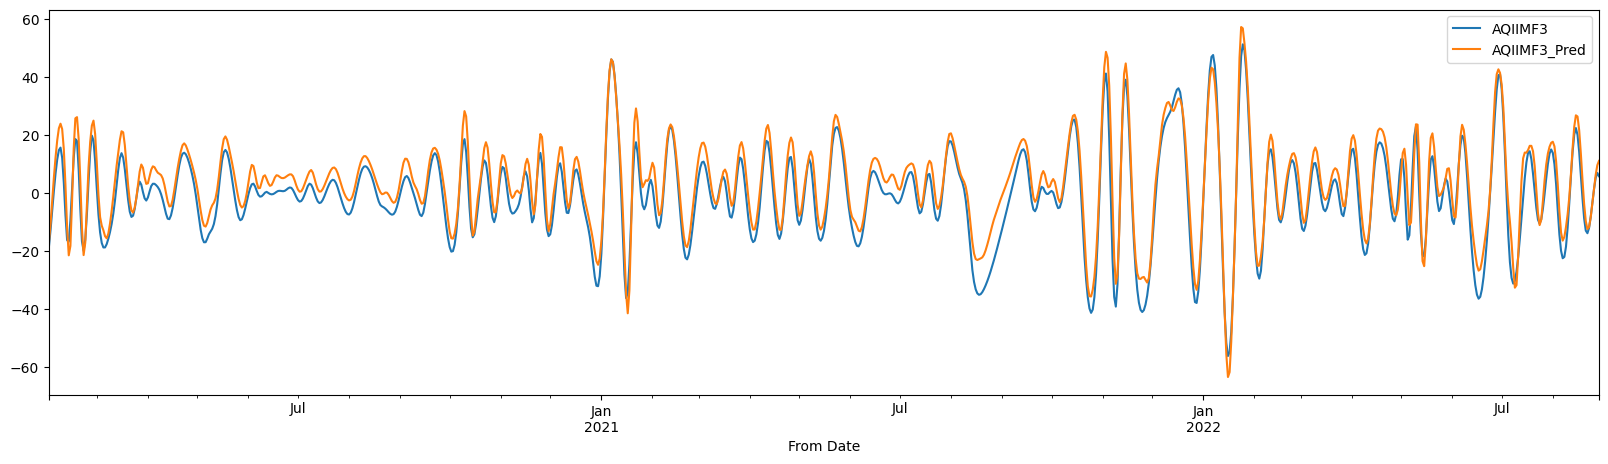

In [147]:
trueAqi= df_final['AQIIMF3']
forcastAQI = df_final['AQIIMF3_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF3','AQIIMF3_Pred']].plot()

####Test Prediction

In [148]:
predictions=IMF3model.predict(test_generator)

9/9 [==============================] - 0s 10ms/step


In [149]:
df_pred = pd.DataFrame(predictions)

In [150]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [151]:
df_final=test

In [152]:
AQIIMF3_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF3_Preddata

AQIIMF3   PM10IMF3  PM2.5IMF3
From Date                                  
2022-09-30  -6.915106   0.646425  -5.895337
2022-10-01  -1.360056   4.593070  -5.510786
2022-10-02   5.509014   8.508707  -4.165549
2022-10-03  12.463264  11.877830  -2.108560
2022-10-04  18.161934  14.184933   0.415230
...               ...        ...        ...
2023-04-26   2.922002   5.820871  -3.474852
2023-04-27  -1.096790   5.429744  -3.747888
2023-04-28  -4.990770   3.786368  -3.980421
2023-04-29  -8.498472   1.011144  -4.138204
2023-04-30 -11.176513  -2.775525  -4.185424

[213 rows x 3 columns]

In [153]:
all_imf=pd.concat([all_imf,AQIIMF3_Preddata],axis=1)

In [154]:
AQIIMF3_Preddata['AQIIMF3_Pred']=rev_trans[:,0]
AQIIMF3_Preddata['PM10IMF3_Pred']=rev_trans[:,1]
AQIIMF3_Preddata['PM2.5IMF3_Pred']=rev_trans[:,2]

In [155]:
AQIIMF3_Preddata

AQIIMF3   PM10IMF3  PM2.5IMF3  AQIIMF3_Pred  PM10IMF3_Pred  \
From Date                                                                  
2022-09-30  -6.915106   0.646425  -5.895337     -7.240306       0.399824   
2022-10-01  -1.360056   4.593070  -5.510786     -1.358010       5.207993   
2022-10-02   5.509014   8.508707  -4.165549      6.172013       9.428108   
2022-10-03  12.463264  11.877830  -2.108560     13.363871      12.499445   
2022-10-04  18.161934  14.184933   0.415230     19.228306      14.699804   
...               ...        ...        ...           ...            ...   
2023-04-26   2.922002   5.820871  -3.474852      6.884457       3.004480   
2023-04-27  -1.096790   5.429744  -3.747888      3.820552       3.210506   
2023-04-28  -4.990770   3.786368  -3.980421     -0.124060       2.792672   
2023-04-29  -8.498472   1.011144  -4.138204     -4.243977       1.867119   
2023-04-30 -11.176513  -2.775525  -4.185424     -7.743289       0.417760   

            PM2.5IMF3_Pred  
From Date                   
2022-09-30       -4.962899  
2022-10-01       -4.660833  
2022-10-02       -3.166441  
2022-10-03       -1.204166  
2022-10-04        0.804656  
...                    ...  
2023-04-26       -1.153800  
2023-04-27       -1.275058  
2023-04-28       -1.764045  
2023-04-29       -2.238898  
2023-04-30       -2.527022  

[213 rows x 6 columns]

Test AQI RMSE =  5.58573347548766
Test AQI MAPE =  5.92119704166618
Test AQI R2 Score =  0.8286288889187019


<Axes: xlabel='From Date'>

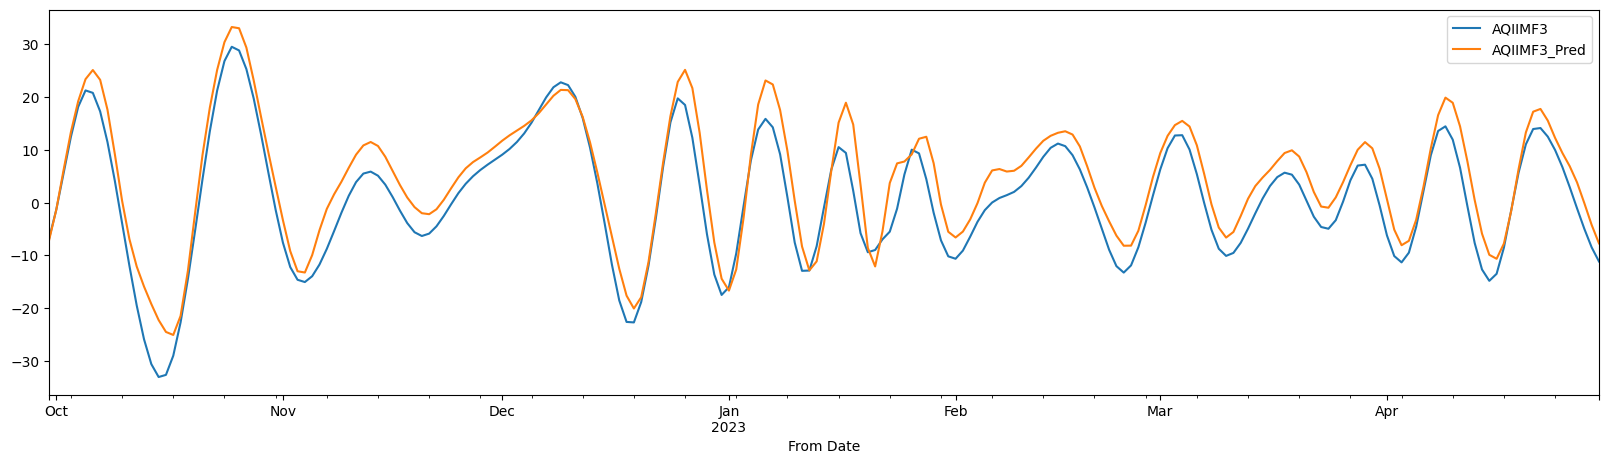

In [156]:
trueAqi= AQIIMF3_Preddata['AQIIMF3']
forcastAQI = AQIIMF3_Preddata['AQIIMF3_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF3_Preddata[['AQIIMF3','AQIIMF3_Pred']].plot()

###IMF4

In [157]:
data = df_input[[
       'AQIIMF4',
       'PM10IMF4',
        'PM2.5IMF4']]

In [158]:
test = data.iloc[972:]
train = data.iloc[:972]

In [159]:
# Scaling and timeseries generator for IMF4
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [160]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF4model = tf.keras.Sequential()
IMF4model.add(SimpleRNN(128, input_shape=(win_length, num_features), return_sequences=True))
IMF4model.add(SimpleRNN(64, return_sequences=True))
IMF4model.add(SimpleRNN(32, return_sequences=False))
IMF4model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF4model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF4model.fit(train_generator, epochs=75, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF4model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/75
40/40 [==============================] - 8s 93ms/step - loss: 0.0573 - root_mean_squared_error: 0.2393 - mean_absolute_error: 0.1638 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265 - val_mean_absolute_error: 0.1028
Epoch 2/75
40/40 [==============================] - 4s 93ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - mean_absolute_error: 0.0829 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759 - val_mean_absolute_error: 0.0606
Epoch 3/75
40/40 [==============================] - 5s 114ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - mean_absolute_error: 0.0689 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - val_mean_absolute_error: 0.0740
Epoch 4/75
40/40 [==============================] - 3s 79ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - mean_absolute_error: 0.0578 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.0443
Epoch 5/75
40/40 [==============================] - 3s 82ms

In [161]:
IMF4model.evaluate(test_generator,verbose=0)

[0.0018321573734283447, 0.04280370473861694, 0.03585284575819969]

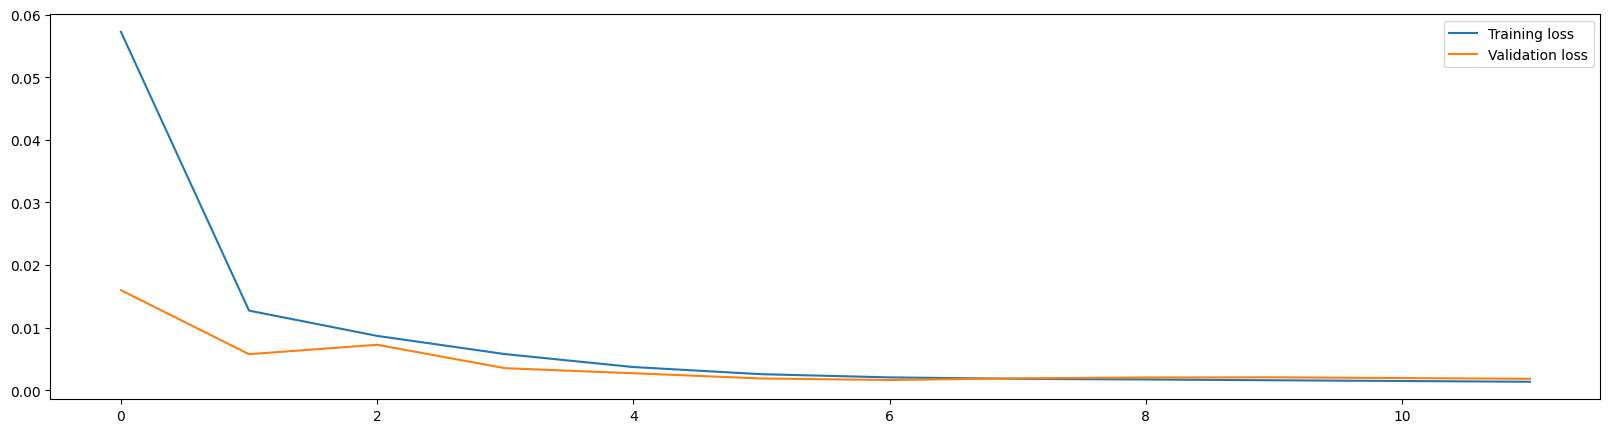

In [162]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [163]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF4model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input


In [164]:
true_predictions = scaler.inverse_transform(test_predictions)

In [165]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [166]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF4   PM10IMF4  PM2.5IMF4
Dates                                      
2023-05-01  -1.184057 -10.639592  -4.916861
2023-05-02   1.848246  -9.474850  -5.414384
2023-05-03   5.799786  -7.300214  -5.502450
2023-05-04   9.704078  -4.708663  -5.885012
2023-05-05  14.696106  -1.487785  -5.894023

In [167]:
fin.columns

Index(['AQIIMF4', 'PM10IMF4', 'PM2.5IMF4'], dtype='object')

####Reconstructing the forecasting data

In [168]:
forecast_all3 = pd.concat([forecast_all2,fin[['AQIIMF4','PM2.5IMF4','PM10IMF4']]],axis=1)

####Forecasting AQI for next 31 days

RMSE =  53.70057147137897
Mean =  0.9264378977310385
MAPE =  19.55236407722809
R2 Score =  -4.253846088061565


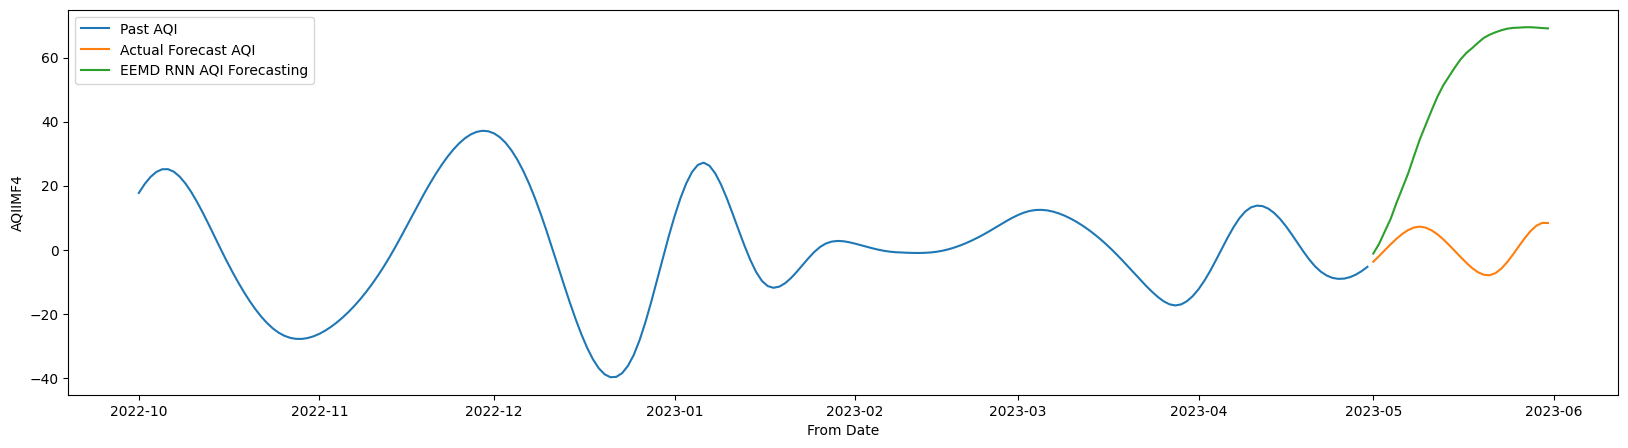

In [169]:
forcastAQI = fin[['AQIIMF4']]
trueAqi = true_forecast1[['AQIIMF4']]

original = final_df[['From Date', 'AQIIMF4']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF4'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF4'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF4'],label = 'EEMD RNN AQI Forecasting')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  6.230274013647069
Mean =  0.33414551719719365
MAPE =  2.0145620060129477
R2 Score =  -1.7480509991336537


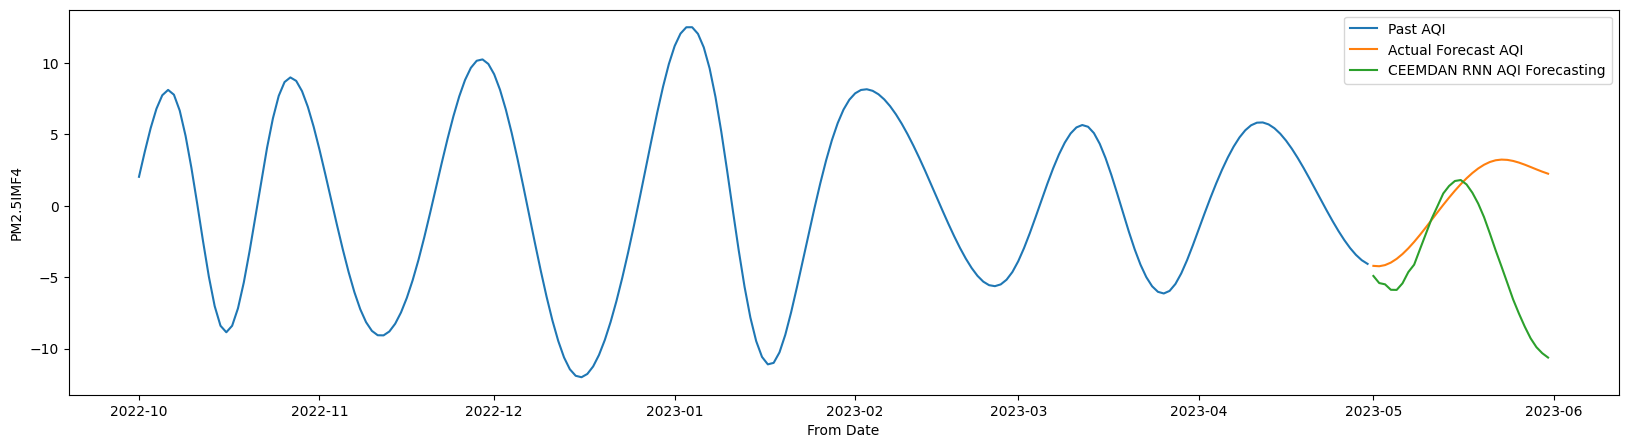

In [170]:
forcastAQI = fin[['PM2.5IMF4']]
trueAqi = true_forecast1[['PM2.5IMF4']]

original = final_df[['From Date', 'PM2.5IMF4']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF4'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF4'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF4'],label = 'CEEMDAN RNN AQI Forecasting')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  6.0839432243382285
Mean =  -0.14285731349180103
MAPE =  1.3970269319779276
R2 Score =  0.6605445870011878


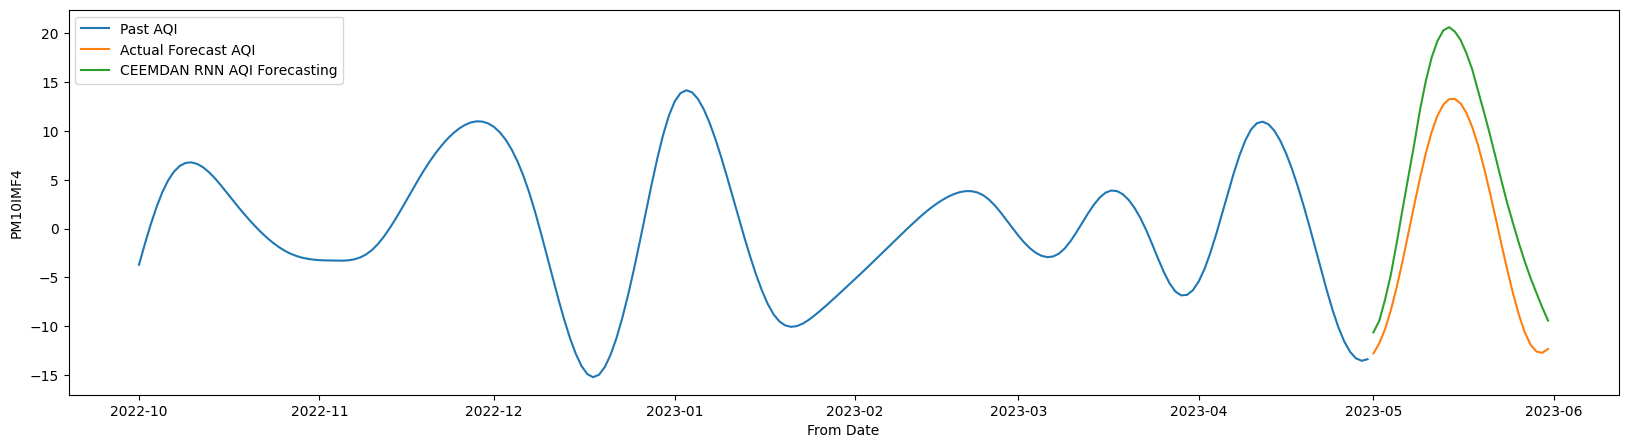

In [171]:
forcastAQI = fin[['PM10IMF4']]
trueAqi = true_forecast1[['PM10IMF4']]

original = final_df[['From Date', 'PM10IMF4']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF4'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF4'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF4'],label = 'CEEMDAN RNN AQI Forecasting')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Predictions

In [172]:
predictions=IMF4model.predict(train_generator)

40/40 [==============================] - 1s 10ms/step


In [173]:
df_pred = pd.DataFrame(predictions)

In [174]:
rev_trans=scaler.inverse_transform(df_pred)

In [175]:
df_final=data[31:972]
df_final

AQIIMF4   PM10IMF4  PM2.5IMF4
From Date                                  
2020-02-01 -14.934711 -19.705321 -13.226046
2020-02-02 -19.000126 -20.024922 -14.557137
2020-02-03 -22.534801 -19.752976 -15.546088
2020-02-04 -25.379396 -18.919289 -16.142879
2020-02-05 -27.374570 -17.575542 -16.297364
...               ...        ...        ...
2022-08-25  -0.904848  24.714701  -0.634646
2022-08-26  -2.495545  21.462928  -0.256325
2022-08-27  -3.618184  18.063513   0.211507
2022-08-28  -4.098943  14.654934   0.719512
2022-08-29  -3.822182  11.346765   1.215924

[941 rows x 3 columns]

In [176]:
df_final['AQIIMF4_Pred']=rev_trans[:,0]
df_final['PM10IMF4_Pred']=rev_trans[:,1]
df_final['PM2.5IMF4_Pred']=rev_trans[:,2]

Train AQI RMSE =  5.233665262175703
Train AQI MAPE =  2.2751985493166798
Train AQI R2 Score =  0.9091992111125996


<Axes: xlabel='From Date'>

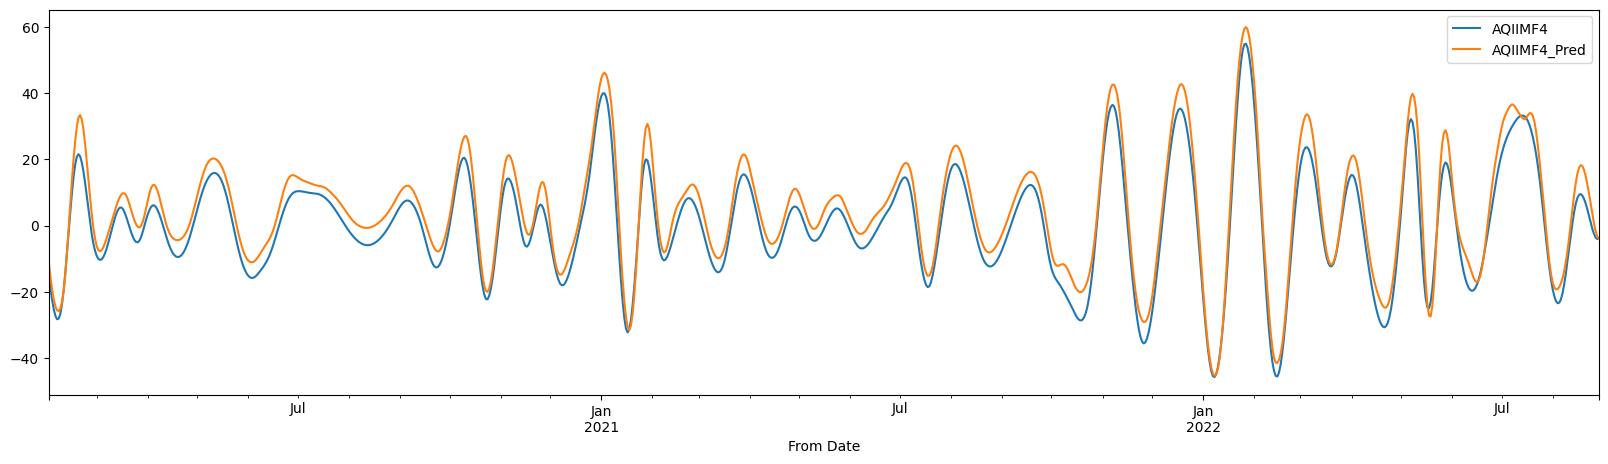

In [177]:
trueAqi= df_final['AQIIMF4']
forcastAQI = df_final['AQIIMF4_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF4','AQIIMF4_Pred']].plot()


####Test Predictions

In [178]:
predictions=IMF4model.predict(test_generator)

9/9 [==============================] - 0s 9ms/step


In [179]:
df_pred = pd.DataFrame(predictions)

In [180]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [181]:
df_final=test

In [182]:
AQIIMF4_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF4_Preddata

AQIIMF4   PM10IMF4  PM2.5IMF4
From Date                                  
2022-09-30  14.524820  -5.870645   0.291735
2022-10-01  17.759618  -3.707952   2.029267
2022-10-02  20.523974  -1.599184   3.791555
2022-10-03  22.731806   0.386761   5.430027
2022-10-04  24.297034   2.180985   6.796113
...               ...        ...        ...
2023-04-26  -8.986787 -11.578542  -2.399756
2023-04-27  -8.536249 -12.638572  -2.962475
2023-04-28  -7.751873 -13.300650  -3.438492
2023-04-29  -6.665141 -13.555402  -3.812235
2023-04-30  -5.307531 -13.393343  -4.070393

[213 rows x 3 columns]

In [183]:
all_imf=pd.concat([all_imf,AQIIMF4_Preddata],axis=1)

In [184]:
AQIIMF4_Preddata['AQIIMF4_Pred']=rev_trans[:,0]
AQIIMF4_Preddata['PM10IMF4_Pred']=rev_trans[:,1]
AQIIMF4_Preddata['PM2.5IMF4_Pred']=rev_trans[:,2]

Test AQI RMSE =  5.233665262175703
Test AQI MAPE =  2.2800086110640145
Test AQI R2 Score =  0.9002102448861816


<Axes: xlabel='From Date'>

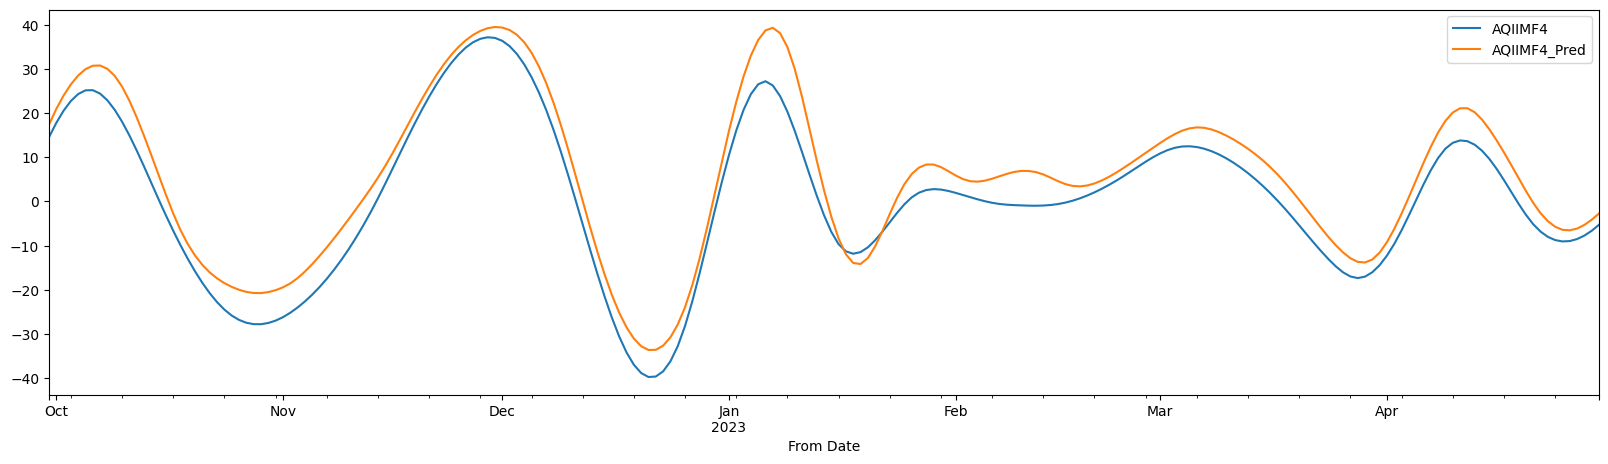

In [185]:
trueAqi= AQIIMF4_Preddata['AQIIMF4']
forcastAQI = AQIIMF4_Preddata['AQIIMF4_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF4_Preddata[['AQIIMF4','AQIIMF4_Pred']].plot()

###IMF5

In [186]:
data = df_input[[
       'AQIIMF5',
       'PM10IMF5',
        'PM2.5IMF5']]

In [187]:
test = data.iloc[972:]
train = data.iloc[:972]

In [188]:
# Scaling and timeseries generator for IMF5
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [189]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF5model = tf.keras.Sequential()
IMF5model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))
IMF5model.add(LSTM(32))
IMF5model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF5model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF5model.fit(train_generator, epochs=100, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF5model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/100
40/40 [==============================] - 9s 20ms/step - loss: 0.0753 - root_mean_squared_error: 0.2745 - mean_absolute_error: 0.2132 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459 - val_mean_absolute_error: 0.1188
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - mean_absolute_error: 0.0975 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1056 - val_mean_absolute_error: 0.0862
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - mean_absolute_error: 0.0734 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950 - val_mean_absolute_error: 0.0799
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - mean_absolute_error: 0.0632 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0725
Epoch 5/100
40/40 [==============================] - 0s 9ms

In [190]:
IMF5model.evaluate(test_generator,verbose=0)

[0.0013234777143225074, 0.03637963533401489, 0.03008280135691166]

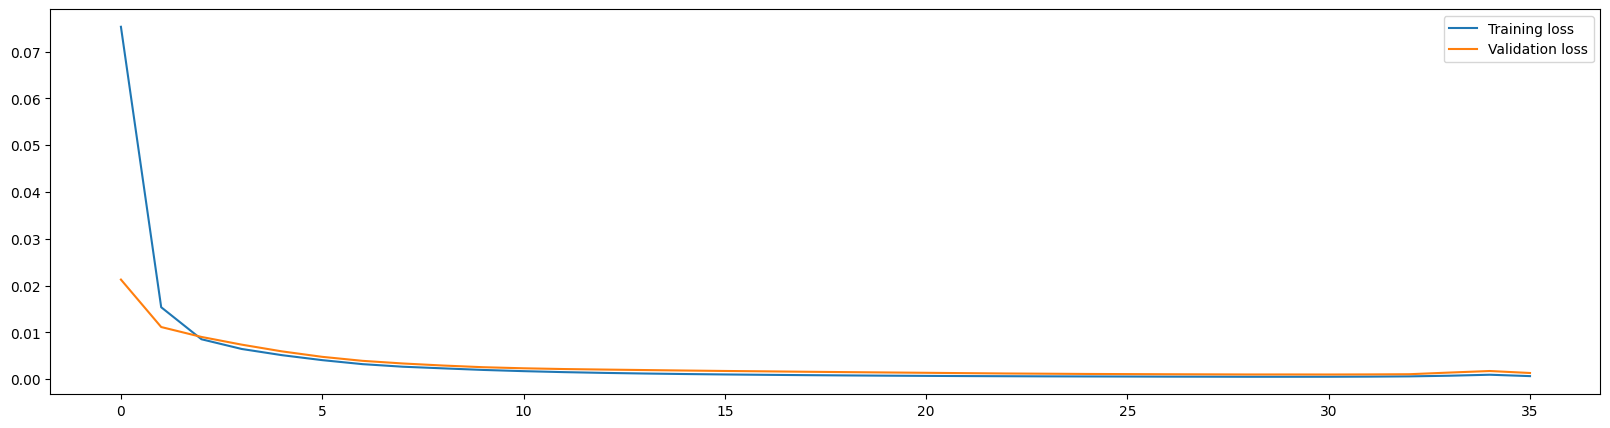

In [191]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [192]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF5model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [193]:
true_predictions = scaler.inverse_transform(test_predictions)

In [194]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [195]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF5   PM10IMF5  PM2.5IMF5
Dates                                     
2023-05-01 -0.042092 -20.462640   3.582018
2023-05-02  0.072053 -20.594364   3.792013
2023-05-03  0.057342 -20.791696   4.056905
2023-05-04 -0.174552 -20.827834   4.355161
2023-05-05 -0.431048 -20.923871   4.690268

In [196]:
fin.columns

Index(['AQIIMF5', 'PM10IMF5', 'PM2.5IMF5'], dtype='object')

####Reconstructing the forecasting data

In [197]:
forecast_all4 = pd.concat([forecast_all3,fin[['AQIIMF5','PM2.5IMF5','PM10IMF5']]],axis=1)

####Forecasting AQI for next 31 days

RMSE =  14.566046580455613
Mean =  6.055020292904211
MAPE =  1.9582426069217818
R2 Score =  -7.576467539707462


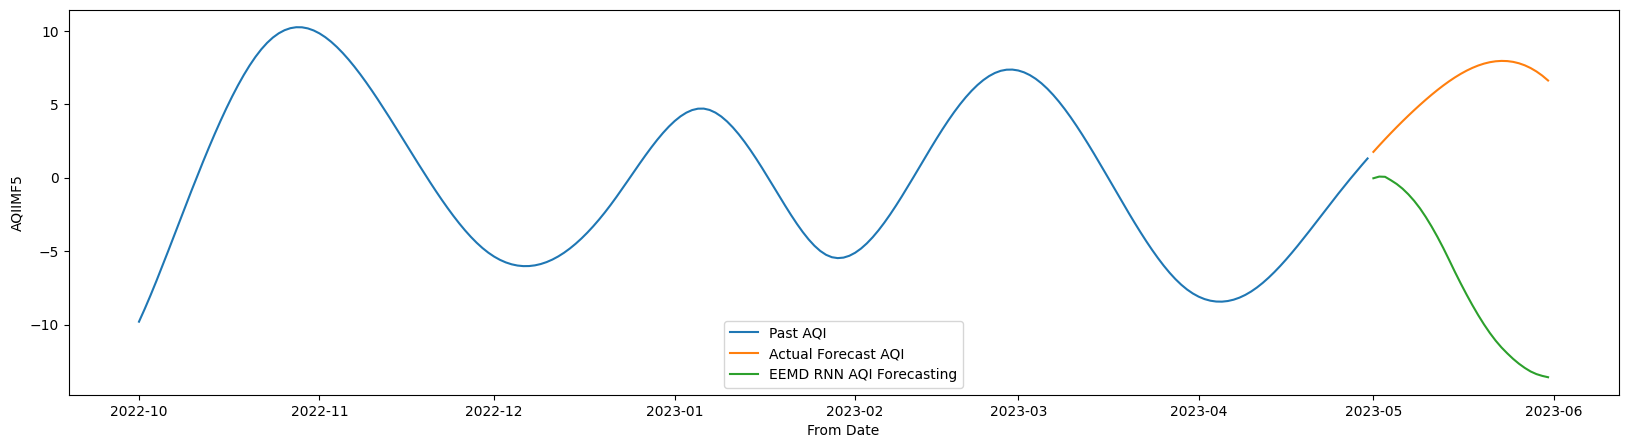

In [198]:
forcastAQI = fin[['AQIIMF5']]
trueAqi = true_forecast1[['AQIIMF5']]

original = final_df[['From Date', 'AQIIMF5']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF5'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF5'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF5'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  10.601541501979726
Mean =  -0.3742761445583903
MAPE =  14.315770975899827
R2 Score =  -10.87265254393033


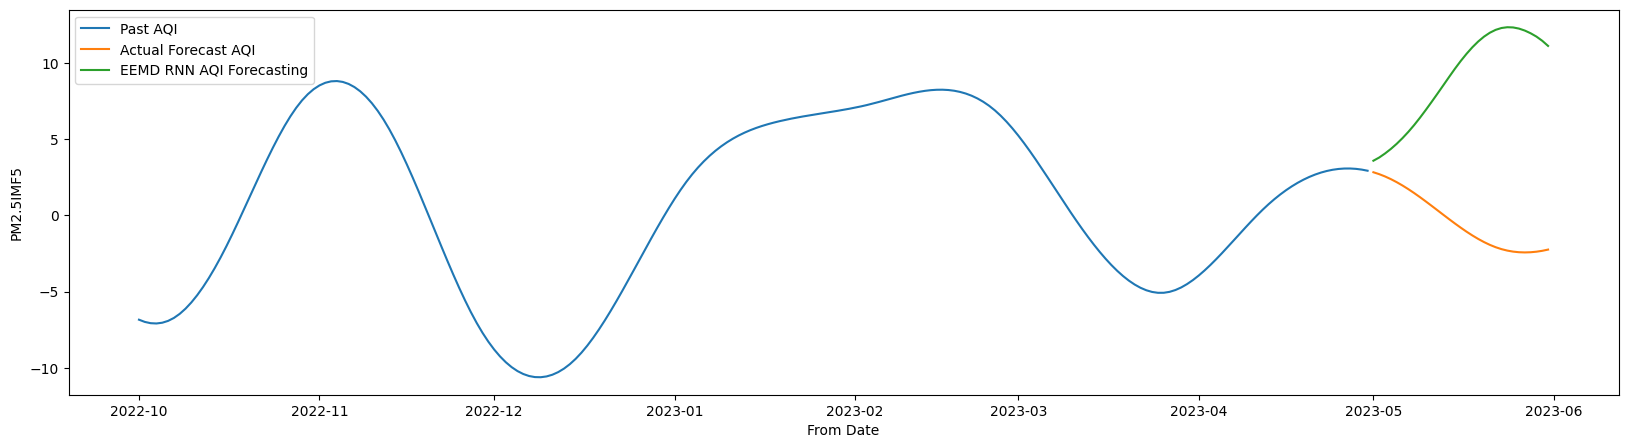

In [199]:
forcastAQI = fin[['PM2.5IMF5']]
trueAqi = true_forecast1[['PM2.5IMF5']]

original = final_df[['From Date', 'PM2.5IMF5']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF5'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF5'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF5'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  7.001310615681198
Mean =  -25.24073775994629
MAPE =  0.20934436434923404
R2 Score =  -2.607060762041514


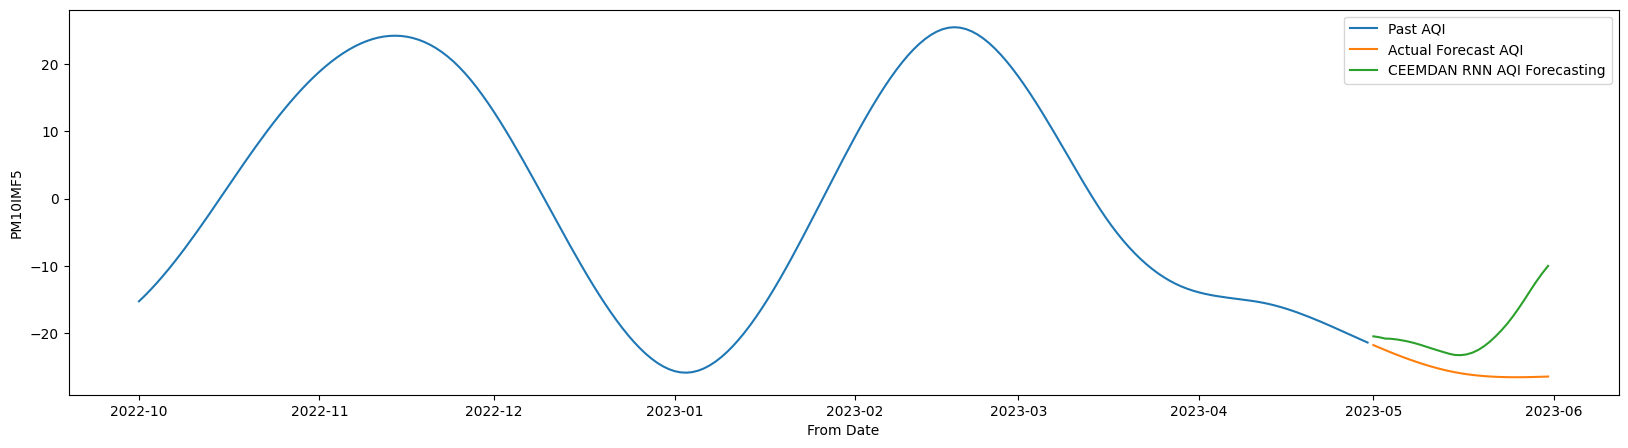

In [200]:
forcastAQI = fin[['PM10IMF5']]
trueAqi = true_forecast1[['PM10IMF5']]

original = final_df[['From Date', 'PM10IMF5']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF5'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF5'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF5'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)


####Train Prediction

In [201]:
predictions=IMF5model.predict(train_generator)

40/40 [==============================] - 0s 3ms/step


In [202]:
df_pred = pd.DataFrame(predictions)

In [203]:
rev_trans=scaler.inverse_transform(df_pred)

In [204]:
df_final=data[31:972]
df_final

AQIIMF5  PM10IMF5  PM2.5IMF5
From Date                                 
2020-02-01  -2.852575 -8.157675   2.062313
2020-02-02  -1.696394 -7.420083   2.719092
2020-02-03  -0.521613 -6.599941   3.368775
2020-02-04   0.666124 -5.706665   4.009429
2020-02-05   1.861171 -4.749854   4.638992
...               ...       ...        ...
2022-08-25  16.612123  1.261409   6.566037
2022-08-26  16.134457  0.002321   6.835410
2022-08-27  15.507904 -1.245418   7.044058
2022-08-28  14.727132 -2.478791   7.191591
2022-08-29  13.788431 -3.694778   7.277622

[941 rows x 3 columns]

In [205]:
df_final['AQIIMF5_Pred']=rev_trans[:,0]
df_final['PM10IMF5_Pred']=rev_trans[:,1]
df_final['PM2.5IMF5_Pred']=rev_trans[:,2]

Train AQI RMSE =  2.0767312940674807
Train AQI MAPE =  0.7006579527444144
Train AQI R2 Score =  0.965595715370587


<Axes: xlabel='From Date'>

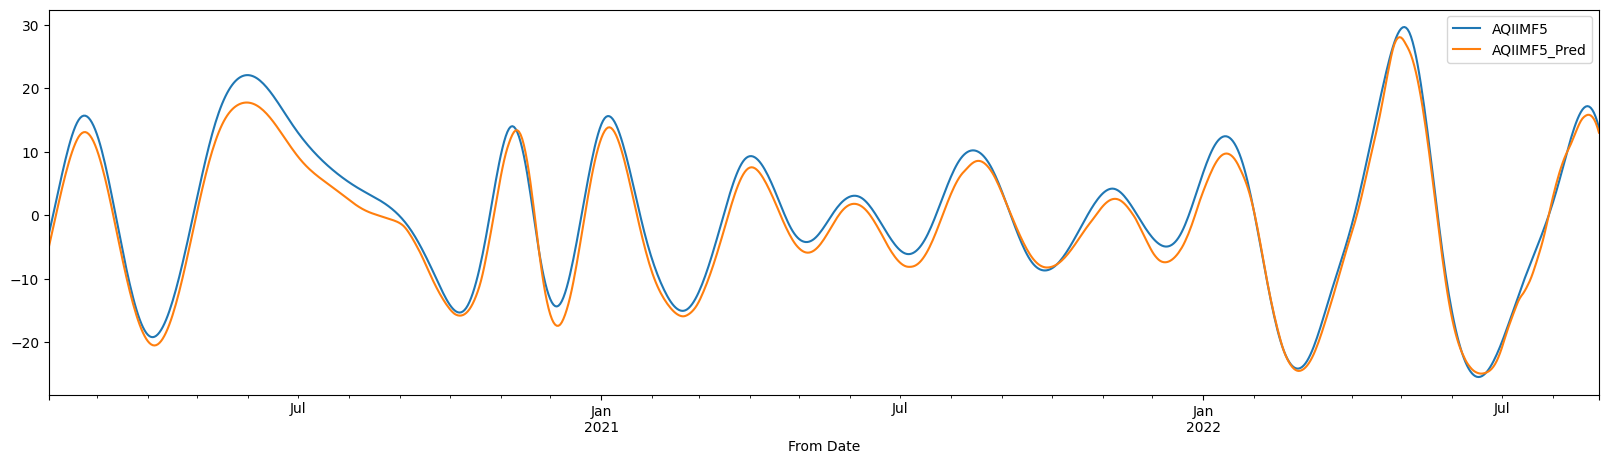

In [206]:
trueAqi= df_final['AQIIMF5']
forcastAQI = df_final['AQIIMF5_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF5','AQIIMF5_Pred']].plot()

####Test Prediction

In [207]:
predictions=IMF5model.predict(test_generator)

9/9 [==============================] - 0s 3ms/step


In [208]:
df_pred = pd.DataFrame(predictions)

In [209]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [210]:
df_final=test

In [211]:
AQIIMF5_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF5_Preddata

AQIIMF5   PM10IMF5  PM2.5IMF5
From Date                                  
2022-09-30 -10.635048 -16.033745  -6.641739
2022-10-01  -9.808776 -15.255623  -6.845497
2022-10-02  -8.925898 -14.420010  -6.990971
2022-10-03  -7.995589 -13.530230  -7.074715
2022-10-04  -7.027026 -12.589607  -7.093464
...               ...        ...        ...
2023-04-26  -0.582052 -19.831288   3.069463
2023-04-27  -0.095196 -20.222100   3.071821
2023-04-28   0.381992 -20.612507   3.048630
2023-04-29   0.849385 -21.000460   2.999901
2023-04-30   1.306855 -21.384024   2.925648

[213 rows x 3 columns]

In [212]:
all_imf=pd.concat([all_imf,AQIIMF5_Preddata],axis=1)

In [213]:
AQIIMF5_Preddata['AQIIMF5_Pred']=rev_trans[:,0]
AQIIMF5_Preddata['PM10IMF5_Pred']=rev_trans[:,1]
AQIIMF5_Preddata['PM2.5IMF5_Pred']=rev_trans[:,2]

Test AQI RMSE =  2.0767312940674807
Test AQI MAPE =  1.6485515983575407
Test AQI R2 Score =  0.8645295062293371


<Axes: xlabel='From Date'>

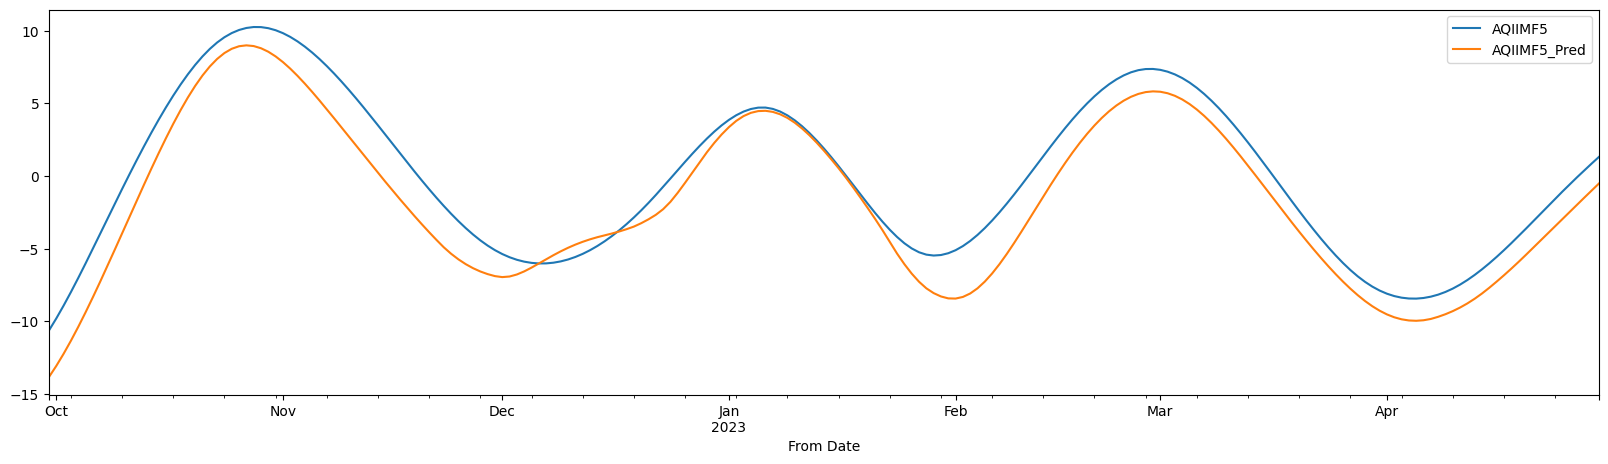

In [214]:
trueAqi= AQIIMF5_Preddata['AQIIMF5']
forcastAQI = AQIIMF5_Preddata['AQIIMF5_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF5_Preddata[['AQIIMF5','AQIIMF5_Pred']].plot()

###IMF6

In [215]:
data = df_input[[
       'AQIIMF6',
       'PM10IMF6',
        'PM2.5IMF6']]

In [216]:
test = data.iloc[972:]
train = data.iloc[:972]

In [217]:
# Scaling and timeseries generator for IMF6
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [218]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF6model = tf.keras.Sequential()
IMF6model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))
IMF6model.add(LSTM(8))
IMF6model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF6model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF6model.fit(train_generator, epochs=50, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF6model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/50
40/40 [==============================] - 5s 29ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708 - mean_absolute_error: 0.3636 - val_loss: 0.1192 - val_root_mean_squared_error: 0.3452 - val_mean_absolute_error: 0.3048
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 0.0605 - root_mean_squared_error: 0.2460 - mean_absolute_error: 0.1955 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023 - val_mean_absolute_error: 0.1754
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0391 - root_mean_squared_error: 0.1976 - mean_absolute_error: 0.1617 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628 - val_mean_absolute_error: 0.1399
Epoch 4/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0305 - root_mean_squared_error: 0.1746 - mean_absolute_error: 0.1418 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1355 - val_mean_absolute_error: 0.1162
Epoch 5/50
40/40 [==============================] - 0s 7ms/ste

In [219]:
IMF6model.evaluate(test_generator,verbose=0)

[0.002642385894432664, 0.05140414088964462, 0.036076731979846954]

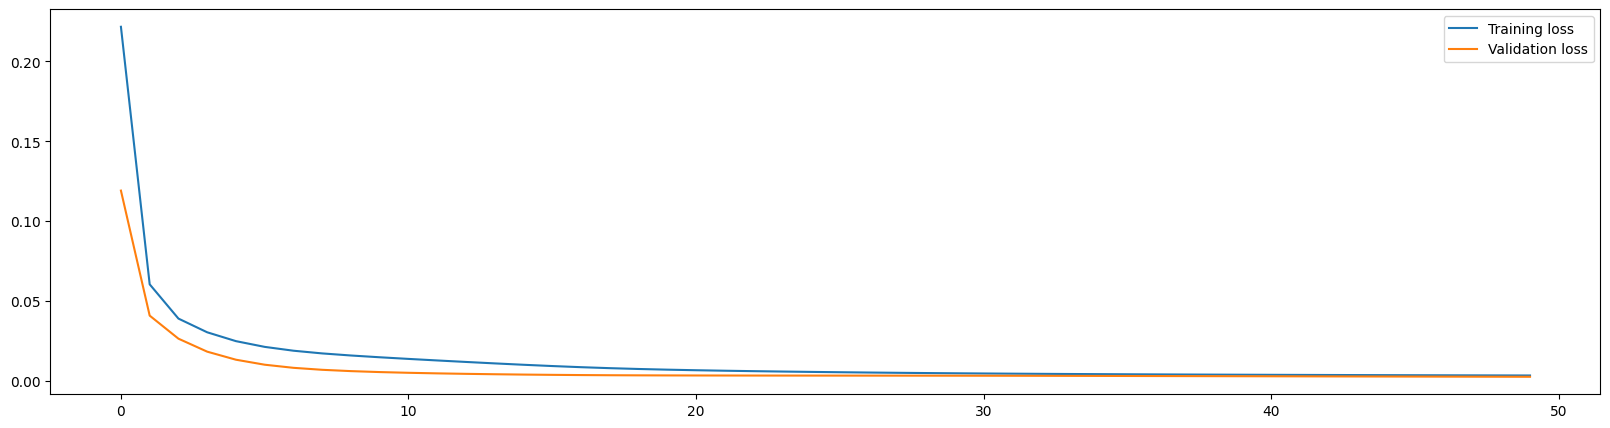

In [220]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [221]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF6model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input


In [222]:
true_predictions = scaler.inverse_transform(test_predictions)

In [223]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [224]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF6   PM10IMF6  PM2.5IMF6
Dates                                      
2023-05-01 -53.052523 -14.250003 -24.092995
2023-05-02 -53.283197 -14.760383 -24.284216
2023-05-03 -53.020402 -14.809276 -24.323497
2023-05-04 -52.807448 -15.042025 -24.318543
2023-05-05 -52.638976 -15.245829 -24.311483

In [225]:
fin.columns

Index(['AQIIMF6', 'PM10IMF6', 'PM2.5IMF6'], dtype='object')

####Reconstructing the forecasting data

In [226]:
forecast_all5 = pd.concat([forecast_all4,fin[['AQIIMF6','PM2.5IMF6','PM10IMF6']]],axis=1)

####Forecasting AQI for next 31 days

RMSE =  2.953761126210273
Mean =  -54.20612345259406
MAPE =  0.05007079748033188
R2 Score =  -10.210595860369317


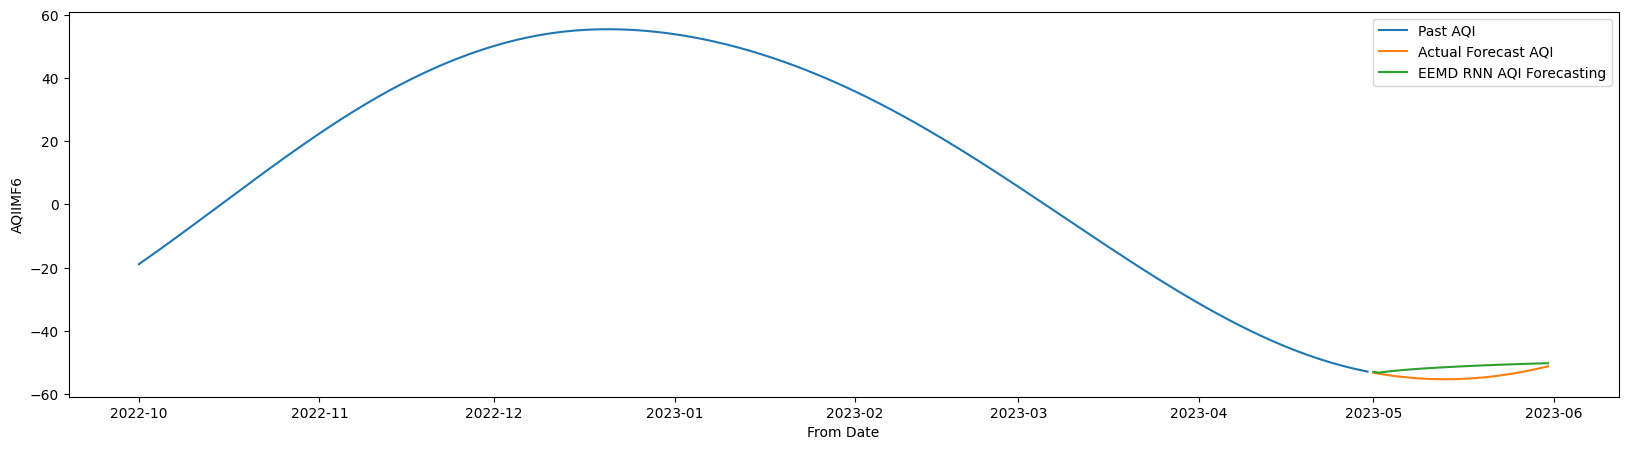

In [227]:
forcastAQI = fin[['AQIIMF6']]
trueAqi = true_forecast1[['AQIIMF6']]

original = final_df[['From Date', 'AQIIMF6']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF6'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF6'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF6'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  6.442934098881955
Mean =  -30.17565630877324
MAPE =  0.2049068614160058
R2 Score =  -753.209721095097


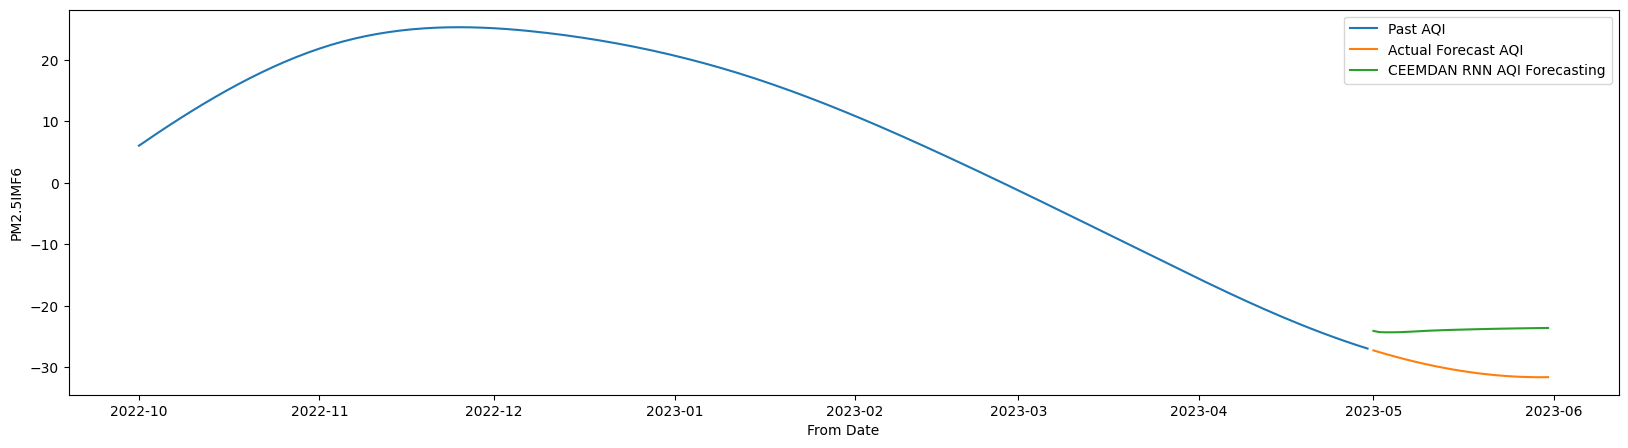

In [228]:
forcastAQI = fin[['PM2.5IMF6']]
trueAqi = true_forecast1[['PM2.5IMF6']]

original = final_df[['From Date', 'PM2.5IMF6']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF6'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF6'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF6'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  1.4186324632115879
Mean =  -14.789228136272037
MAPE =  0.08970321699653652
R2 Score =  -3.264053003588214


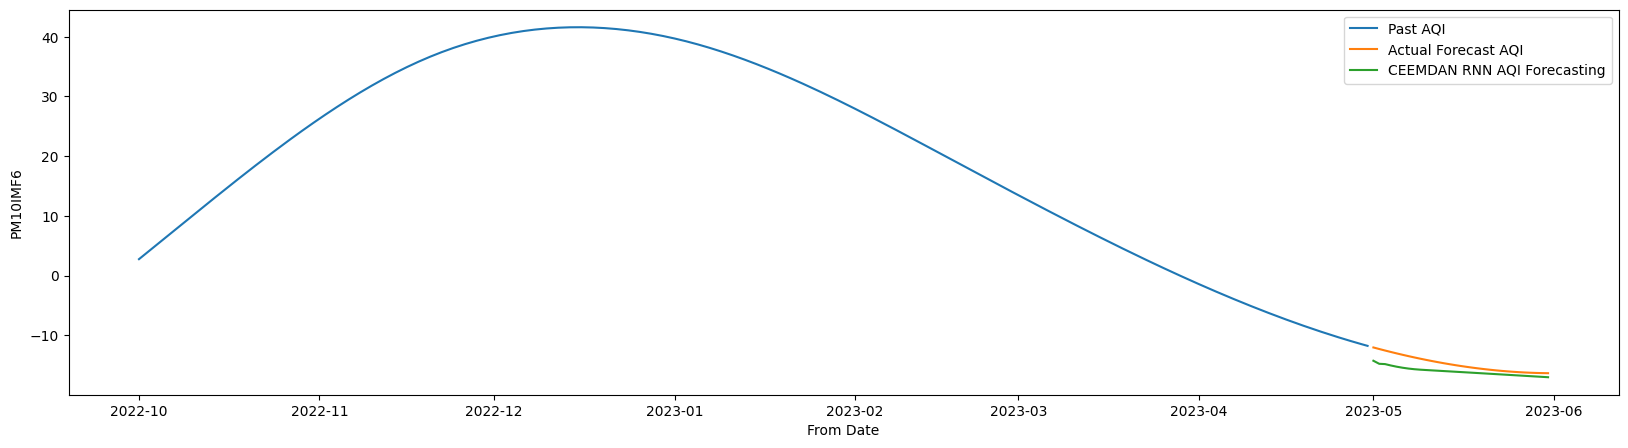

In [229]:
forcastAQI = fin[['PM10IMF6']]
trueAqi = true_forecast1[['PM10IMF6']]

original = final_df[['From Date', 'PM10IMF6']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF6'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF6'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF6'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [230]:
predictions=IMF6model.predict(train_generator)

40/40 [==============================] - 0s 2ms/step


In [231]:
df_pred = pd.DataFrame(predictions)

In [232]:
rev_trans=scaler.inverse_transform(df_pred)

In [233]:
df_final=data[31:972]
df_final

AQIIMF6   PM10IMF6  PM2.5IMF6
From Date                                  
2020-02-01  62.486220  43.608208  18.843836
2020-02-02  62.020677  43.350316  18.492062
2020-02-03  61.531568  43.067241  18.131287
2020-02-04  61.019162  42.759276  17.761660
2020-02-05  60.483725  42.426712  17.383325
...               ...        ...        ...
2022-08-25 -51.567223 -21.149388 -13.022661
2022-08-26 -51.184742 -20.722880 -12.856155
2022-08-27 -50.769812 -20.280133 -12.663732
2022-08-28 -50.322810 -19.821474 -12.445115
2022-08-29 -49.844116 -19.347227 -12.200029

[941 rows x 3 columns]

In [234]:
df_final['AQIIMF6_Pred']=rev_trans[:,0]
df_final['PM10IMF6_Pred']=rev_trans[:,1]
df_final['PM2.5IMF6_Pred']=rev_trans[:,2]

Train AQI RMSE =  6.922211315292437
Train AQI MAPE =  0.3961104007038535
Train AQI R2 Score =  0.9640580130349552


<Axes: xlabel='From Date'>

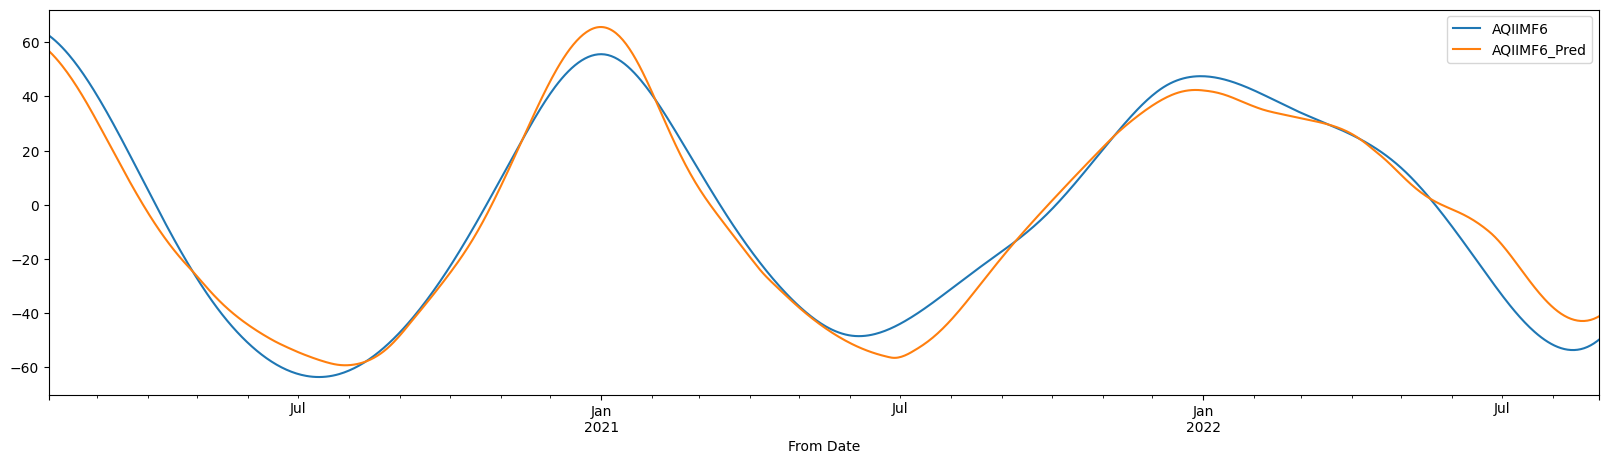

In [235]:
trueAqi= df_final['AQIIMF6']
forcastAQI = df_final['AQIIMF6_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF6','AQIIMF6_Pred']].plot()

####Test Prediction

In [236]:
predictions=IMF6model.predict(test_generator)

9/9 [==============================] - 0s 4ms/step


In [237]:
df_pred = pd.DataFrame(predictions)

In [238]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [239]:
df_final=test

In [240]:
AQIIMF6_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF6_Preddata

AQIIMF6   PM10IMF6  PM2.5IMF6
From Date                                  
2022-09-30 -20.179932   1.974929   5.392530
2022-10-01 -18.902777   2.759414   6.047999
2022-10-02 -17.613024   3.546379   6.698326
2022-10-03 -16.311570   4.335416   7.342651
2022-10-04 -14.999315   5.126116   7.980298
...               ...        ...        ...
2023-04-26 -51.264435 -10.623308 -25.717328
2023-04-27 -51.728181 -10.916861 -26.041852
2023-04-28 -52.163700 -11.203781 -26.358546
2023-04-29 -52.571073 -11.483974 -26.667287
2023-04-30 -52.950382 -11.757345 -26.967953

[213 rows x 3 columns]

In [241]:
all_imf=pd.concat([all_imf,AQIIMF6_Preddata],axis=1)

In [242]:
AQIIMF6_Preddata['AQIIMF6_Pred']=rev_trans[:,0]
AQIIMF6_Preddata['PM10IMF6_Pred']=rev_trans[:,1]
AQIIMF6_Preddata['PM2.5IMF6_Pred']=rev_trans[:,2]

Train AQI RMSE =  3.8497360816785338
Train AQI MAPE =  0.6640247475044226
Train AQI R2 Score =  0.9869013036768228


<Axes: xlabel='From Date'>

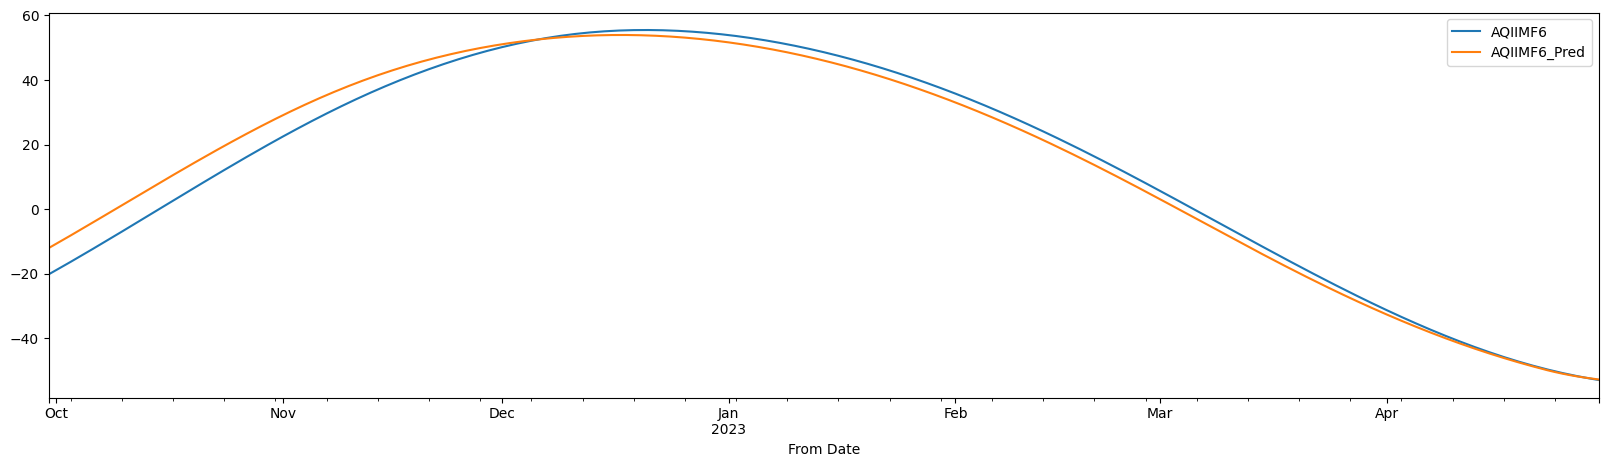

In [243]:
trueAqi= AQIIMF6_Preddata['AQIIMF6']
forcastAQI = AQIIMF6_Preddata['AQIIMF6_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
AQIIMF6_Preddata[['AQIIMF6','AQIIMF6_Pred']].plot()

###IMF7

In [244]:
data = df_input[[
       'AQIIMF7',
       'PM10IMF7',
        'PM2.5IMF7']]

In [245]:
test = data.iloc[972:]
train = data.iloc[:972]

In [246]:
# Scaling and timeseries generator for IMF7
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [247]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF7model = tf.keras.Sequential()
IMF7model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))
IMF7model.add(LSTM(32))
IMF7model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF7model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF7model.fit(train_generator, epochs=75, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF7model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/75
40/40 [==============================] - 4s 18ms/step - loss: 0.0925 - root_mean_squared_error: 0.3042 - mean_absolute_error: 0.2660 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1979 - val_mean_absolute_error: 0.1884
Epoch 2/75
40/40 [==============================] - 0s 7ms/step - loss: 0.0720 - root_mean_squared_error: 0.2683 - mean_absolute_error: 0.2238 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1716 - val_mean_absolute_error: 0.1669
Epoch 3/75
40/40 [==============================] - 0s 7ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - mean_absolute_error: 0.1441 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1909 - val_mean_absolute_error: 0.1515
Epoch 4/75
40/40 [==============================] - 0s 7ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - mean_absolute_error: 0.0585 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938 - val_mean_absolute_error: 0.0698
Epoch 5/75
40/40 [==============================] - 0s 7ms/step

In [248]:
IMF7model.evaluate(test_generator,verbose=0)

[0.009565571323037148, 0.0978037416934967, 0.08009987324476242]

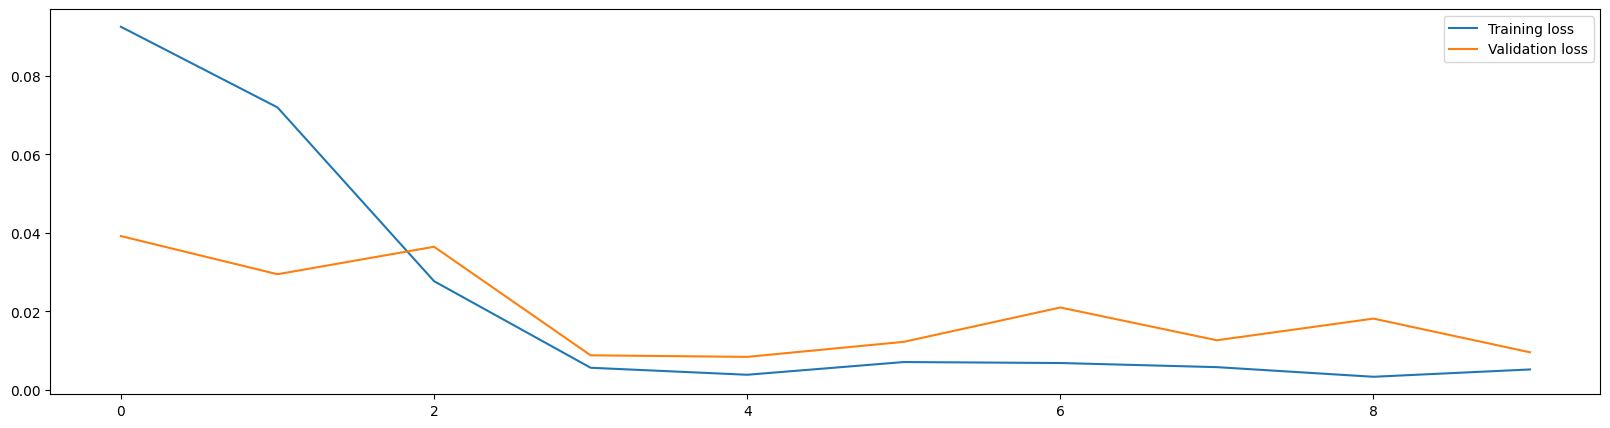

In [249]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [250]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF7model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input


In [251]:
true_predictions = scaler.inverse_transform(test_predictions)

In [252]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [253]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF7  PM10IMF7  PM2.5IMF7
Dates                                    
2023-05-01  0.558162 -5.496177   0.962070
2023-05-02  0.501075 -5.342390   0.514876
2023-05-03  0.381607 -5.140145   0.333346
2023-05-04  0.226429 -5.546274  -0.364010
2023-05-05  0.103949 -5.834052  -0.929635

In [254]:
fin.columns

Index(['AQIIMF7', 'PM10IMF7', 'PM2.5IMF7'], dtype='object')

####Reconstructing data

In [255]:
forecast_all6 = pd.concat([forecast_all5,fin[['AQIIMF7','PM2.5IMF7','PM10IMF7']]],axis=1)

####Forecasting AQI for next 31 days

RMSE =  3.269628742558465
Mean =  -0.6707328575403873
MAPE =  4.667875132151384
R2 Score =  -0.8398472612733019


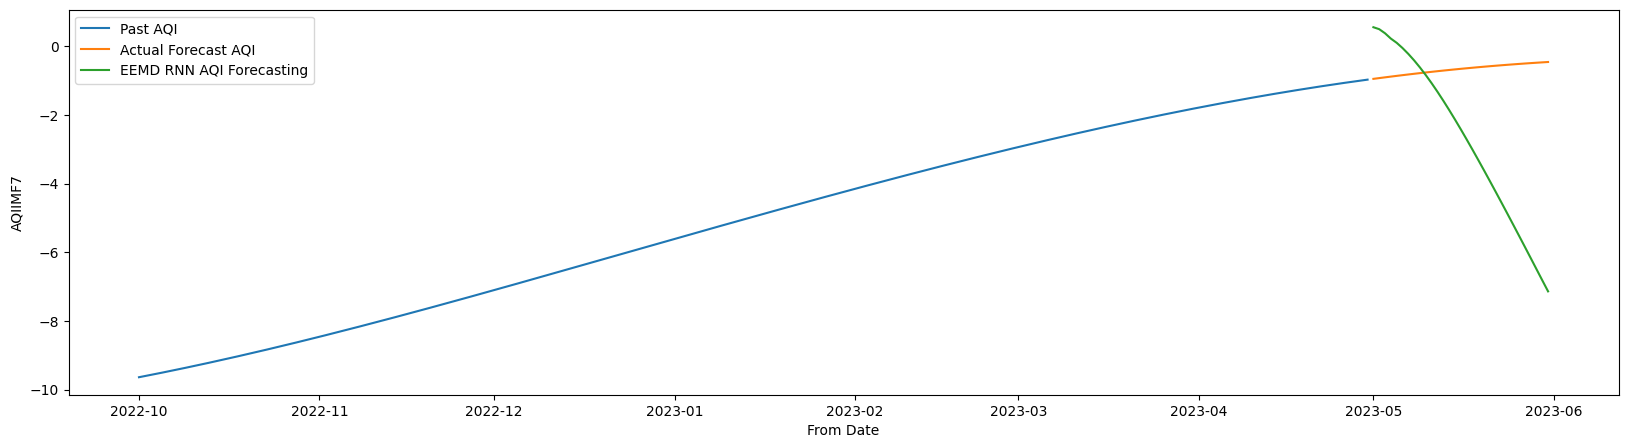

In [256]:
forcastAQI = fin[['AQIIMF7']]
trueAqi = true_forecast1[['AQIIMF7']]

original = final_df[['From Date', 'AQIIMF7']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF7'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF7'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF7'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  14.074920368589424
Mean =  8.770398294067864
MAPE =  1.5518721427513331
R2 Score =  -19.68192296503794


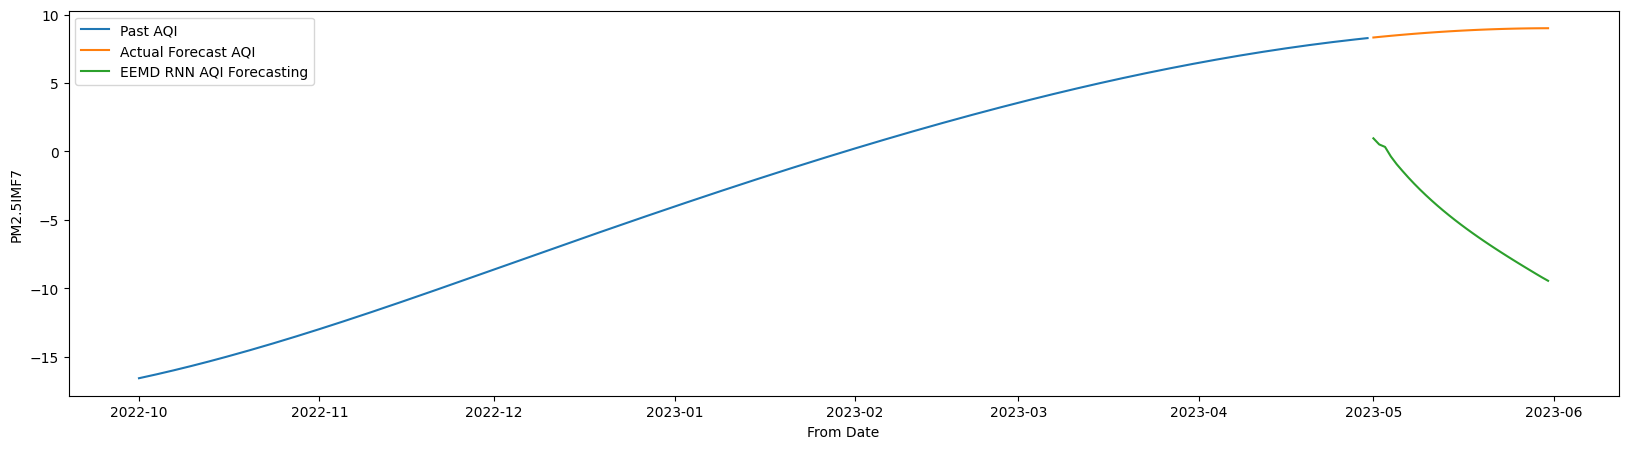

In [257]:
forcastAQI = fin[['PM2.5IMF7']]
trueAqi = true_forecast1[['PM2.5IMF7']]

original = final_df[['From Date', 'PM2.5IMF7']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF7'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF7'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF7'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  2.7676274862589043
Mean =  -8.923747000875954
MAPE =  0.26982501470984516
R2 Score =  -0.531493743879293


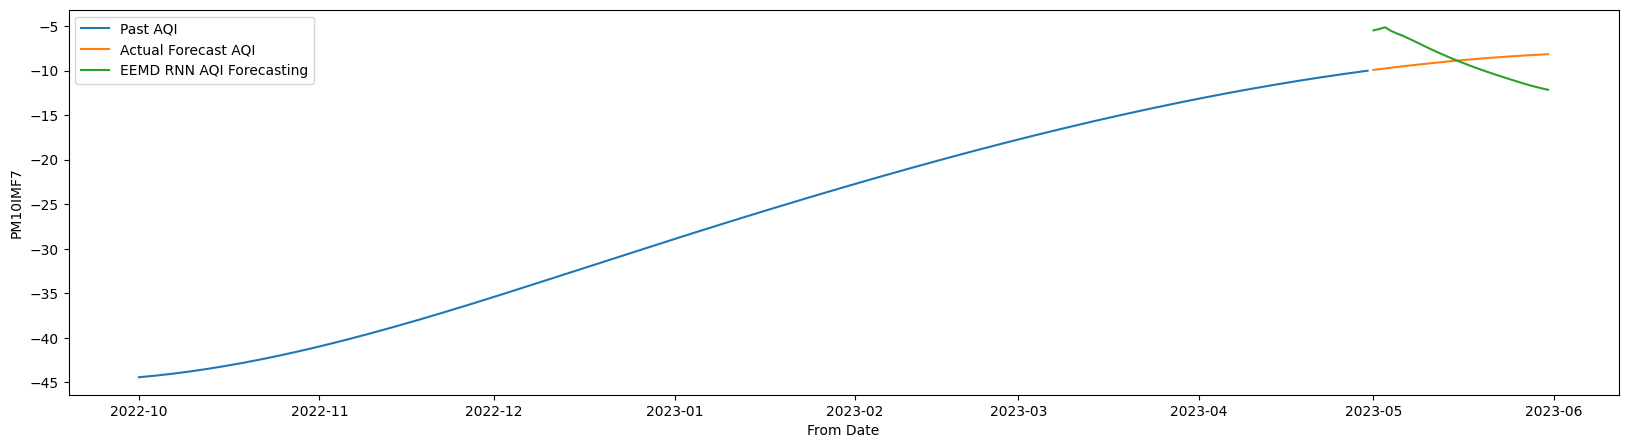

In [258]:
forcastAQI = fin[['PM10IMF7']]
trueAqi = true_forecast1[['PM10IMF7']]

original = final_df[['From Date', 'PM10IMF7']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF7'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF7'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF7'],label = 'EEMD RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [259]:
predictions=IMF7model.predict(train_generator)

40/40 [==============================] - 0s 2ms/step


In [260]:
df_pred = pd.DataFrame(predictions)

In [261]:
rev_trans=scaler.inverse_transform(df_pred)

In [262]:
df_final=data[31:972]
df_final

AQIIMF7   PM10IMF7  PM2.5IMF7
From Date                                  
2020-02-01 -19.204132   3.009530 -14.112021
2020-02-02 -19.207521   2.960167 -14.109082
2020-02-03 -19.210206   2.910044 -14.105895
2020-02-04 -19.212188   2.859164 -14.102459
2020-02-05 -19.213469   2.807527 -14.098777
...               ...        ...        ...
2022-08-25 -10.548432 -43.248125 -18.394082
2022-08-26 -10.532863 -43.376861 -18.392053
2022-08-27 -10.516737 -43.499557 -18.387041
2022-08-28 -10.500057 -43.616269 -18.379077
2022-08-29 -10.482830 -43.727050 -18.368191

[941 rows x 3 columns]

In [263]:
df_final['AQIIMF7_Pred']=rev_trans[:,0]
df_final['PM10IMF7_Pred']=rev_trans[:,1]
df_final['PM2.5IMF7_Pred']=rev_trans[:,2]

Train AQI RMSE =  3.101979633622403
Train AQI MAPE =  1.0766519037424909
Train AQI R2 Score =  0.8870587789845539


<Axes: xlabel='From Date'>

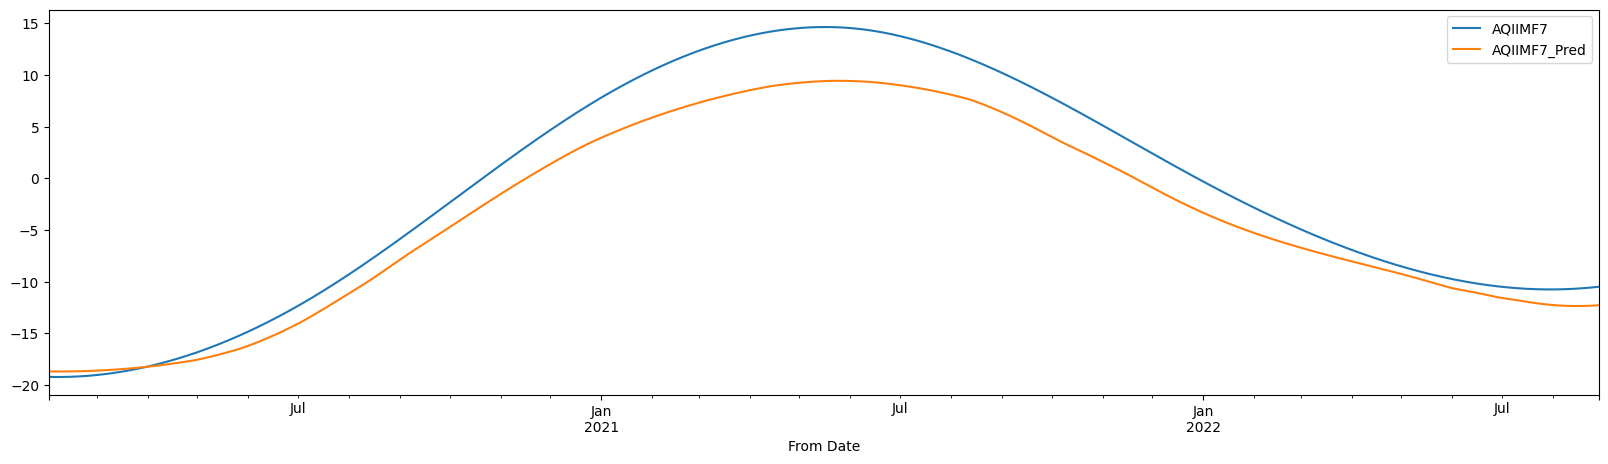

In [264]:
trueAqi= df_final['AQIIMF7']
forcastAQI = df_final['AQIIMF7_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF7','AQIIMF7_Pred']].plot()

####Test Prediction

In [265]:
predictions=IMF7model.predict(test_generator)

9/9 [==============================] - 0s 3ms/step


In [266]:
df_pred = pd.DataFrame(predictions)

In [267]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [268]:
df_final=test

In [269]:
AQIIMF7_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF7_Preddata

AQIIMF7   PM10IMF7  PM2.5IMF7
From Date                                 
2022-09-30 -9.670773 -44.464229 -16.657991
2022-10-01 -9.638142 -44.409639 -16.567647
2022-10-02 -9.605125 -44.350958 -16.475408
2022-10-03 -9.571728 -44.288239 -16.381307
2022-10-04 -9.537955 -44.221538 -16.285372
...              ...        ...        ...
2023-04-26 -1.063478 -10.378430   8.096142
2023-04-27 -1.039248 -10.286553   8.145203
2023-04-28 -1.015396 -10.196259   8.192994
2023-04-29 -0.991926 -10.107556   8.239505
2023-04-30 -0.968840 -10.020456   8.284731

[213 rows x 3 columns]

In [270]:
all_imf=pd.concat([all_imf,AQIIMF7_Preddata],axis=1)

In [271]:
AQIIMF7_Preddata['AQIIMF7_Pred']=rev_trans[:,0]
AQIIMF7_Preddata['PM10IMF7_Pred']=rev_trans[:,1]
AQIIMF7_Preddata['PM2.5IMF7_Pred']=rev_trans[:,2]

Test AQI RMSE =  3.101979633622403
Test AQI MAPE =  0.4047993552806142
Test AQI R2 Score =  0.8863747123912736


<Axes: xlabel='From Date'>

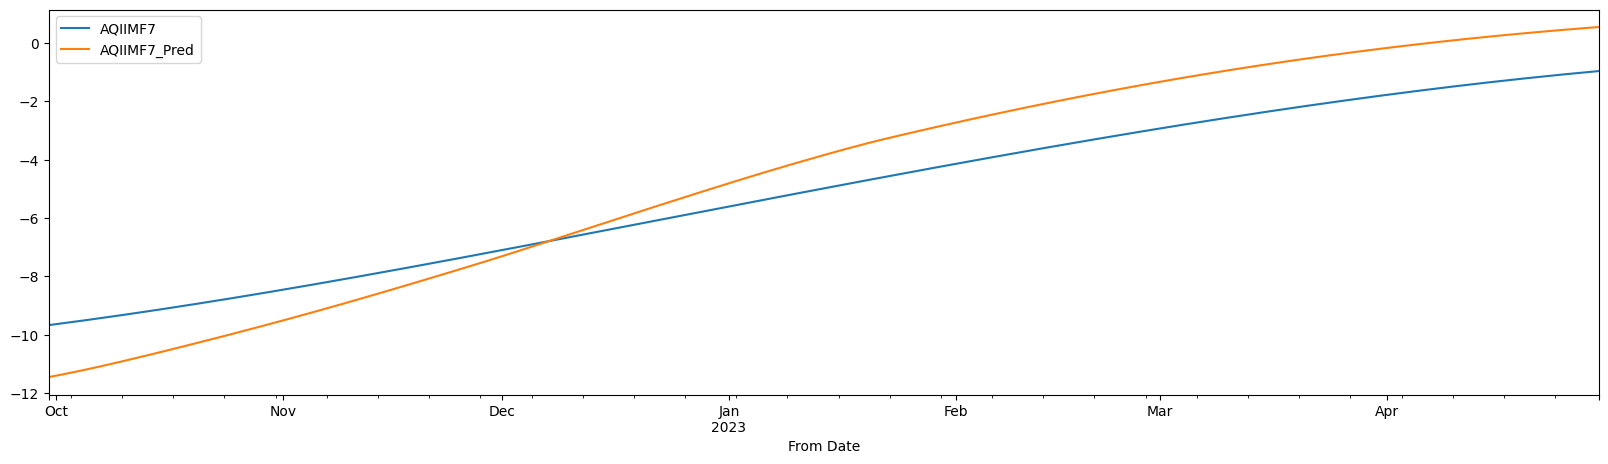

In [272]:
trueAqi= AQIIMF7_Preddata['AQIIMF7']
forcastAQI = AQIIMF7_Preddata['AQIIMF7_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF7_Preddata[['AQIIMF7','AQIIMF7_Pred']].plot()

###IMF8

In [273]:
data = df_input[[
       'AQIIMF8',
       'PM10IMF8',
        'PM2.5IMF8']]

In [274]:
test = data.iloc[972:]
train = data.iloc[:972]

In [275]:
# Scaling and timeseries generator for IMF8
%%capture
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

win_length = 31
batch_size = 24
num_features = 3
train_generator = TimeseriesGenerator(scaled_train,scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test,scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [276]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Define the model architecture
IMF8model = tf.keras.Sequential()
IMF8model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))
IMF8model.add(LSTM(32))
IMF8model.add(Dense(scaled_train.shape[1]))

# Compile the model
IMF8model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
history = IMF8model.fit(train_generator, epochs=50, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])
test_loss, test_rmse, test_mae = IMF8model.evaluate(train_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Epoch 1/50
40/40 [==============================] - 4s 19ms/step - loss: 0.0742 - root_mean_squared_error: 0.2723 - mean_absolute_error: 0.1942 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.0420
Epoch 2/50
40/40 [==============================] - 0s 7ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407 - mean_absolute_error: 0.3751 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2675 - val_mean_absolute_error: 0.2276
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - mean_absolute_error: 0.1859 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019 - val_mean_absolute_error: 0.0796
Epoch 4/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0079 - root_mean_squared_error: 0.0889 - mean_absolute_error: 0.0589 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.0510
Epoch 5/50
40/40 [==============================] - 0s 7ms/step

In [277]:
IMF8model.evaluate(test_generator,verbose=0)

[0.0035725461784750223, 0.05977078154683113, 0.0459081307053566]

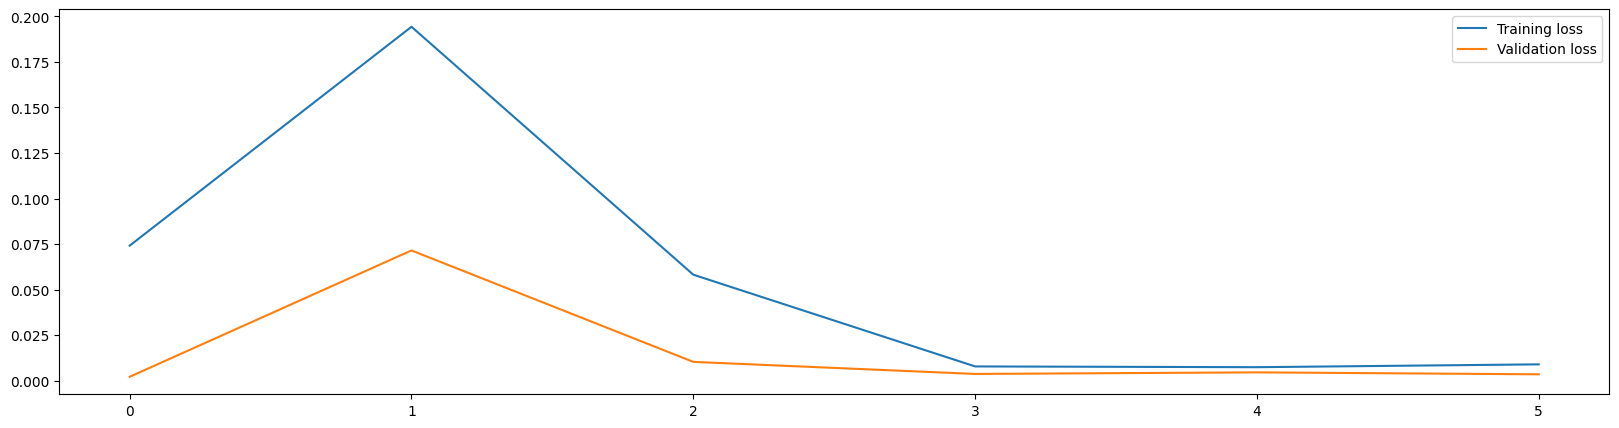

In [278]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####Forecasting for next 31 days

In [279]:
%%capture
test_predictions = []

first_eval_batch = scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = IMF8model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [280]:
true_predictions = scaler.inverse_transform(test_predictions)

In [281]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [282]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)
fin.set_index('Dates', inplace=True)
fin.head()

AQIIMF8   PM10IMF8  PM2.5IMF8
Dates                                       
2023-05-01  117.625186  98.246194  35.251750
2023-05-02  117.651540  98.379647  35.280728
2023-05-03  117.714918  98.587101  35.323342
2023-05-04  117.835089  98.739415  35.273070
2023-05-05  117.953007  98.890223  35.271194

In [283]:
fin.columns

Index(['AQIIMF8', 'PM10IMF8', 'PM2.5IMF8'], dtype='object')

####Reconstructing data

In [284]:
forecast_all7 = pd.concat([forecast_all6,fin[['AQIIMF8','PM10IMF8','PM2.5IMF8']]],axis=1)

####Forecasting AQI for next 31 days

RMSE =  1.020337352751788
Mean =  118.73269851660878
MAPE =  0.007414192592825293
R2 Score =  -0.336365316368356


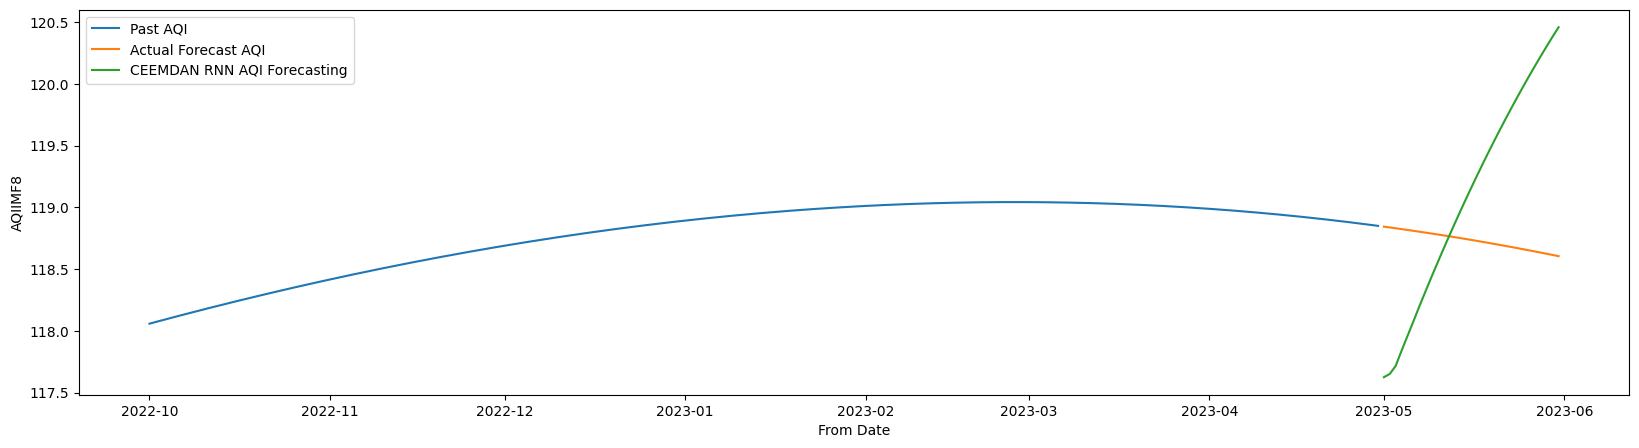

In [285]:
forcastAQI = fin[['AQIIMF8']]
trueAqi = true_forecast1[['AQIIMF8']]

original = final_df[['From Date', 'AQIIMF8']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['AQIIMF8'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQIIMF8'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['AQIIMF8'],label = 'CEEMDAN RNN AQI Forecasting')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM2.5 for next 31 days

RMSE =  0.190583731733851
Mean =  35.01474502421064
MAPE =  0.00476888991145652
R2 Score =  -3.239870643053001


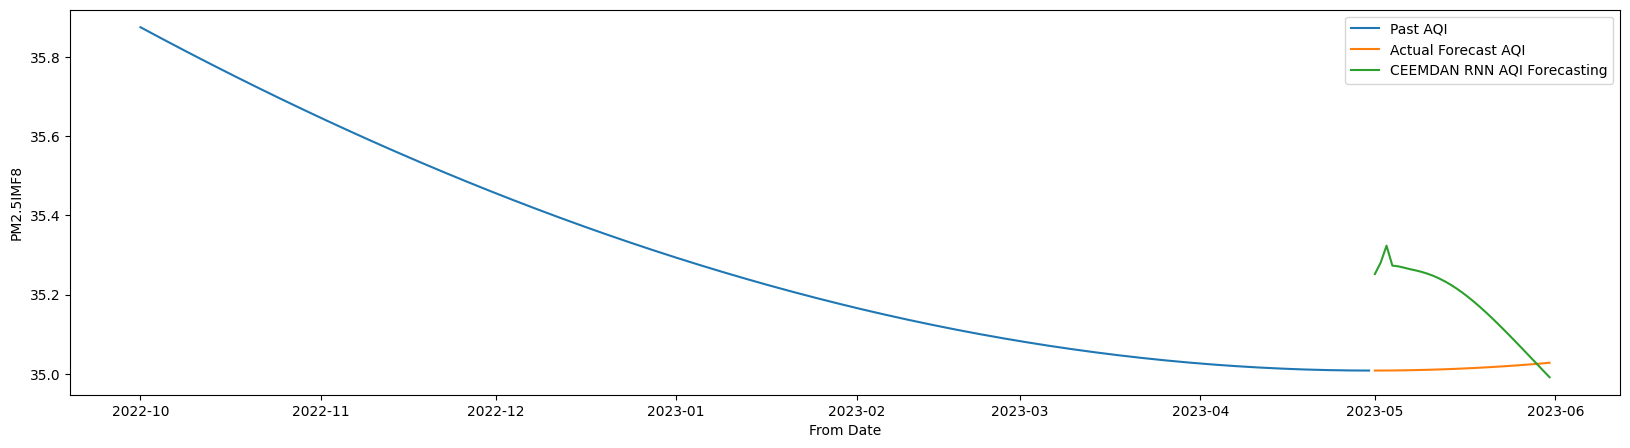

In [286]:
forcastAQI = fin[['PM2.5IMF8']]
trueAqi = true_forecast1[['PM2.5IMF8']]

original = final_df[['From Date', 'PM2.5IMF8']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5IMF8'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM2.5IMF8'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM2.5IMF8'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Forecasting PM10 for next 31 days

RMSE =  4.986624894334072
Mean =  94.97611534478257
MAPE =  0.05165612698152697
R2 Score =  -39.99738824584483


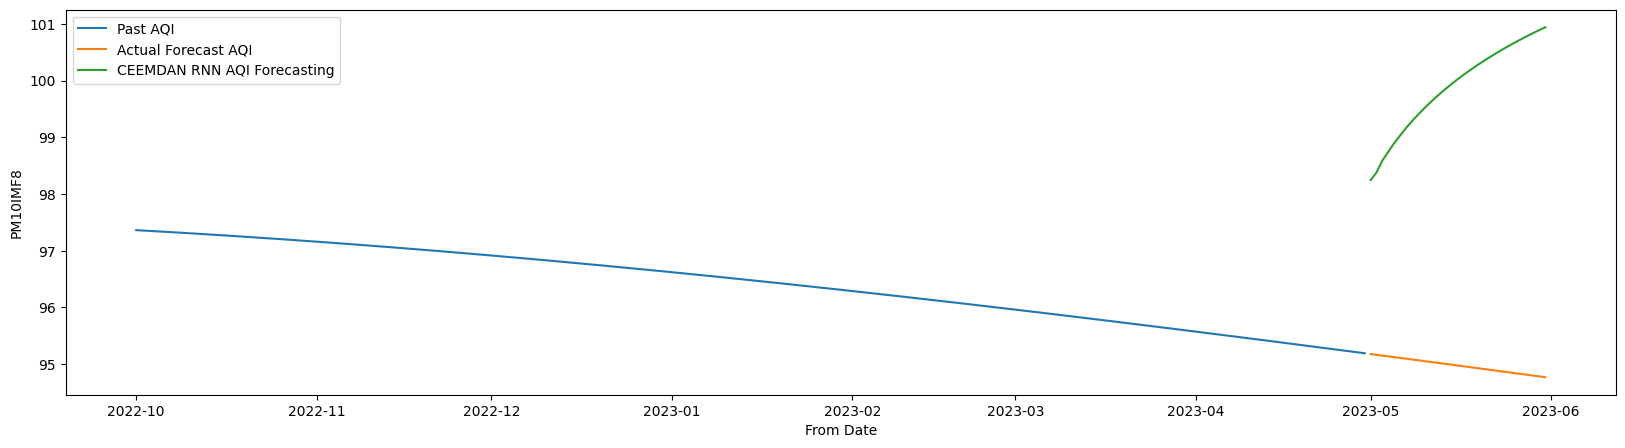

In [287]:
forcastAQI = fin[['PM10IMF8']]
trueAqi = true_forecast1[['PM10IMF8']]

original = final_df[['From Date', 'PM10IMF8']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2022-10-01']

sns.lineplot(x=original['From Date'], y=original['PM10IMF8'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['PM10IMF8'],label = 'Actual Forecast AQI')
sns.lineplot(x=fin.index, y=fin['PM10IMF8'],label = 'CEEMDAN RNN AQI Forecasting')

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

####Train Prediction

In [288]:
predictions=IMF8model.predict(train_generator)

40/40 [==============================] - 0s 2ms/step


In [289]:
df_pred = pd.DataFrame(predictions)

In [290]:
rev_trans=scaler.inverse_transform(df_pred)

In [291]:
df_final=data[31:972]
df_final

AQIIMF8   PM10IMF8  PM2.5IMF8
From Date                                   
2020-02-01   91.493133  73.931278  49.302747
2020-02-02   91.512972  73.956723  49.293822
2020-02-03   91.532871  73.982259  49.284864
2020-02-04   91.552831  74.007887  49.275874
2020-02-05   91.572851  74.033606  49.266853
...                ...        ...        ...
2022-08-25  117.537395  97.532239  36.190189
2022-08-26  117.552785  97.528779  36.181089
2022-08-27  117.568104  97.525255  36.172020
2022-08-28  117.583352  97.521667  36.162984
2022-08-29  117.598531  97.518015  36.153980

[941 rows x 3 columns]

In [292]:
df_final['AQIIMF8_Pred']=rev_trans[:,0]
df_final['PM10IMF8_Pred']=rev_trans[:,1]
df_final['PM2.5IMF8_Pred']=rev_trans[:,2]

Train AQI RMSE =  1.9706935849209477
Train AQI MAPE =  0.016462708020664765
Train AQI R2 Score =  0.9458095094135631


<Axes: xlabel='From Date'>

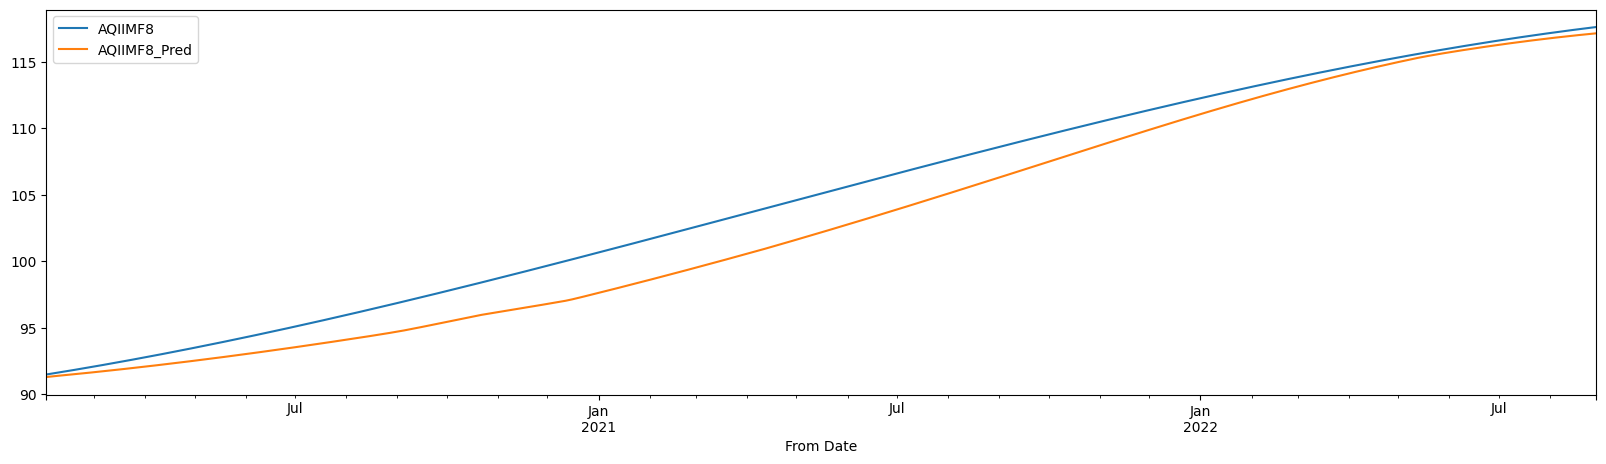

In [293]:
trueAqi= df_final['AQIIMF8']
forcastAQI = df_final['AQIIMF8_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)
df_final[['AQIIMF8','AQIIMF8_Pred']].plot()

####Test Prediction

In [294]:
predictions=IMF8model.predict(test_generator)

9/9 [==============================] - 0s 3ms/step


In [295]:
df_pred = pd.DataFrame(predictions)

In [296]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [297]:
df_final=test

In [298]:
AQIIMF8_Preddata=df_final[predictions.shape[0]*-1:]
AQIIMF8_Preddata

AQIIMF8   PM10IMF8  PM2.5IMF8
From Date                                   
2022-09-30  118.046149  97.368595  35.882949
2022-10-01  118.058921  97.362939  35.875021
2022-10-02  118.071617  97.357226  35.867127
2022-10-03  118.084238  97.351456  35.859265
2022-10-04  118.096784  97.345628  35.851438
...                ...        ...        ...
2023-04-26  118.874978  95.246434  35.008382
2023-04-27  118.869078  95.233085  35.008220
2023-04-28  118.863073  95.219719  35.008099
2023-04-29  118.856964  95.206338  35.008020
2023-04-30  118.850750  95.192941  35.007983

[213 rows x 3 columns]

In [299]:
all_imf=pd.concat([all_imf,AQIIMF8_Preddata],axis=1)

In [300]:
AQIIMF8_Preddata['AQIIMF8_Pred']=rev_trans[:,0]
AQIIMF8_Preddata['PM10IMF8_Pred']=rev_trans[:,1]
AQIIMF8_Preddata['PM2.5IMF8_Pred']=rev_trans[:,2]

Test AQI RMSE =  1.9706935849209477
Test AQI MAPE =  0.007357523094282382
Test AQI R2 Score =  -30.19857159105771


<Axes: xlabel='From Date'>

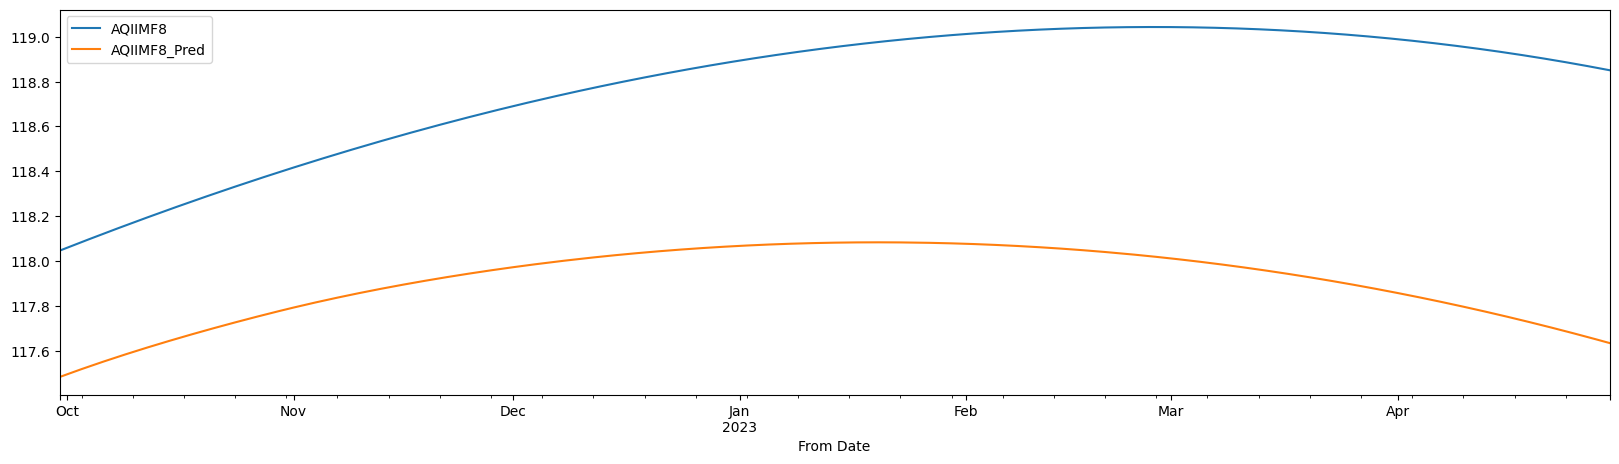

In [301]:
trueAqi= AQIIMF8_Preddata['AQIIMF8']
forcastAQI = AQIIMF8_Preddata['AQIIMF8_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Test AQI RMSE = ',train_rmse)
print("Test AQI MAPE = ", mape)
print("Test AQI R2 Score = ", r2)
AQIIMF8_Preddata[['AQIIMF8','AQIIMF8_Pred']].plot()

###Ensemble Learning Model

In [302]:
AQIIMF1_Preddata, AQIIMF2_Preddata, AQIIMF3_Preddata,AQIIMF4_Preddata,AQIIMF5_Preddata,AQIIMF6_Preddata,AQIIMF7_Preddata,AQIIMF8_Preddata

(              AQIIMF1   PM10IMF1  PM2.5IMF1  AQIIMF1_Pred  PM10IMF1_Pred  \
 From Date                                                                  
 2022-09-30  15.981450  40.627703   0.353673      8.600426       3.536311   
 2022-10-01  11.193473   6.904384   4.705893      9.131074       5.627542   
 2022-10-02 -16.508144 -46.061146  -6.374392      7.867144       1.720989   
 2022-10-03 -37.839791 -51.263621   2.168253     15.162529       7.455275   
 2022-10-04  39.407404  50.319820   6.878752     11.958730      10.405181   
 ...               ...        ...        ...           ...            ...   
 2023-04-26   4.070682   2.960873   2.795642      4.950249      -0.729897   
 2023-04-27   0.731117   0.331034   0.598608      5.688117       3.718645   
 2023-04-28  -5.760610  -5.005827  -1.699260      6.443743       4.385101   
 2023-04-29   0.965882   1.111121   1.034022     12.241109       5.659030   
 2023-04-30   4.903410   5.170679  -0.640843     14.145964       2.205587   

###Calculate AQI Predictions

In [303]:
aqipred = pd.DataFrame()

In [304]:
aqipred['Summation'] = AQIIMF1_Preddata['AQIIMF1_Pred'] + AQIIMF2_Preddata['AQIIMF2_Pred'] + AQIIMF3_Preddata['AQIIMF3_Pred'] + AQIIMF4_Preddata['AQIIMF4_Pred'] + AQIIMF5_Preddata['AQIIMF5_Pred'] + AQIIMF6_Preddata['AQIIMF6_Pred'] + AQIIMF7_Preddata['AQIIMF7_Pred'] + AQIIMF8_Preddata['AQIIMF8_Pred']

In [305]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','AQI_calculated']]
actual.set_index('From Date',inplace = True)

In [306]:
actual['AQI_Pred'] = aqipred

<Axes: xlabel='From Date'>

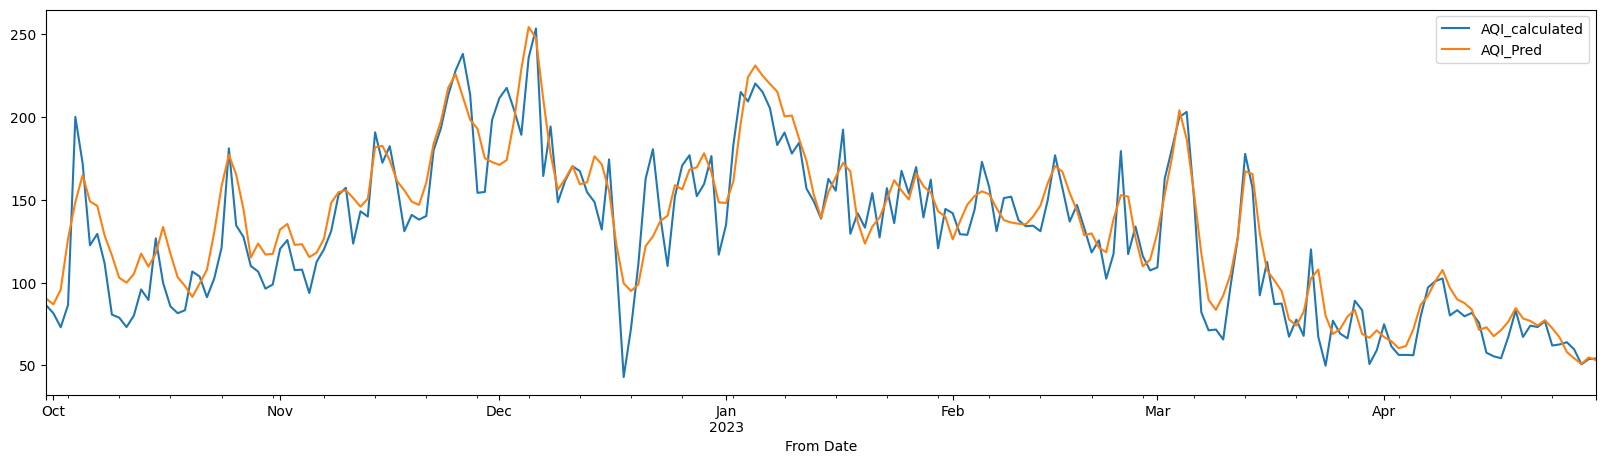

In [307]:
actual[['AQI_calculated','AQI_Pred']].plot()

In [308]:
trueAqi = actual['AQI_calculated']

forcastAQI = actual['AQI_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  18.427026189633175
Mean =  128.15325285043593
MAPE =  0.13122266620057996
R2 Score =  0.8152847146351383


###Calculate PM2.5 Predictions

In [309]:
pm25pred = pd.DataFrame()

In [310]:
pm25pred['Summation'] = AQIIMF1_Preddata['PM2.5IMF1_Pred'] + AQIIMF2_Preddata['PM2.5IMF2_Pred'] + AQIIMF3_Preddata['PM2.5IMF3_Pred'] + AQIIMF4_Preddata['PM2.5IMF4_Pred'] + AQIIMF5_Preddata['PM2.5IMF5_Pred'] + AQIIMF6_Preddata['PM2.5IMF6_Pred'] + AQIIMF7_Preddata['PM2.5IMF7_Pred'] + AQIIMF8_Preddata['PM2.5IMF8_Pred']

In [311]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','PM2.5']]
actual.set_index('From Date',inplace = True)

In [312]:
actual['PM2.5_Pred'] = pm25pred

<Axes: xlabel='From Date'>

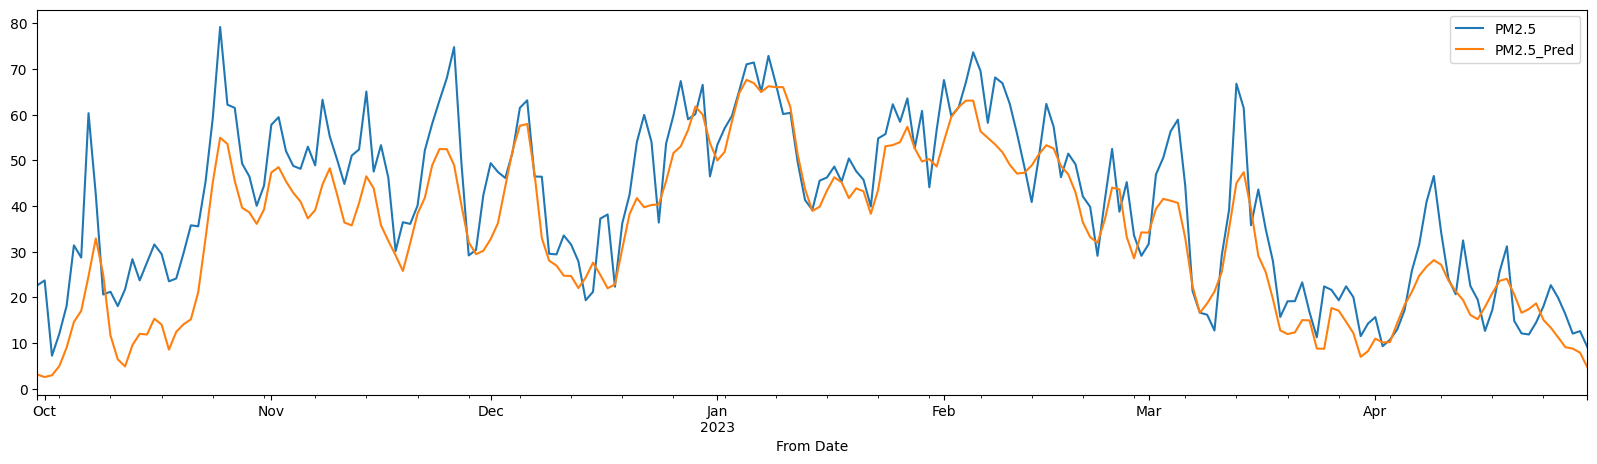

In [313]:
actual[['PM2.5','PM2.5_Pred']].plot()

In [314]:
trueAqi = actual['PM2.5']

forcastAQI = actual['PM2.5_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  9.788713227343086
Mean =  41.001222892913034
MAPE =  0.22165837995940701
R2 Score =  0.6586537834749069


###Calculate PM10 Predictions

In [315]:
pm10pred = pd.DataFrame()

In [316]:
pm10pred['Summation'] = AQIIMF1_Preddata['PM10IMF1_Pred'] + AQIIMF2_Preddata['PM10IMF2_Pred'] + AQIIMF3_Preddata['PM10IMF3_Pred'] + AQIIMF4_Preddata['PM10IMF4_Pred'] + AQIIMF5_Preddata['PM10IMF5_Pred'] + AQIIMF6_Preddata['PM10IMF6_Pred'] + AQIIMF7_Preddata['PM10IMF7_Pred'] + AQIIMF8_Preddata['PM10IMF8_Pred']

In [317]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','PM10']]
actual.set_index('From Date',inplace = True)

In [318]:
actual['PM10_Pred'] = pm10pred

<Axes: xlabel='From Date'>

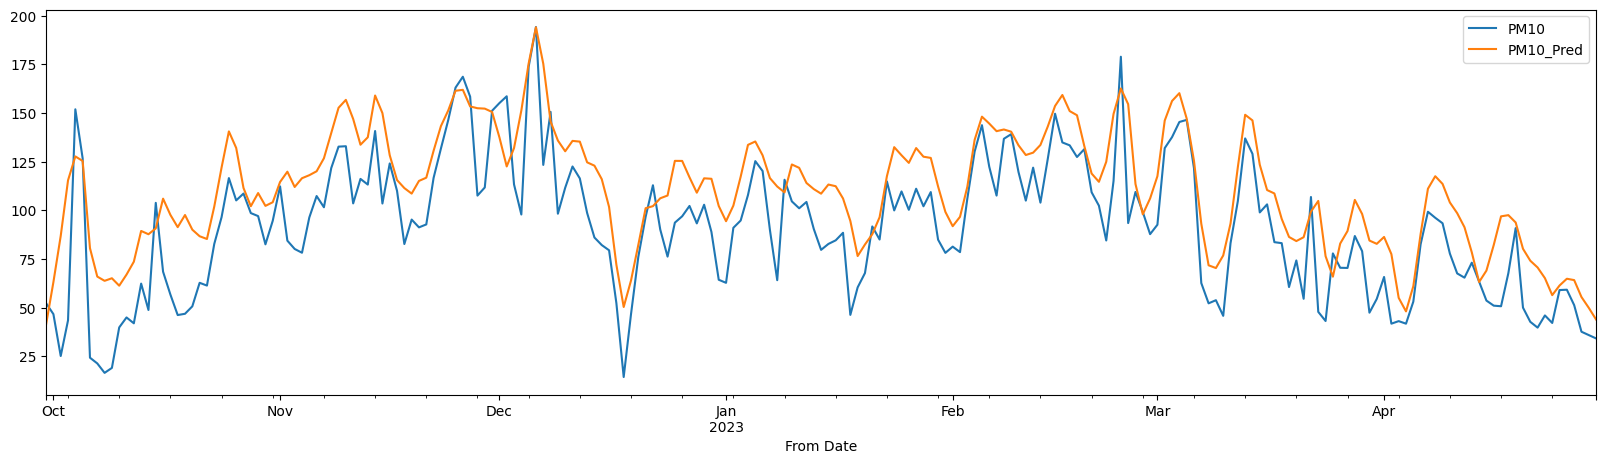

In [319]:
actual[['PM10','PM10_Pred']].plot()

In [320]:
trueAqi = actual['PM10']

forcastAQI = actual['PM10_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  25.31216502668321
Mean =  91.09790856248603
MAPE =  0.33652885516948294
R2 Score =  0.26320725205744067


###Forecasting

In [321]:
forecast_all, forecast_all1,forecast_all2, forecast_all3,forecast_all4, forecast_all5,forecast_all6, forecast_all7

(              AQIIMF1  PM2.5IMF1  PM10IMF1
 Dates                                     
 2023-05-01  15.331092  -1.701272  2.597473
 2023-05-02  10.773601  -2.099337  3.519988
 2023-05-03   9.023029  -2.340787  5.049973
 2023-05-04   7.688847  -2.378087  5.458530
 2023-05-05  10.461334  -2.675635  5.146469
 2023-05-06  13.448442  -2.496794  6.206793
 2023-05-07  12.618681  -2.779628  6.625929
 2023-05-08  10.791038  -2.716064  7.277983
 2023-05-09   9.619827  -2.717536  6.766987
 2023-05-10  10.880036  -2.562428  6.913821
 2023-05-11  11.603583  -2.716493  6.775189
 2023-05-12  11.930793  -2.723338  6.717650
 2023-05-13  11.479127  -2.745937  6.824715
 2023-05-14  11.124383  -2.708835  6.859155
 2023-05-15  11.175267  -2.675807  6.489337
 2023-05-16  11.564002  -2.674290  6.517150
 2023-05-17  11.403082  -2.690736  6.536931
 2023-05-18  11.419051  -2.672597  6.738986
 2023-05-19  11.177359  -2.693338  6.832886
 2023-05-20  11.196164  -2.671070  6.731874
 2023-05-21  11.321083  -2.67036

In [322]:
forecast_all7['predPM10'] = forecast_all7['PM10IMF1']+ forecast_all7['PM10IMF2']+ forecast_all7['PM10IMF3'] + forecast_all7['PM10IMF4']+ forecast_all7['PM10IMF5']+ forecast_all7['PM10IMF6']+ forecast_all7['PM10IMF7']+ forecast_all7['PM10IMF8']
forecast_all7['predAQI'] = forecast_all7['AQIIMF1'] + forecast_all7['AQIIMF2'] + forecast_all7['AQIIMF3'] + forecast_all7['AQIIMF4'] + forecast_all7['AQIIMF5'] + forecast_all7['AQIIMF6'] + forecast_all7['AQIIMF7'] + forecast_all7['AQIIMF8']
forecast_all7['predPM2.5'] = forecast_all7['PM2.5IMF1']+ forecast_all7['PM2.5IMF2']+ forecast_all7['PM2.5IMF3'] + forecast_all7['PM2.5IMF4']+ forecast_all7['PM2.5IMF5']+ forecast_all7['PM2.5IMF6']+ forecast_all7['PM2.5IMF7'] + forecast_all7['PM2.5IMF8']

###Forecasting AQI

Train AQI RMSE =  52.97127737513444
Train AQI MAPE =  0.7508643806778708
Train AQI R2 Score =  -3.7003697260736867


<Axes: xlabel='From Date', ylabel='AQI_calculated'>

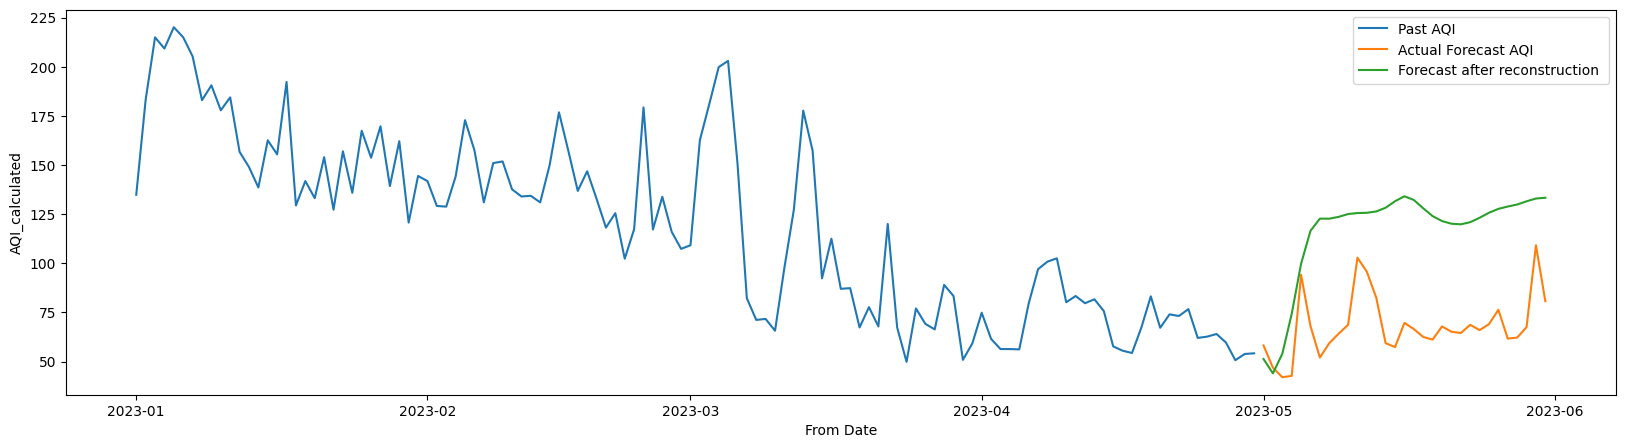

In [323]:
trueAqi= true_forecast1['AQI_calculated']
forcastAQI = forecast_all7['predAQI']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)

fd = final_df[final_df['From Date'] >= '2023-01-01']
sns.lineplot(x=fd['From Date'], y=fd['AQI_calculated'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQI_calculated'],label = 'Actual Forecast AQI')
sns.lineplot(x=forecast_all7.index, y=forecast_all7['predAQI'],label = 'Forecast after reconstruction ')

###Forecasting PM2.5

Train AQI RMSE =  6.461934839627321
Train AQI MAPE =  0.4632617291753982
Train AQI R2 Score =  -0.09190398335654781


<Axes: xlabel='From Date', ylabel='AQI_calculated'>

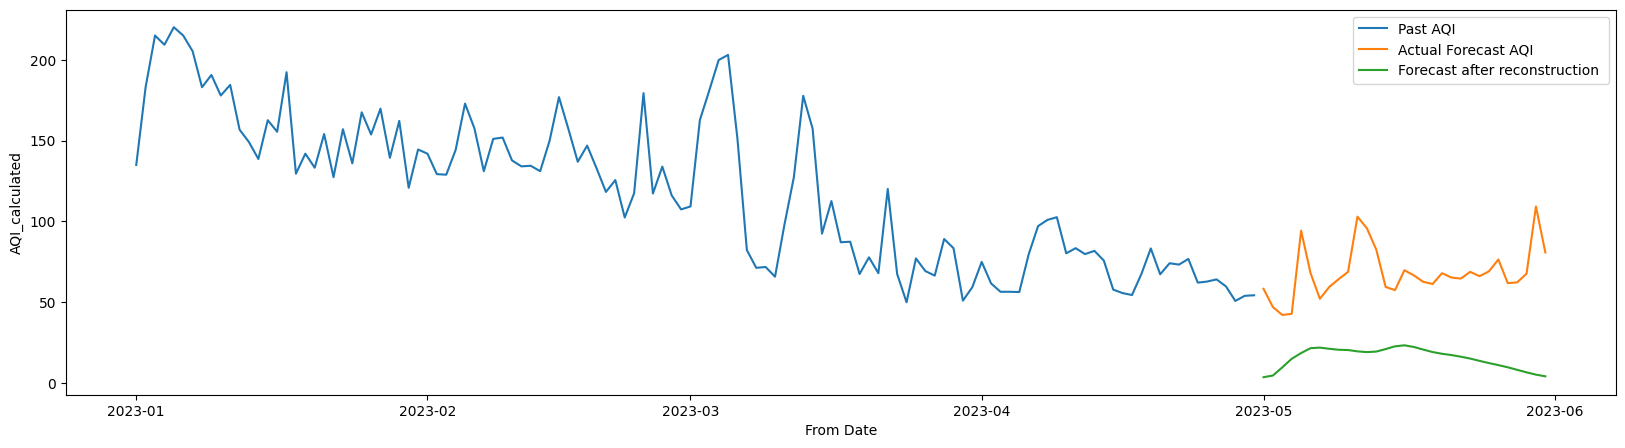

In [324]:
trueAqi= true_forecast1['PM2.5']
forcastAQI = forecast_all7['predPM2.5']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)

fd = final_df[final_df['From Date'] >= '2023-01-01']
sns.lineplot(x=fd['From Date'], y=fd['AQI_calculated'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQI_calculated'],label = 'Actual Forecast AQI')
sns.lineplot(x=forecast_all7.index, y=forecast_all7['predPM2.5'],label = 'Forecast after reconstruction ')

###Forecasting PM10

Train AQI RMSE =  31.19477053662015
Train AQI MAPE =  0.710898970314189
Train AQI R2 Score =  -4.615949917815331


<Axes: xlabel='From Date', ylabel='AQI_calculated'>

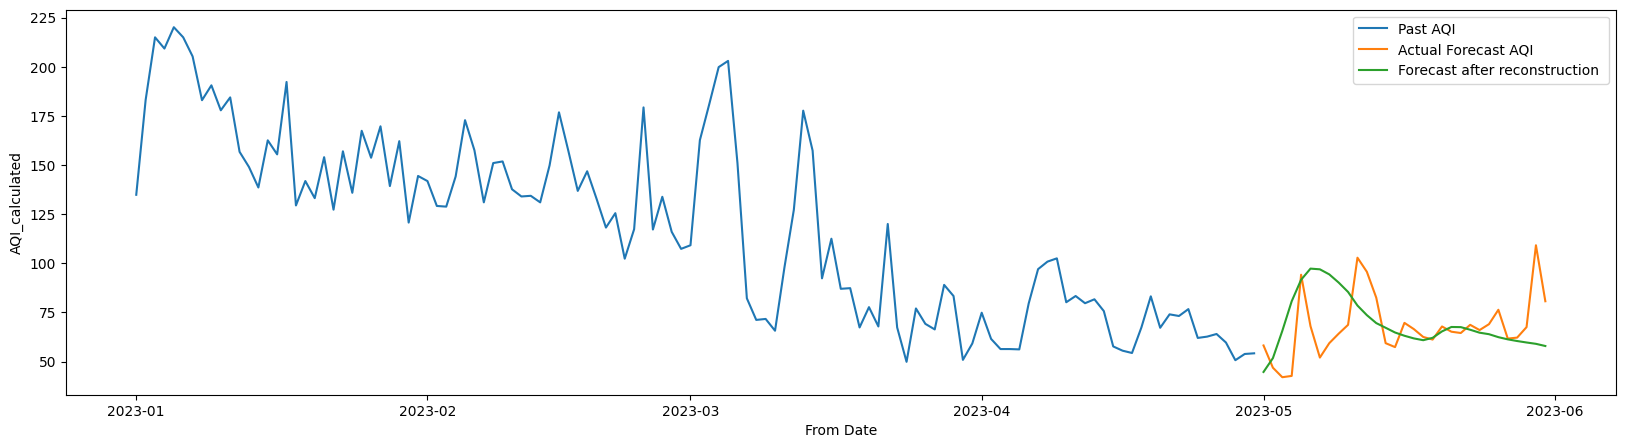

In [325]:
trueAqi= true_forecast1['PM10']
forcastAQI = forecast_all7['predPM10']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('Train AQI RMSE = ',train_rmse)
print("Train AQI MAPE = ", mape)
print("Train AQI R2 Score = ", r2)

fd = final_df[final_df['From Date'] >= '2023-01-01']
sns.lineplot(x=fd['From Date'], y=fd['AQI_calculated'], label = 'Past AQI')
sns.lineplot(x=true_forecast1.index, y=true_forecast1['AQI_calculated'],label = 'Actual Forecast AQI')
sns.lineplot(x=forecast_all7.index, y=forecast_all7['predPM10'],label = 'Forecast after reconstruction ')